**Pokemon GO case**

**Team 6**

- CEDRIC RANDRIAMAMPIONONA
- GIACOMO NUBE
- CHRISTOS GKORITSAS
- VARUN SAI BERA
- MOHAMMED BEYAI
- DHRUVIN ACHARYA

**You can use the "Table of Contents" feature to better navigate through the code file**

# StepWise

In [1]:
#Copyright 2019 Sinan Talha Hascelik
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

# Repo: https://github.com/talhahascelik/python_stepwiseSelection

import numpy as np
import pandas as pd
import statsmodels.api as sm

def forwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
  X = __varcharProcessing__(X,varchar_process = varchar_process)
  return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def backwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
  X = __varcharProcessing__(X,varchar_process = varchar_process)
  return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
  dtypes = X.dtypes
  if varchar_process == "drop":
    X = X.drop(columns = dtypes[dtypes == object].index.tolist())
    print("Character Variables (Dropped):", dtypes[dtypes == object].index.tolist())
  elif varchar_process == "dummy":
    X = pd.get_dummies(X,drop_first=False,dtype=int)
    print("Character Variables (Dummies Generated):", dtypes[dtypes == object].index.tolist())
  elif varchar_process == "dummy_dropfirst":
    X = pd.get_dummies(X,drop_first=True,dtype=int)
    print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())
  else:
    X = pd.get_dummies(X,drop_first=True,dtype=int)
    print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())

  X["intercept"] = 1
  cols = X.columns.tolist()
  cols = cols[-1:] + cols[:-1]
  X = X[cols]

  return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor

    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")

    model = regressor(y, X[selected_cols])

    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj


    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals=pd.concat([pvals,pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"])],ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:

            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])

        else:
            print("Break : Significance Level")
            break

    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj

    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log,model

def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    last_eleminated = ""
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break
            else:
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")

                    del X[j]
                    last_eleminated = j
        else:
            break
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log,model

#Copyright 2019 Emirhan Kartal
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
  X = __varcharProcessing__(X,varchar_process = varchar_process)
  return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor

    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")

    model = regressor(y, X[selected_cols])

    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj


    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals=pd.concat([pvals,pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"])],ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:

            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):

                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])


                for l in cols_backward:
                    pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)

                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:


                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n")

                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass

                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass

                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


                else:
                    print("break : No need to Backward Elimination")
                    break


            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])

        else:
            print("Break : Significance Level")
            break

    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj

    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)


    iterations_log += "\nFinal Selection and Model Statistics\n"

    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m])

    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


    return selected_cols, iterations_log,model


def prediction_stepwise(X,model,varchar_process = "dummy_dropfirst"):
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    Xpred=X[np.intersect1d(X.columns,model[0])]#only select var retained from model
    Xpred=Xpred.reindex(columns=model[0])#sort them according to the sequence used in the model
    p=model[2].predict(Xpred)
    return p

# Model Performance Measure (Professor's Function)

In [2]:
import pandas

#confusion matrix related performance measures
def evaluate_model(actual, pred,cutoff=0.5):
    #confusion matrix
    cm_df = pandas.DataFrame(confusion_matrix(actual,pred>cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    print("Cutoff used: ",cutoff)
    print(cm_df)
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred>cutoff)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred>cutoff)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    sens_score = round(recall_score(actual, pred>cutoff)*100,2)#recall=sensitivity
    print('sensitivity score : ', sens_score)
    tn, fp, fn, tp = confusion_matrix(actual,pred>cutoff).ravel()
    spec_score = round((tn / (tn + fp))*100,2)
    print('specificity score : ', spec_score)
    fpr, tpr, _ = roc_curve(actual,pred)
    auc = roc_auc_score(actual,pred)
    roccurve=(pn.ggplot(pn.aes(x=fpr,y=tpr))+
                 pn.geom_line(color='red')+
                 pn.scale_y_continuous(name='sensitivity,true positive rate' ) +
                 pn.scale_x_continuous(name='1-specificity, false positive rate' ) +
                 pn.ggtitle('Roc curve: '+str(np.round(auc,2))))
    print(roccurve)
    return acc_score, roc_score, prec_score, sens_score, spec_score


#how does the accuracy change for different cutoff values
def AccuracyCutoffInfo(training,validation,depvar='churn',pred='predict'):
    # change the cutoff value's range as you please
    cutoff=np.arange(0.1, 0.85, 0.05)
    cm_train=[0]*len(cutoff)
    cm_validation=[0]*len(cutoff)
    for i in range(0,len(cutoff)):
        cm_train[i]=accuracy_score(training[depvar], training[pred]>cutoff[i])
        cm_validation[i]=accuracy_score(validation[depvar], validation[pred]>cutoff[i])
    accuracytable=pandas.concat([pandas.Series(cutoff).rename('cutoff'),pandas.Series(cm_train).rename('train'),pandas.Series(cm_validation).rename('validation')],axis=1)
    accplot=(pn.ggplot(accuracytable, pn.aes(x='cutoff')) +
    pn.geom_line( pn.aes(y = 'train'), color = "darkred")+
    pn.geom_line( pn.aes(y = 'validation'), color = "steelblue")+
    pn.geom_point(pn.aes(y = 'train'))+
    pn.geom_point(pn.aes(y = 'validation'))+
    pn.scale_y_continuous( labels=percent_format() ) +
    pn.ggtitle( "Train/validation accuracy for different cutoff values" ))
    accplot.show()


#confusionmatrixscatterplot
#create classification table first
def confusionmatrixplot(depvar,pred,cutoff=0.5):
    df=pandas.concat([pandas.Series(depvar).rename('depvar'),pandas.Series(pred).rename('pred')],axis=1)
    def categorize(depvar,pred,cutoff):
        if (pred>=cutoff and depvar==1):
            return 'TP'
        elif (pred>=cutoff and depvar==0):
            return 'FP'
        elif(pred<cutoff and depvar==1):
            return 'FN'
        else:
            return 'TN'
    df['type']=df.apply(lambda X: categorize(X.depvar,X.pred,cutoff), axis=1)
    #plot table
    confusionplot= (pn.ggplot(df, pn.aes(x='depvar',y='pred', color = 'type' ) ) +
        pn.geom_jitter() +
        pn.geom_hline( yintercept = cutoff, color = "blue", alpha = 0.6 ) +
        pn.scale_y_continuous( limits = (0.0,1.0) ) +
        pn.scale_color_discrete( breaks = [ "TP", "FN", "FP", "TN" ] ) + # ordering of the legend
        pn.ggtitle("Confusion Matrix with cutoff: "+str(cutoff)))
    confusionplot.show()


#find the cutoff that leads to the lowest costs
def findoptcutoff(depvar,pred):
    cutoff=np.arange(0.01, 0.99, 0.01)
    cost_fp=1 #providing a discount to a non churner
    cost_fn=4 #not identifying a churner and missing out on his clv
    costs=[0]*len(cutoff)
    bestcost=sys.maxsize
    bestindex=0
    for i in range(0,len(cutoff)):
        cm_df = pandas.DataFrame(confusion_matrix(depvar,pred>cutoff[i]))
        am_fp=cm_df[1][0]
        am_fn=cm_df[0][1]
        costs[i]=am_fp*cost_fp+am_fn*cost_fn
        if(costs[i]<bestcost):
            bestcost=costs[i]
            bestindex=i
    cutofftable=pandas.concat([pandas.Series(cutoff).rename('cutoff'),pandas.Series(costs).rename('costs')],axis=1)
    cutoffchart=(pn.ggplot(cutofftable, pn.aes(x = 'cutoff', y = 'costs',color='costs'))+
       pn.theme_bw() +
       pn.theme(panel_grid = pn.element_blank())+
       pn.geom_point()+
       pn.scale_colour_gradient2(low = "green", high = "red", mid = "yellow",midpoint=8000)+
      pn. ggtitle("Total cost for different cutoff values"))
    cutoffchart.show()
    print('best cutoff: ', cutoff[bestindex])
    return cutoff[bestindex]


#decile/lift table and chart
def calc_lift(depvar,pred,groups=10):
        helper=pandas.concat([pandas.Series(depvar).rename('depvar'),pandas.Series(pred).rename('pred')],axis=1)
        #reverse sort dataset based on pred
        helper=helper.sort_values(by=['pred'],ascending=False)
        helper['id']=range(0,len(helper['depvar']))
        #create new bucket variable highest pred in bucket 1
        helper['bucket']=pandas.qcut(helper['id'],q=10,labels=range(1, 10+1))
        #convert categorical bucket variable into a numeric one
        helper['bucket']=pandas.to_numeric(helper['bucket'])
        #create gaintable: count number of churners per bucket and total customers in a bucket
        lifttable=helper.groupby("bucket", as_index=False).agg(total=('depvar','count'),totalresp=('depvar','sum'))
        #calculate cumulative number of churners
        lifttable['cumresp']=lifttable['totalresp'].cumsum()
        #calculate lift: how many churners did you catch out of the total number of customers in a bucket
        lifttable['lift']=lifttable['cumresp']/sum(lifttable['totalresp'])*100
        #calculate cumulative lift
        lifttable['cumlift']=lifttable['lift']/(lifttable['bucket']*(100/groups))
        return lifttable

def plot_liftchart(depvar,pred):
    lifttable=calc_lift(depvar,pred)
    liftchart=(pn.ggplot(lifttable, pn.aes(x = 'bucket', y = 'cumlift'))+
      pn.theme_bw() +
      pn.theme(panel_grid = pn.element_blank())+#removes colored box behind bar chart
      pn.scale_x_continuous(breaks=range(1,11)) +
      pn.geom_point()+
      pn.geom_smooth()+
      pn.geom_text(pn.aes(x='bucket+0.5',y='cumlift', label='np.round(cumlift,2)')) +
      pn.ggtitle("Lift curve"))
    liftchart.show()
    return lifttable

# Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.cm as cm
import missingno #package to find and display na
from plotnine import *
import pandas# working with datraframes
import datetime# working with dates
import missingno #package to find and display na
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from mizani.formatters import percent_format
import sys
import plotnine as pn

# Data importing

Let's import the data. Since the code will be very lengthy, we decided to create dictionaries to store the variables in order to improve their overall readability and structure.

In [110]:
# We start by creating dictionaries for organization and readability

dates = {
    'summerstart' : pd.to_datetime('2022-05-01'),
    'summerend' : pd.to_datetime('2022-08-31'),
    'fallstart' : pd.to_datetime('2022-09-01'),
    'fallend' : pd.to_datetime('2022-12-31')
    }

data = {
        'customerdata' : pd.read_csv('customerdata.csv',parse_dates=['Registrationdate']),
        'summerfintrx' : pd.read_csv('summerfintrx.csv',parse_dates=['Date']),
        'summersesstrx' : pd.read_csv('summersesstrx.csv',parse_dates=['Date']),
        'fallfintrx' : pd.read_csv('fallfintrx.csv',parse_dates=['Date']),
        'fallsesstrx' : pd.read_csv('fallsesstrx.csv',parse_dates=['Date'])
        }

#convert datetime to date (we don't need the hour)
data['summerfintrx']['Date'] = pd.to_datetime(data['summerfintrx']['Date'])
data['summersesstrx']['Date'] = pd.to_datetime(data['summersesstrx']['Date'])
data['fallfintrx']['Date'] = pd.to_datetime(data['fallfintrx']['Date'])
data['fallsesstrx']['Date'] = pd.to_datetime(data['fallsesstrx']['Date'])
data['customerdata']['Registrationdate'] = pd.to_datetime(data['customerdata']['Registrationdate'])

# Question 1 - Creation of a basetable + profiling

Next we will proceed with the analysis of the financial data.

In [111]:
analysis = { 'summerfin' : data['summerfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))}

#finding active customers
active = {
    'summer' : data['summersesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                         recency = ('Date', lambda date: (dates['summerend'] - date.max()).days))
    }
active['summer']['recency'] = active['summer']['recency'].astype(int)

active['fall']=data['fallsesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                     recency = ('Date', lambda date: (dates['fallend'] - date.max()).days))
active['fall']['recency'] = active['fall']['recency'].astype(int)

Then we will create the basetable in accordance with question 1.

In [114]:
#creating basetables
basetable = {
    'summer' : active['summer'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')
    }

analysis['summerfin'] = data['summerfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))

basetable['summer'] = basetable['summer'].merge(analysis['summerfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['summer'].fillna(0, inplace=True) #Many of the players didn’t make any purchase in the game, so for those we will assign the value 0.

basetable['fall'] = active['fall'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')

analysis['fallfin'] = data['fallfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))
basetable['fall'] = basetable['fall'].merge(analysis['fallfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['fall'].fillna(0, inplace=True)

Then let's also create some additional dictionaries for more advanced analyses.

In [ ]:
# Finding number of customers who received the fall bonus
fallbonus = {
    'num' : basetable['summer']['fallbonus'].sum()}

# setting information for CLV calculations
CLV = {
       'summer' : basetable['summer'][['CustomerID', 'MonetaryValue']],
       'AC' : 1,
       'Discount_rate' : 0.085,
       'periods' : 3
       }

def calc_clv(margin, r, d, acquisition,t): #we will use this formula for CLV calculations
    clv=-acquisition
    for i in range(0,t+1):
         clv=clv+(pow(r,i)*margin)/(pow((1+d),i))
    return(clv)

#calculating retention rate in fall
analysis['retention for fall']= len(pd.unique(data['fallsesstrx']['CustomerID']))/ len(pd.unique(data['summersesstrx']['CustomerID']))

active['fall']=data['fallsesstrx'].groupby('CustomerID',as_index=False).agg(frequency=('CustomerID','count'),
                                                                     recency = ('Date', lambda date: (dates['fallend'] - date.max()).days))
active['fall']['recency'] = active['fall']['recency'].astype(int)

basetable['fall'] = active['fall'].merge(data['customerdata'], how='inner', left_on = 'CustomerID', right_on = 'CustomerID')

analysis['fallfin'] = data['fallfintrx'].groupby('CustomerID', as_index=False).agg(MonetaryValue=('Value','sum'))
basetable['fall'] = basetable['fall'].merge(analysis['fallfin'], how='left', left_on = 'CustomerID', right_on = 'CustomerID')
basetable['fall'].fillna(0, inplace=True)

analysis['retention for fall']= len(pd.unique(data['fallsesstrx']['CustomerID']))/ len(pd.unique(data['summersesstrx']['CustomerID']))

In [115]:
# Calculating the total basetable
basetable['all'] = data['customerdata']
basetable['all']['MonetaryValueS'] = basetable['summer']['MonetaryValue']
basetable['all']['MonetaryValueF'] = basetable['fall']['MonetaryValue']
basetable['all'].fillna(0, inplace=True) #If the value is missing it is because no purchase was made in fall so we should set it at 0.
basetable['all']['MonetaryValue'] = basetable['all']['MonetaryValueS'] + basetable['all']['MonetaryValueF']

Let's take a look at our dataframes

In [7]:
basetable['summer']

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue  
0        8          0       0           0.00  
1       45          0       2           0.00  
2       29          1       2           0.00  
3       18          0       2           4.99  
4       48          1       0           0.00  
...    ...        ...     ...            ...  
49758    9          1       0           0.00  
49759   37          0       0           0.00  
49760   27          1       1           9.98  
49761   28          0       2           0.00  
49762   26          0       0           0.00  

[49763 rows x 10 columns]

In [8]:
print(data['customerdata'].head())
data['customerdata'].describe()

   CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  Income  \
0           1             2       2021-01-01       0    8          0       0   
1           2             3       2022-01-21       0   45          0       2   
2           3             1       2021-05-27       0   29          1       2   
3           4             3       2022-04-10       1   18          0       2   
4           5             1       2021-05-16       1   48          1       0   

   MonetaryValueS  MonetaryValueF  MonetaryValue  
0            0.00            0.00           0.00  
1            0.00            0.00           0.00  
2            0.00            0.00           0.00  
3            4.99           29.99          34.98  
4            0.00            0.00           0.00  


CustomerID  CustomerType               Registrationdate  \
count  50000.000000  50000.000000                          50000   
mean   25000.500000      1.562240  2020-12-30 04:16:45.119999744   
min        1.000000      0.000000            2016-07-01 00:00:00   
25%    12500.750000      1.000000            2020-03-15 00:00:00   
50%    25000.500000      2.000000            2021-12-26 00:00:00   
75%    37500.250000      3.000000            2022-03-02 00:00:00   
max    50000.000000      3.000000            2022-04-30 00:00:00   
std    14433.901067      1.107281                            NaN   

             Gender          Age     fallbonus        Income  MonetaryValueS  \
count  50000.000000  50000.00000  50000.000000  50000.000000    50000.000000   
mean       0.399240     27.81278      0.202080      0.875540        3.968635   
min        0.000000      6.00000      0.000000      0.000000        0.000000   
25%        0.000000     18.00000      0.000000      0.000000        0.000000   
50%        0.000000     28.00000      0.000000      1.000000        0.000000   
75%        1.000000     34.00000      0.000000      2.000000        2.990000   
max        1.000000     80.00000      1.000000      2.000000      212.980000   
std        0.489747     13.63387      0.401556      0.810791       10.666583   

       MonetaryValueF  MonetaryValue  
count     50000.00000   50000.000000  
mean          2.80814       6.776775  
min           0.00000       0.000000  
25%           0.00000       0.000000  
50%           0.00000       2.990000  
75%           2.99000       7.980000  
max         136.98000     212.980000  
std           8.60690      13.721039

In [9]:
print(data['summerfintrx'].head())
data['summerfintrx'].describe()

   TransactionID       Date  CustomerID  ProductID  SessionID  Value
0              1 2022-08-06           4          1         21   4.99
1              2 2022-06-23           8          0         45   2.99
2              3 2022-06-12           9          1         54   4.99
3              4 2022-07-23          24          3        170  25.00
4              5 2022-06-22          24          2        177   9.99


TransactionID                           Date    CustomerID  \
count   21902.000000                          21902  21902.000000   
mean    10951.500000  2022-06-30 12:46:17.171034624  25065.498493   
min         1.000000            2022-05-01 00:00:00      4.000000   
25%      5476.250000            2022-05-31 00:00:00  12595.000000   
50%     10951.500000            2022-07-01 00:00:00  25029.000000   
75%     16426.750000            2022-07-31 00:00:00  37631.750000   
max     21902.000000            2022-08-30 00:00:00  49998.000000   
std      6322.707134                            NaN  14442.218469   

          ProductID      SessionID         Value  
count  21902.000000   21902.000000  21902.000000  
mean       1.114967  190040.307324      9.059984  
min        0.000000      21.000000      2.990000  
25%        0.000000   95486.500000      2.990000  
50%        1.000000  189921.000000      4.990000  
75%        2.000000  285170.750000      9.990000  
max        4.000000  379249.000000     99.000000  
std        1.079391  109498.764465     12.863693

In [10]:
print(data['summersesstrx'].head())
data['summersesstrx'].describe()

   SessionID       Date  CustomerID  Pokestops  Gyms  Raids  Social  Pokemons  \
0          1 2022-06-21           1          8    10      1       1        10   
1          2 2022-07-24           1         11     6      1       0        15   
2          3 2022-08-19           1         10     6      1       0        10   
3          4 2022-07-25           1         11     6      0       1        12   
4          5 2022-08-22           1         11    13      1       3        15   

   Distance   Duration  Experience  
0  1.233315  68.136824        4223  
1  1.886196  93.646617        3688  
2  1.010268  74.959642        3301  
3  3.735159  81.048298        2923  
4  1.895665  69.677535        5689  


SessionID                           Date     CustomerID  \
count  379271.00000                         379271  379271.000000   
mean   189636.00000  2022-06-30 12:24:43.355173888   25012.237160   
min         1.00000            2022-05-01 00:00:00       1.000000   
25%     94818.50000            2022-05-31 00:00:00   12508.000000   
50%    189636.00000            2022-07-01 00:00:00   24992.000000   
75%    284453.50000            2022-07-31 00:00:00   37537.000000   
max    379271.00000            2022-08-30 00:00:00   50000.000000   
std    109486.25131                            NaN   14440.564038   

           Pokestops           Gyms          Raids         Social  \
count  379271.000000  379271.000000  379271.000000  379271.000000   
mean       15.025217       6.707555       0.477015       0.783416   
min         6.000000       0.000000       0.000000       0.000000   
25%        12.000000       4.000000       0.000000       0.000000   
50%        15.000000       6.000000       0.000000       0.000000   
75%        17.000000       9.000000       0.000000       1.000000   
max        31.000000      35.000000      18.000000      34.000000   
std         3.343776       3.659085       1.091309       1.602935   

            Pokemons       Distance       Duration     Experience  
count  379271.000000  379271.000000  379271.000000  379271.000000  
mean       18.074390       3.573510      66.837787    3987.040794  
min         1.000000       0.032782       5.828665    1071.000000  
25%        11.000000       1.340758      31.773864    3122.000000  
50%        16.000000       2.258937      53.738999    3729.000000  
75%        22.000000       4.665085      94.756357    4504.000000  
max        94.000000      36.144597     303.425316   22300.000000  
std         9.638298       3.381471      42.785957    1353.653642

In [11]:
print(data['fallfintrx'].head())
data['fallfintrx'].describe()

   TransactionID       Date  CustomerID  ProductID  SessionID  Value
0              1 2022-11-12           4          3         15  25.00
1              2 2022-09-29           4          1         18   4.99
2              3 2022-10-09           8          2         35   9.99
3              4 2022-11-09           9          1         42   4.99
4              5 2022-12-08          24          2        142   9.99


TransactionID                           Date    CustomerID  \
count   16251.000000                          16251  16251.000000   
mean     8126.000000  2022-10-31 00:28:15.994092800  24905.111685   
min         1.000000            2022-09-01 00:00:00      4.000000   
25%      4063.500000            2022-10-01 00:00:00  12401.000000   
50%      8126.000000            2022-10-31 00:00:00  24797.000000   
75%     12188.500000            2022-12-01 00:00:00  37432.500000   
max     16251.000000            2022-12-30 00:00:00  49998.000000   
std      4691.403948                            NaN  14434.771328   

          ProductID      SessionID         Value  
count  16251.000000   16251.000000  16251.000000  
mean       1.059073  148583.882776      8.639898  
min        0.000000      15.000000      2.990000  
25%        0.000000   74054.500000      2.990000  
50%        1.000000  147778.000000      4.990000  
75%        2.000000  223097.000000      9.990000  
max        4.000000  299171.000000     99.000000  
std        1.063616   86201.183939     12.418591

In [12]:
print(data['fallsesstrx'].head())
data['fallsesstrx'].describe()

   SessionID       Date  CustomerID  Pokestops  Gyms  Raids  Social  Pokemons  \
0          1 2022-10-04           1         12    15      1       3        14   
1          2 2022-10-24           1         10    16      2       2        13   
2          3 2022-11-03           2         17    10      0       1        28   
3          4 2022-10-27           2         16     6      0       0        23   
4          5 2022-10-18           2         18     7      0       0        26   

   Distance   Duration  Experience  
0  0.816944  83.787773        5981  
1  1.963824  48.337727        6946  
2  1.742596  15.227669        4624  
3  1.248686  41.884230        3274  
4  0.385583  30.112946        3638  


SessionID                           Date     CustomerID  \
count  299185.000000                         299185  299185.000000   
mean   149593.000000  2022-10-30 23:21:43.007838208   25073.796955   
min         1.000000            2022-09-01 00:00:00       1.000000   
25%     74797.000000            2022-10-01 00:00:00   12522.000000   
50%    149593.000000            2022-10-31 00:00:00   25112.000000   
75%    224389.000000            2022-11-30 00:00:00   37640.000000   
max    299185.000000            2022-12-30 00:00:00   50000.000000   
std     86367.414481                            NaN   14462.238686   

           Pokestops           Gyms          Raids         Social  \
count  299185.000000  299185.000000  299185.000000  299185.000000   
mean       15.058923       6.711038       0.470064       0.780748   
min         5.000000       0.000000       0.000000       0.000000   
25%        12.000000       4.000000       0.000000       0.000000   
50%        15.000000       6.000000       0.000000       0.000000   
75%        17.000000       9.000000       0.000000       1.000000   
max        31.000000      42.000000      18.000000      24.000000   
std         3.341680       3.661717       1.085929       1.606619   

            Pokemons       Distance       Duration     Experience  
count  299185.000000  299185.000000  299185.000000  299185.000000  
mean       18.133543       3.584800      67.024124    3986.024416  
min         1.000000       0.029427       6.389194    1048.000000  
25%        11.000000       1.342986      32.007112    3122.000000  
50%        16.000000       2.271868      53.886735    3728.000000  
75%        23.000000       4.694643      94.874952    4499.000000  
max        97.000000      39.210113     291.566855   22166.000000  
std         9.631052       3.388672      42.805896    1350.797397

In [13]:
# Check the length of the session and customer dataframes
print(len(pd.unique(data['summersesstrx']['CustomerID'])))
print(len(pd.unique(data['fallsesstrx']['CustomerID'])))
print(len(pd.unique(data['customerdata']['CustomerID'])))

49763
45074
50000


**For the summer period**

In [14]:
print(len(active['summer']))
active['summer'].describe()

49763


CustomerID     frequency       recency
count  49763.000000  49763.000000  49763.000000
mean   25009.612604      7.621546     16.599924
std    14435.222917      2.527075     16.500205
min        1.000000      1.000000      1.000000
25%    12506.500000      6.000000      5.000000
50%    25008.000000      8.000000     11.000000
75%    37520.500000     10.000000     23.000000
max    50000.000000     14.000000    122.000000

In [15]:
data['customerdata']

CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0               1             2       2021-01-01       0    8          0   
1               2             3       2022-01-21       0   45          0   
2               3             1       2021-05-27       0   29          1   
3               4             3       2022-04-10       1   18          0   
4               5             1       2021-05-16       1   48          1   
...           ...           ...              ...     ...  ...        ...   
49995       49996             0       2022-03-27       1    9          1   
49996       49997             3       2022-03-04       0   37          0   
49997       49998             2       2018-07-26       0   27          1   
49998       49999             3       2020-12-30       0   28          0   
49999       50000             3       2022-04-06       0   26          0   

       Income  MonetaryValueS  MonetaryValueF  MonetaryValue  
0           0            0.00            0.00           0.00  
1           2            0.00            0.00           0.00  
2           2            0.00            0.00           0.00  
3           2            4.99           29.99          34.98  
4           0            0.00            0.00           0.00  
...       ...             ...             ...            ...  
49995       0            0.00            0.00           0.00  
49996       0            0.00            0.00           0.00  
49997       1            0.00            0.00           0.00  
49998       2            0.00            0.00           0.00  
49999       0            0.00            0.00           0.00  

[50000 rows x 10 columns]

In [16]:
# Calculate the monetary value for basetable summer
basetable['summer']

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue  
0        8          0       0           0.00  
1       45          0       2           0.00  
2       29          1       2           0.00  
3       18          0       2           4.99  
4       48          1       0           0.00  
...    ...        ...     ...            ...  
49758    9          1       0           0.00  
49759   37          0       0           0.00  
49760   27          1       1           9.98  
49761   28          0       2           0.00  
49762   26          0       0           0.00  

[49763 rows x 10 columns]

In [17]:
basetable['summer'].describe()

CustomerID     frequency       recency  CustomerType  \
count  49763.000000  49763.000000  49763.000000  49763.000000   
mean   25009.612604      7.621546     16.599924      1.562768   
min        1.000000      1.000000      1.000000      0.000000   
25%    12506.500000      6.000000      5.000000      1.000000   
50%    25008.000000      8.000000     11.000000      2.000000   
75%    37520.500000     10.000000     23.000000      3.000000   
max    50000.000000     14.000000    122.000000      3.000000   
std    14435.222917      2.527075     16.500205      1.107671   

                    Registrationdate        Gender           Age  \
count                          49763  49763.000000  49763.000000   
mean   2020-12-29 18:16:58.732793600      0.399333     27.813416   
min              2016-07-01 00:00:00      0.000000      6.000000   
25%              2020-03-11 00:00:00      0.000000     18.000000   
50%              2021-12-30 00:00:00      0.000000     28.000000   
75%              2022-03-02 00:00:00      1.000000     34.000000   
max              2022-04-30 00:00:00      1.000000     80.000000   
std                              NaN      0.489766     13.636048   

          fallbonus        Income  MonetaryValue  
count  49763.000000  49763.000000   49763.000000  
mean       0.202219      0.873460       3.987536  
min        0.000000      0.000000       0.000000  
25%        0.000000      0.000000       0.000000  
50%        0.000000      1.000000       0.000000  
75%        0.000000      2.000000       2.990000  
max        1.000000      2.000000     212.980000  
std        0.401658      0.810463      10.688428

In [18]:
# Count the number of players that received the fallbonus in the end of summer
basetable['summer'].fallbonus.sum()

10063

**For the fall period**

In [19]:
print(len(active['fall']))
active['fall'].describe()

45074


CustomerID     frequency       recency
count  45074.000000  45074.000000  45074.000000
mean   25039.123730      6.637640     19.468452
std    14430.832629      2.515502     19.691915
min        1.000000      1.000000      1.000000
25%    12552.250000      5.000000      6.000000
50%    25079.500000      7.000000     13.000000
75%    37540.750000      9.000000     26.000000
max    50000.000000     14.000000    121.000000

In [20]:
basetable['fall'].describe()

CustomerID     frequency       recency  CustomerType  \
count  45074.000000  45074.000000  45074.000000  45074.000000   
mean   25039.123730      6.637640     19.468452      1.558393   
min        1.000000      1.000000      1.000000      0.000000   
25%    12552.250000      5.000000      6.000000      1.000000   
50%    25079.500000      7.000000     13.000000      2.000000   
75%    37540.750000      9.000000     26.000000      3.000000   
max    50000.000000     14.000000    121.000000      3.000000   
std    14430.832629      2.515502     19.691915      1.113914   

                    Registrationdate        Gender           Age  \
count                          45074  45074.000000  45074.000000   
mean   2020-12-28 16:05:07.973554432      0.398545     27.796224   
min              2016-07-01 00:00:00      0.000000      6.000000   
25%              2020-03-04 06:00:00      0.000000     18.000000   
50%              2022-01-01 00:00:00      0.000000     28.000000   
75%              2022-03-02 00:00:00      1.000000     34.000000   
max              2022-04-30 00:00:00      1.000000     80.000000   
std                              NaN      0.489604     13.606502   

          fallbonus        Income  MonetaryValue  
count  45074.000000  45074.000000   45074.000000  
mean       0.202711      0.876758       3.115033  
min        0.000000      0.000000       0.000000  
25%        0.000000      0.000000       0.000000  
50%        0.000000      1.000000       0.000000  
75%        0.000000      2.000000       2.990000  
max        1.000000      2.000000     136.980000  
std        0.402023      0.810630       9.012144

In [21]:
data['customerdata']

CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0               1             2       2021-01-01       0    8          0   
1               2             3       2022-01-21       0   45          0   
2               3             1       2021-05-27       0   29          1   
3               4             3       2022-04-10       1   18          0   
4               5             1       2021-05-16       1   48          1   
...           ...           ...              ...     ...  ...        ...   
49995       49996             0       2022-03-27       1    9          1   
49996       49997             3       2022-03-04       0   37          0   
49997       49998             2       2018-07-26       0   27          1   
49998       49999             3       2020-12-30       0   28          0   
49999       50000             3       2022-04-06       0   26          0   

       Income  MonetaryValueS  MonetaryValueF  MonetaryValue  
0           0            0.00            0.00           0.00  
1           2            0.00            0.00           0.00  
2           2            0.00            0.00           0.00  
3           2            4.99           29.99          34.98  
4           0            0.00            0.00           0.00  
...       ...             ...             ...            ...  
49995       0            0.00            0.00           0.00  
49996       0            0.00            0.00           0.00  
49997       1            0.00            0.00           0.00  
49998       2            0.00            0.00           0.00  
49999       0            0.00            0.00           0.00  

[50000 rows x 10 columns]

## 1.2) Calculate the demographics and RFM metrics for the relevant play and financial transactions database. Based on these metrics, sketch a general profile (use the correct descriptive metric for each variable) of the customer base according to demographics, spending and usage transactions.

In [22]:
data['summersesstrx'].describe()

SessionID                           Date     CustomerID  \
count  379271.00000                         379271  379271.000000   
mean   189636.00000  2022-06-30 12:24:43.355173888   25012.237160   
min         1.00000            2022-05-01 00:00:00       1.000000   
25%     94818.50000            2022-05-31 00:00:00   12508.000000   
50%    189636.00000            2022-07-01 00:00:00   24992.000000   
75%    284453.50000            2022-07-31 00:00:00   37537.000000   
max    379271.00000            2022-08-30 00:00:00   50000.000000   
std    109486.25131                            NaN   14440.564038   

           Pokestops           Gyms          Raids         Social  \
count  379271.000000  379271.000000  379271.000000  379271.000000   
mean       15.025217       6.707555       0.477015       0.783416   
min         6.000000       0.000000       0.000000       0.000000   
25%        12.000000       4.000000       0.000000       0.000000   
50%        15.000000       6.000000       0.000000       0.000000   
75%        17.000000       9.000000       0.000000       1.000000   
max        31.000000      35.000000      18.000000      34.000000   
std         3.343776       3.659085       1.091309       1.602935   

            Pokemons       Distance       Duration     Experience  
count  379271.000000  379271.000000  379271.000000  379271.000000  
mean       18.074390       3.573510      66.837787    3987.040794  
min         1.000000       0.032782       5.828665    1071.000000  
25%        11.000000       1.340758      31.773864    3122.000000  
50%        16.000000       2.258937      53.738999    3729.000000  
75%        22.000000       4.665085      94.756357    4504.000000  
max        94.000000      36.144597     303.425316   22300.000000  
std         9.638298       3.381471      42.785957    1353.653642

In [116]:
# We will use the basetable for the summer period to calculate the demographics and RFM
basetable['summer']

CustomerID  frequency  recency  CustomerType Registrationdate  Gender  \
0               1          6        9             2       2021-01-01       0   
1               2         10        8             3       2022-01-21       0   
2               3          4       50             1       2021-05-27       0   
3               4          9       11             3       2022-04-10       1   
4               5          6       52             1       2021-05-16       1   
...           ...        ...      ...           ...              ...     ...   
49758       49996         10        3             0       2022-03-27       1   
49759       49997         10       16             3       2022-03-04       0   
49760       49998          6       22             2       2018-07-26       0   
49761       49999          9        1             3       2020-12-30       0   
49762       50000         10        9             3       2022-04-06       0   

       Age  fallbonus  Income  MonetaryValue  
0        8          0       0           0.00  
1       45          0       2           0.00  
2       29          1       2           0.00  
3       18          0       2           4.99  
4       48          1       0           0.00  
...    ...        ...     ...            ...  
49758    9          1       0           0.00  
49759   37          0       0           0.00  
49760   27          1       1           9.98  
49761   28          0       2           0.00  
49762   26          0       0           0.00  

[49763 rows x 10 columns]

Let's begin with some descriptive statistics to understand our players.

In [25]:
# Check for the correlation between Income and Monetary value for both session periods and the total one
analysis['summer_correlation'] = basetable['summer']['Income'].corr(basetable['summer']['MonetaryValue'])
analysis['fall_correlation'] = basetable['fall']['Income'].corr(basetable['fall']['MonetaryValue'])
analysis['total_correlation'] = basetable['all']['Income'].corr(basetable['all']['MonetaryValue'])

print(f"Summer Correlation: {analysis['summer_correlation']}")
print(f"Fall Correlation: {analysis['fall_correlation']}")
print(f"Total Correlation: {analysis['total_correlation']}")

Summer Correlation: -0.09958113239504818
Fall Correlation: -0.04994894174300351
Total Correlation: -0.002662369660046694


In [26]:
# We will prep the values in the basetable for our graphs
basetable['summer']['Gender'] = basetable['summer']['Gender'].replace({0: 'Male', 1: 'Female'})
basetable['summer']['Income'] = basetable['summer']['Income'].replace({0: 'Low', 1: 'Medium', 2: 'High'})
basetable['summer']['CustomerType'] = basetable['summer']['CustomerType'].replace({0: 'Walker', 1: 'Miscellaneous', 2: 'Social Raider', 3: 'Catcher'})

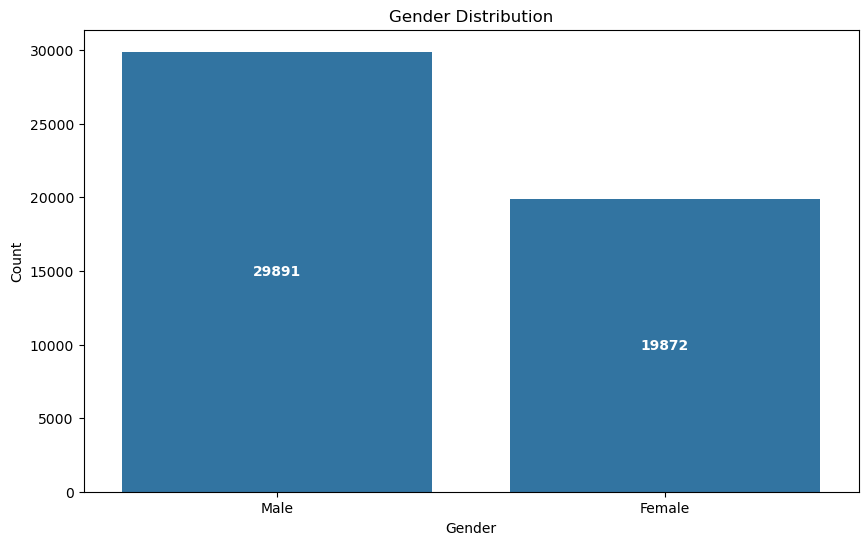

In [27]:
# Bar chart of Gender Distribution by summer Customer Data
plt.figure(figsize=(10, 6))
barplot = sns.countplot(x='Gender', data=basetable['summer'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center', color='white', fontsize=10, weight='bold')

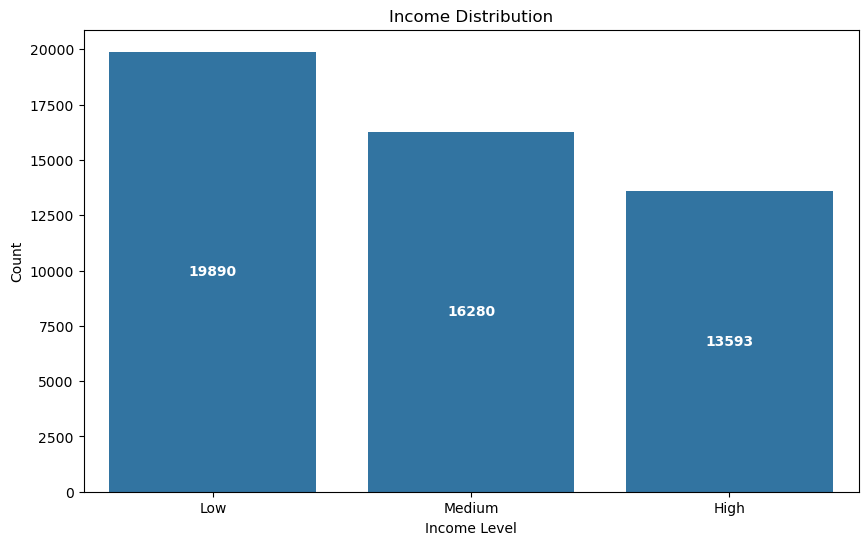

In [28]:
# Bar chart of Income Distribution by summer Customer Data
plt.figure(figsize=(10, 6))
income_order = ['Low', 'Medium', 'High']
barplot = sns.countplot(x='Income', data=basetable['summer'], order = income_order)
plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('Count')
for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center', color='white', fontsize=10, weight='bold')
plt.show()

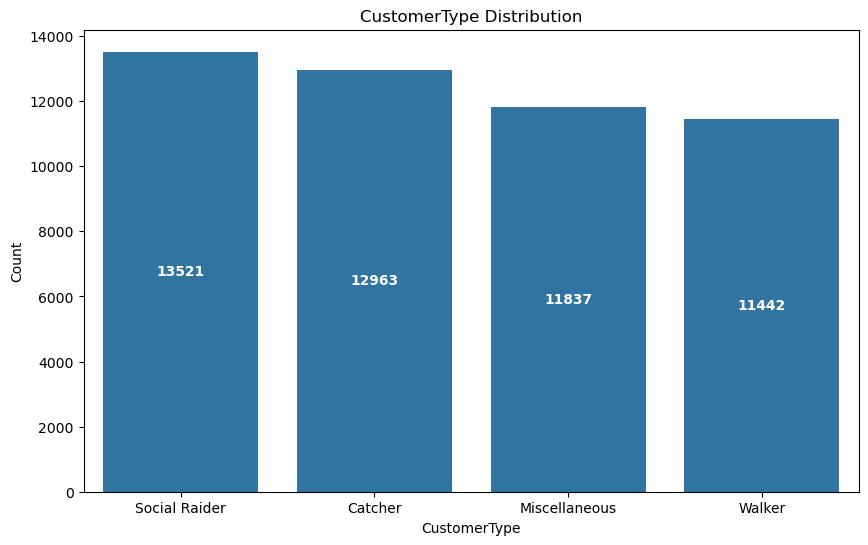

In [29]:
# bar chart of CustomerType Distribution by summer Customer Data
plt.figure(figsize=(10, 6))
barplot = sns.countplot(x='CustomerType', data=basetable['summer'])
plt.title('CustomerType Distribution')
plt.xlabel('CustomerType')
plt.ylabel('Count')
for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                         ha='center', va='center', color='white', fontsize=10, weight='bold')
plt.show()

In [30]:
gender_counts = basetable['summer'].groupby(['CustomerType', 'Gender']).size().unstack()
gender_counts

Gender         Female  Male
CustomerType               
Catcher          5151  7812
Miscellaneous    4735  7102
Social Raider    5404  8117
Walker           4582  6860

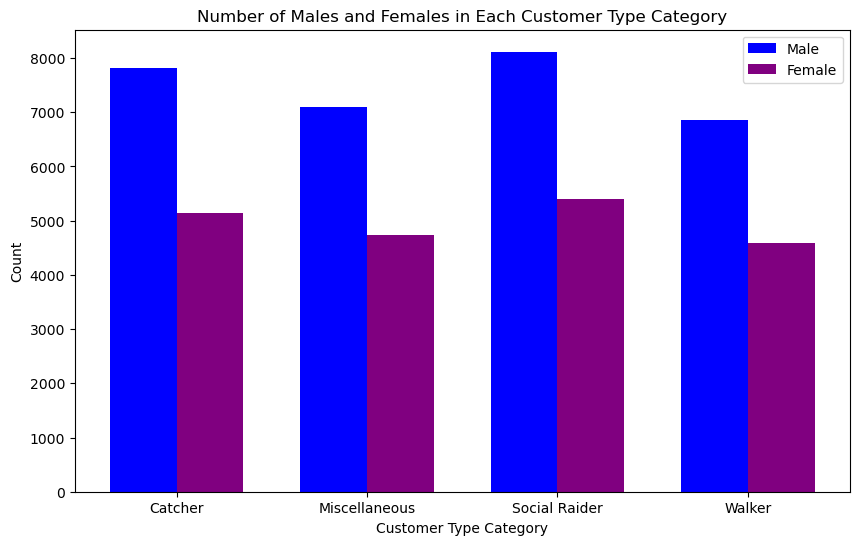

In [31]:
# Customer Type by Gender

bar_width = 0.35  
categories = gender_counts.index
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, gender_counts['Male'], bar_width, label='Male', color='blue')
bar2 = ax.bar(index + bar_width, gender_counts['Female'], bar_width, label='Female', color='purple')

ax.set_xlabel("Customer Type Category")
ax.set_ylabel("Count")
ax.set_title("Number of Males and Females in Each Customer Type Category")
ax.set_xticks(index + bar_width / 2) # ensures that the category labels appear between the two bars, rather than under just one
ax.set_xticklabels(categories)
ax.legend()

plt.show()

In [32]:
# Customer Type by Age

bins= [6, 18, 28, 38, 50, 81] 
labels= ['6-17', '18-27', '28-37', '38-49', '50-80']
basetable['summer']['age_group'] = pd.cut(basetable['summer']['Age'], bins=bins, labels=labels)

In [33]:
analysis['age counts']= basetable['summer'].groupby(['CustomerType', 'age_group'], observed=True).size().unstack()
analysis['age counts']

age_group      6-17  18-27  28-37  38-49  50-80
CustomerType                                   
Catcher        3235   3551   3873   1530    631
Miscellaneous  3079   3272   3438   1335    591
Social Raider  3376   3730   4039   1566    669
Walker         2897   3134   3370   1342    568

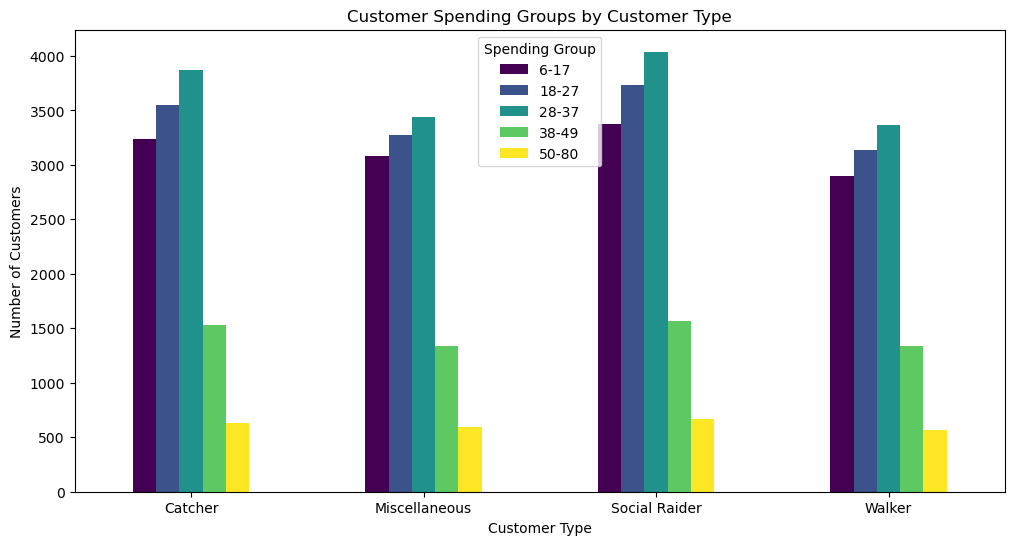

In [34]:
analysis['age counts'].plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.xlabel("Customer Type")
plt.ylabel("Number of Customers")
plt.title("Customer Spending Groups by Customer Type")
plt.legend(title="Spending Group")
plt.xticks(rotation=0)  # Keeps labels readable
plt.show()

## 1.3) Calculate the customer lifetime value for these customers. You can make assumptions for unknown variables (e.g., discount rate, # periods in the future)

In [35]:
CLV['values'] = []

for index, row in CLV['summer'].iterrows():
  row['CLV'] = calc_clv(margin=row['MonetaryValue'], r=analysis['retention for fall'], d=CLV['Discount_rate'], acquisition=CLV['AC'], t=CLV['periods'])
  CLV['values'].append(row['CLV'])

# Delete the index and row variables
del index, row

CLV['summer']['CLV'] = CLV['values']

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2380379148.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
CLV['summer']

CustomerID  MonetaryValue       CLV
0               1           0.00  -1.00000
1               2           0.00  -1.00000
2               3           0.00  -1.00000
3               4           4.99  14.53648
4               5           0.00  -1.00000
...           ...            ...       ...
49758       49996           0.00  -1.00000
49759       49997           0.00  -1.00000
49760       49998           9.98  30.07296
49761       49999           0.00  -1.00000
49762       50000           0.00  -1.00000

[49763 rows x 3 columns]

In [37]:
CLV['summer']['CLV'].describe()

count    49763.000000
mean        11.415286
std         33.278668
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          8.309434
max        662.118149
Name: CLV, dtype: float64

In [38]:
round(CLV['summer']['CLV'].sum(),2)

568058.87

# 2) LifeCycle Grids

## Customer Type, Spending Category, Registration Cohorts, Spending vs no spending

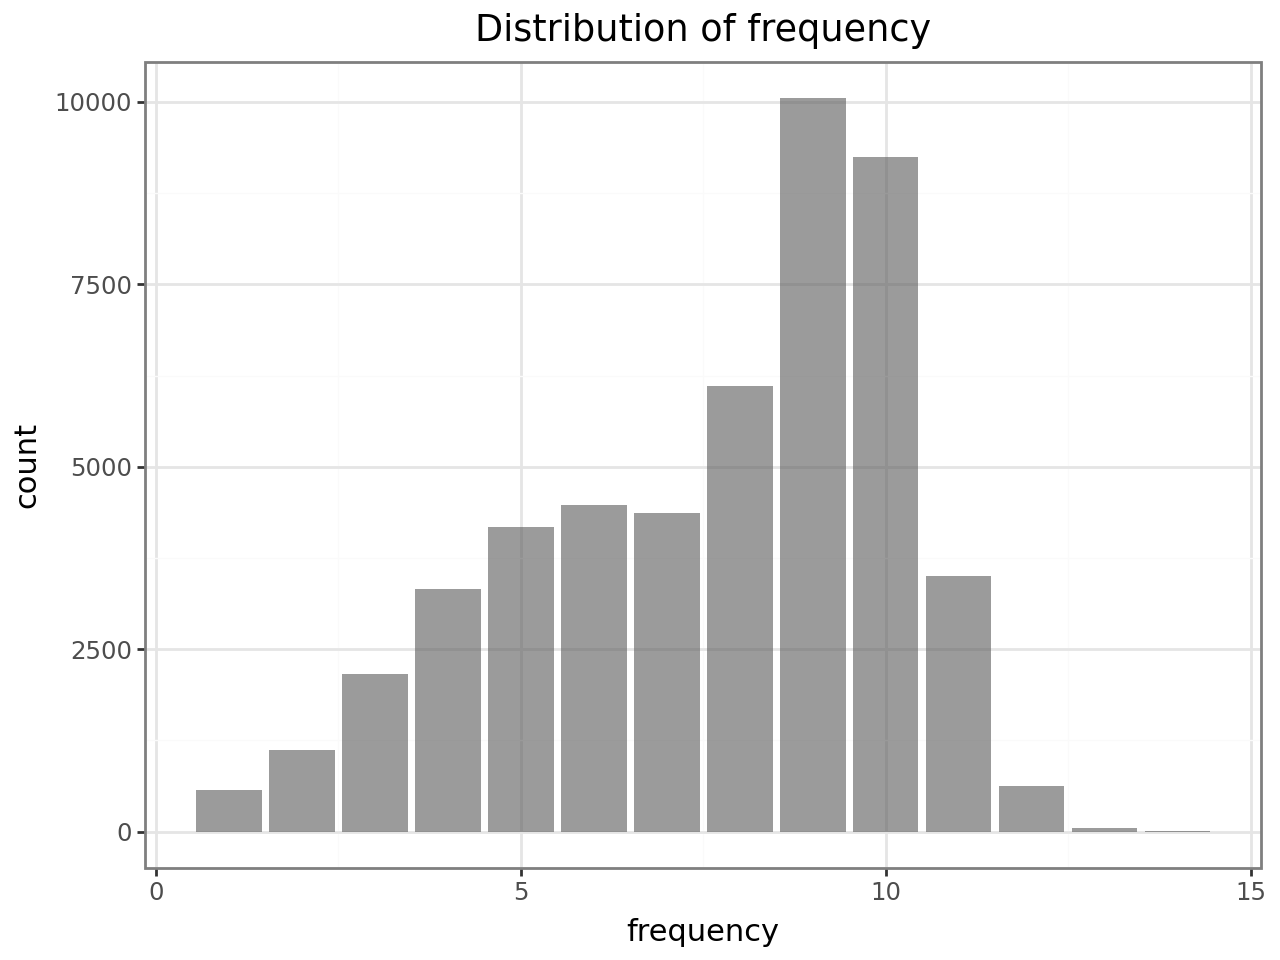

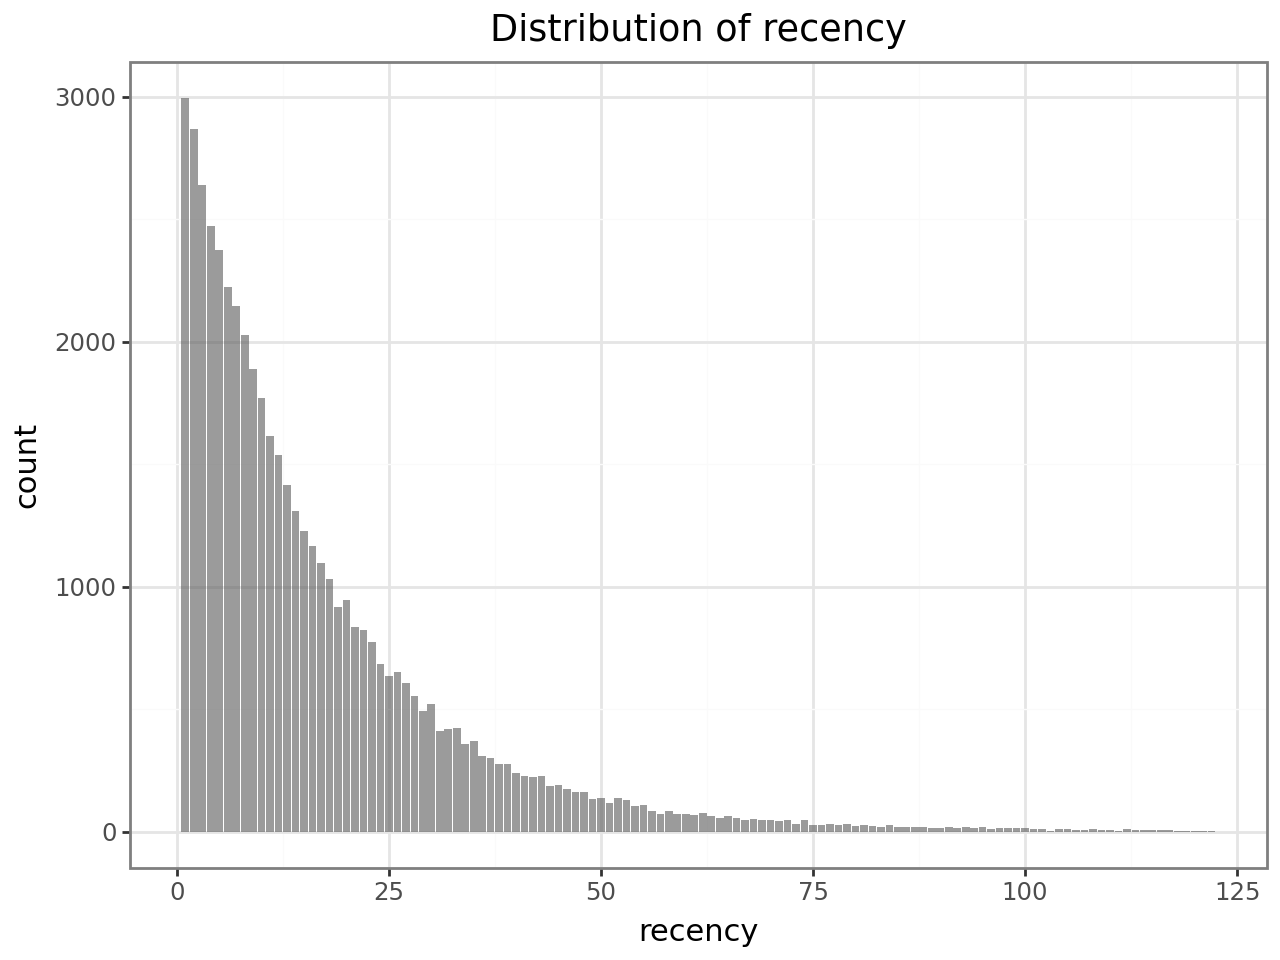

In [39]:
# Some plots to visualize frequency and recency
histograms = {
    'histfreq' : (ggplot(basetable['summer'], aes(x='frequency')) +
      theme_bw() +
      scale_x_continuous() +
      geom_bar(alpha=0.6) +
      ggtitle("Distribution of frequency")),

    'histrec' : (ggplot(basetable['summer'], aes(x='recency')) +
      theme_bw() +
      geom_bar(alpha=0.6) +
      ggtitle("Distribution of recency"))
    }

histograms['histfreq'].show()
histograms['histrec'].show()

In [40]:
# Create a new dictionary to store the basetable summer along with new segmented columns that we will use for the grids
segmented = {
    'summer_custsegm' : basetable['summer'].assign(
        segmfreq=lambda x: pd.cut(x['frequency'],
                                                  bins=[0,3,5,7,9,10,99],
                                                  labels=["1", "3", "5","7",'9','>10']),
        segmrec=lambda x: pd.cut(x['recency'],
                                                  bins=[0,4,9,15,30,50,150],
                                                  labels=["0-4 days", "5-9 days", "10-15 days","16-30 days","31-50 days",">50 days"]),
        segmage=lambda x: pd.cut(x['Age'],
                                  bins= [6, 18, 28, 38, 50, 81],
                                  labels= ['6-17', '18-27', '28-37', '38-49', '50-80']),
        spending_cat= lambda x: pd.cut(x['MonetaryValue'],
                                  bins= [-1, 10, 50, 100, 200, float('inf')],
                                  labels= ['VL', 'L','M', 'H', 'VH']),
        cohort=lambda x: x['Registrationdate'].dt.year,
        spending=lambda x: np.where(x['MonetaryValue'] == 0, 0, 1))
    }
segmented['summer_custsegm']['CLV'] = CLV['values']
#convert to factor and reverse the order
segmented['summer_custsegm']['segmfreq']=pd.Categorical(segmented['summer_custsegm']['segmfreq'], categories=['>10','9','7','5','3',"1"])
segmented['summer_custsegm']['segmrec']=pd.Categorical(segmented['summer_custsegm']['segmrec'], categories=[">50 days","31-50 days","16-30 days", "10-15 days", "5-9 days","0-4 days"])
segmented['summer_custsegm']['Income']=pd.Categorical(segmented['summer_custsegm']['Income'], categories=["Low","Medium","High"])

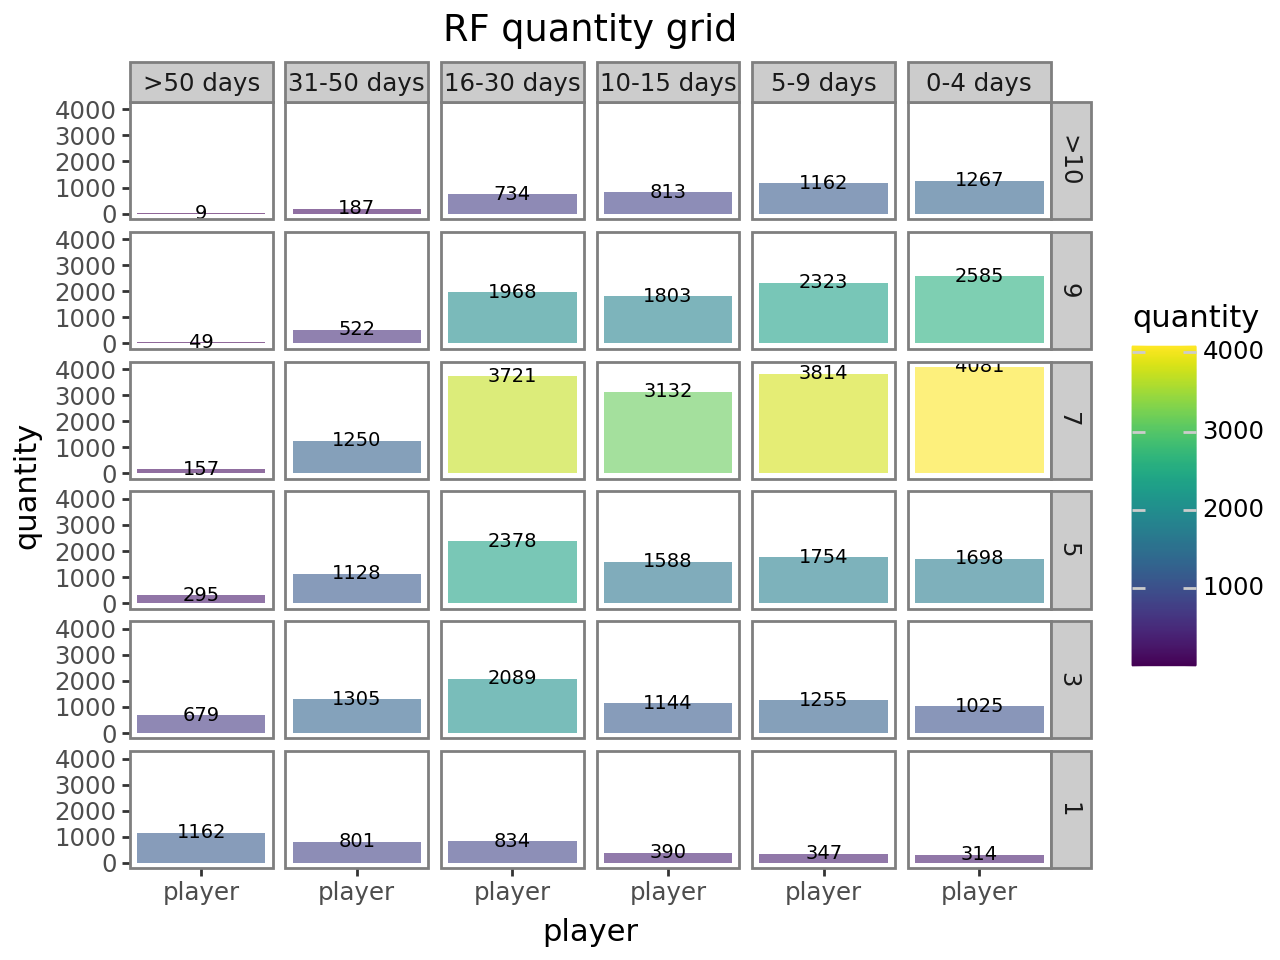

In [119]:
#RF quantity grid
Grids_data = {
    'lcg' : segmented['summer_custsegm'].groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(
        quantity=('CustomerID','count'),
        monetaryvalue=('MonetaryValue','sum'),
        meanmonetaryvalue=('MonetaryValue','mean'),
        clv=('CLV','sum'))
    }

Grids_data['lcg']['player']='player'

Grids= {"RF quantity grid" : (ggplot(Grids_data['lcg'], aes(x='player', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='quantity', label='quantity'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RF quantity grid"))
        }
Grids['RF quantity grid'].show()

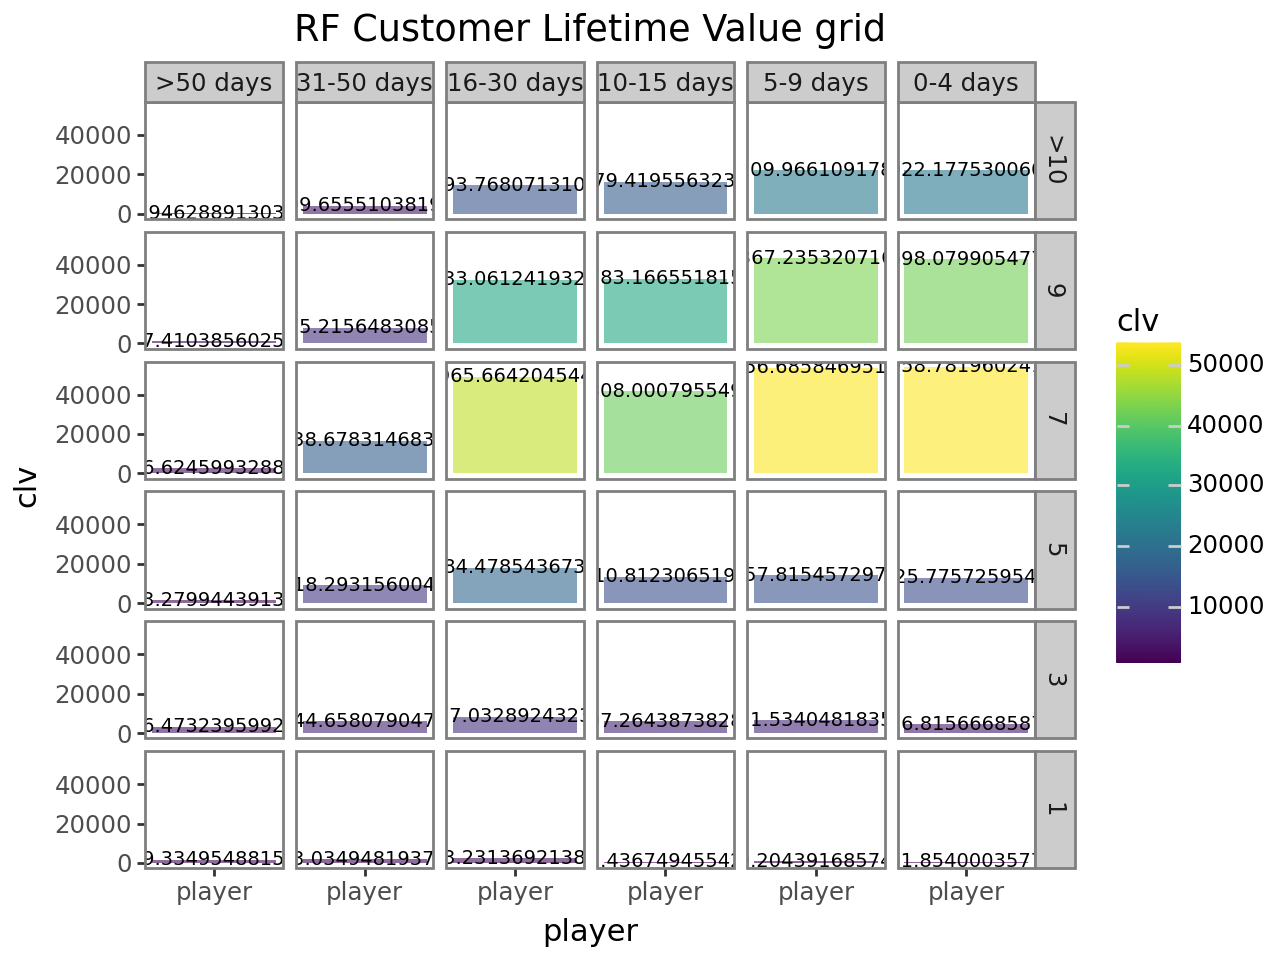

In [120]:
Grids= {"RF Customer Lifetime Value grid" : (ggplot(Grids_data['lcg'], aes(x='player', y='clv',fill='clv'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='clv', label='clv'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RF Customer Lifetime Value grid"))
        }
Grids['RF Customer Lifetime Value grid'].show()

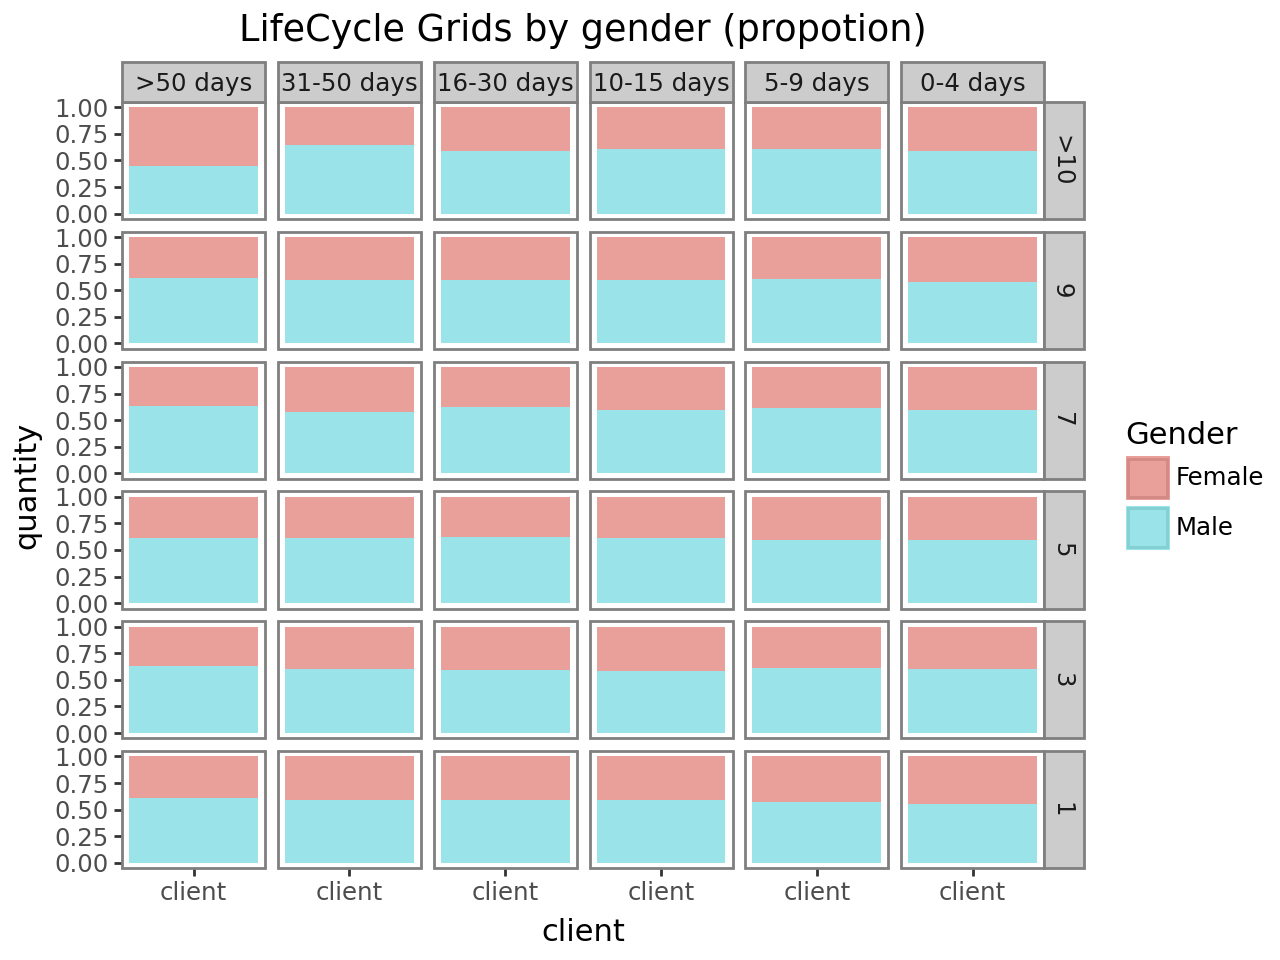

In [42]:
# RF by Gender
Grids_data['lcgsub']=segmented['summer_custsegm'].groupby(
    ['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(
        quantity=('CustomerID','count'),
        monetaryvalue=('MonetaryValue','sum'))
Grids_data['lcgsub']['client']='client'

Grids["LifeCycle Grids by gender (propotion)"]=(
    ggplot(Grids_data['lcgsub'], aes(x='client', y='quantity',fill='Gender'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity',position='fill', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by gender (propotion)"))

Grids["LifeCycle Grids by gender (propotion)"].show()

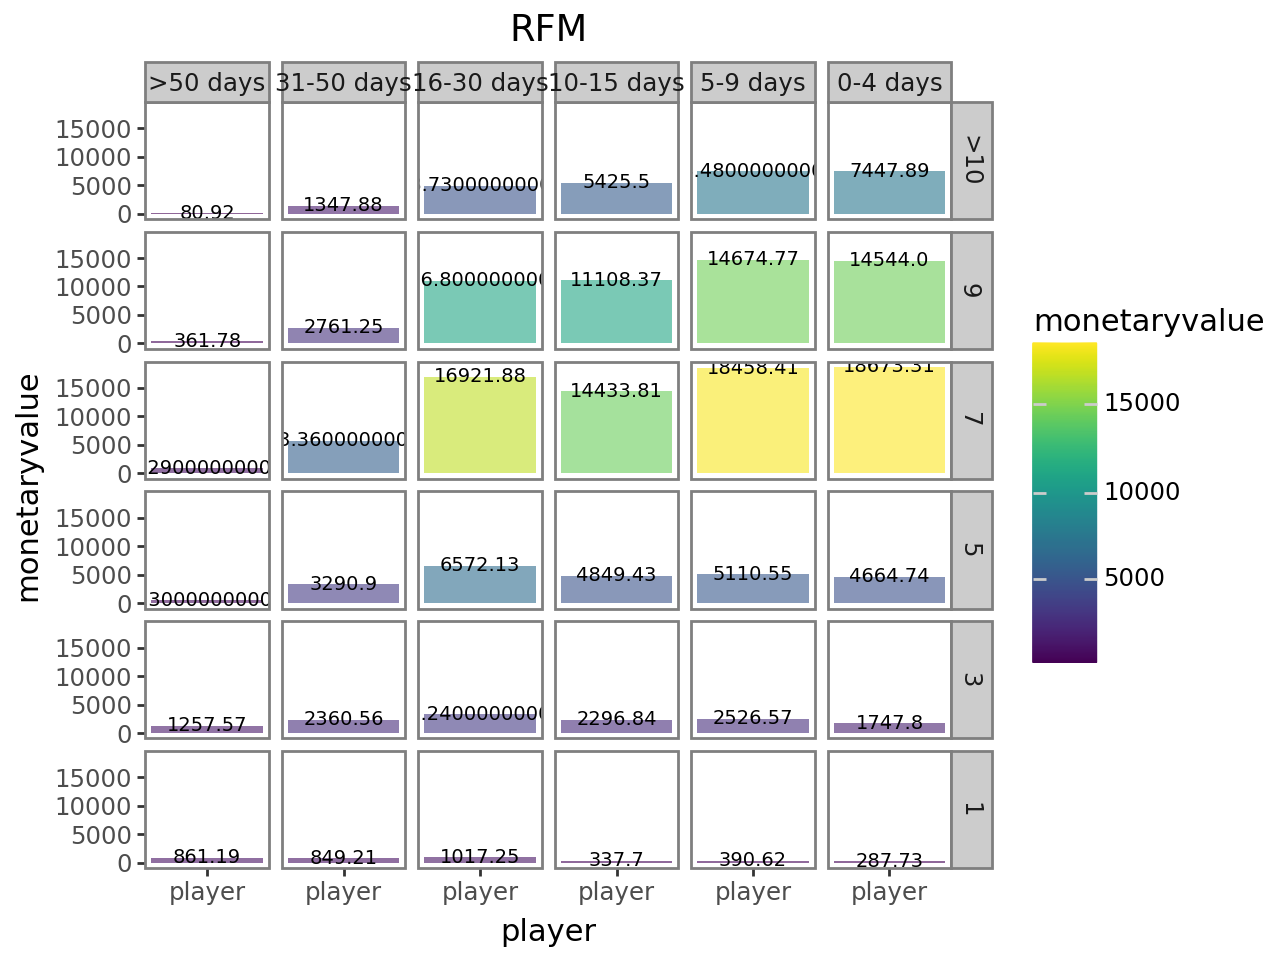

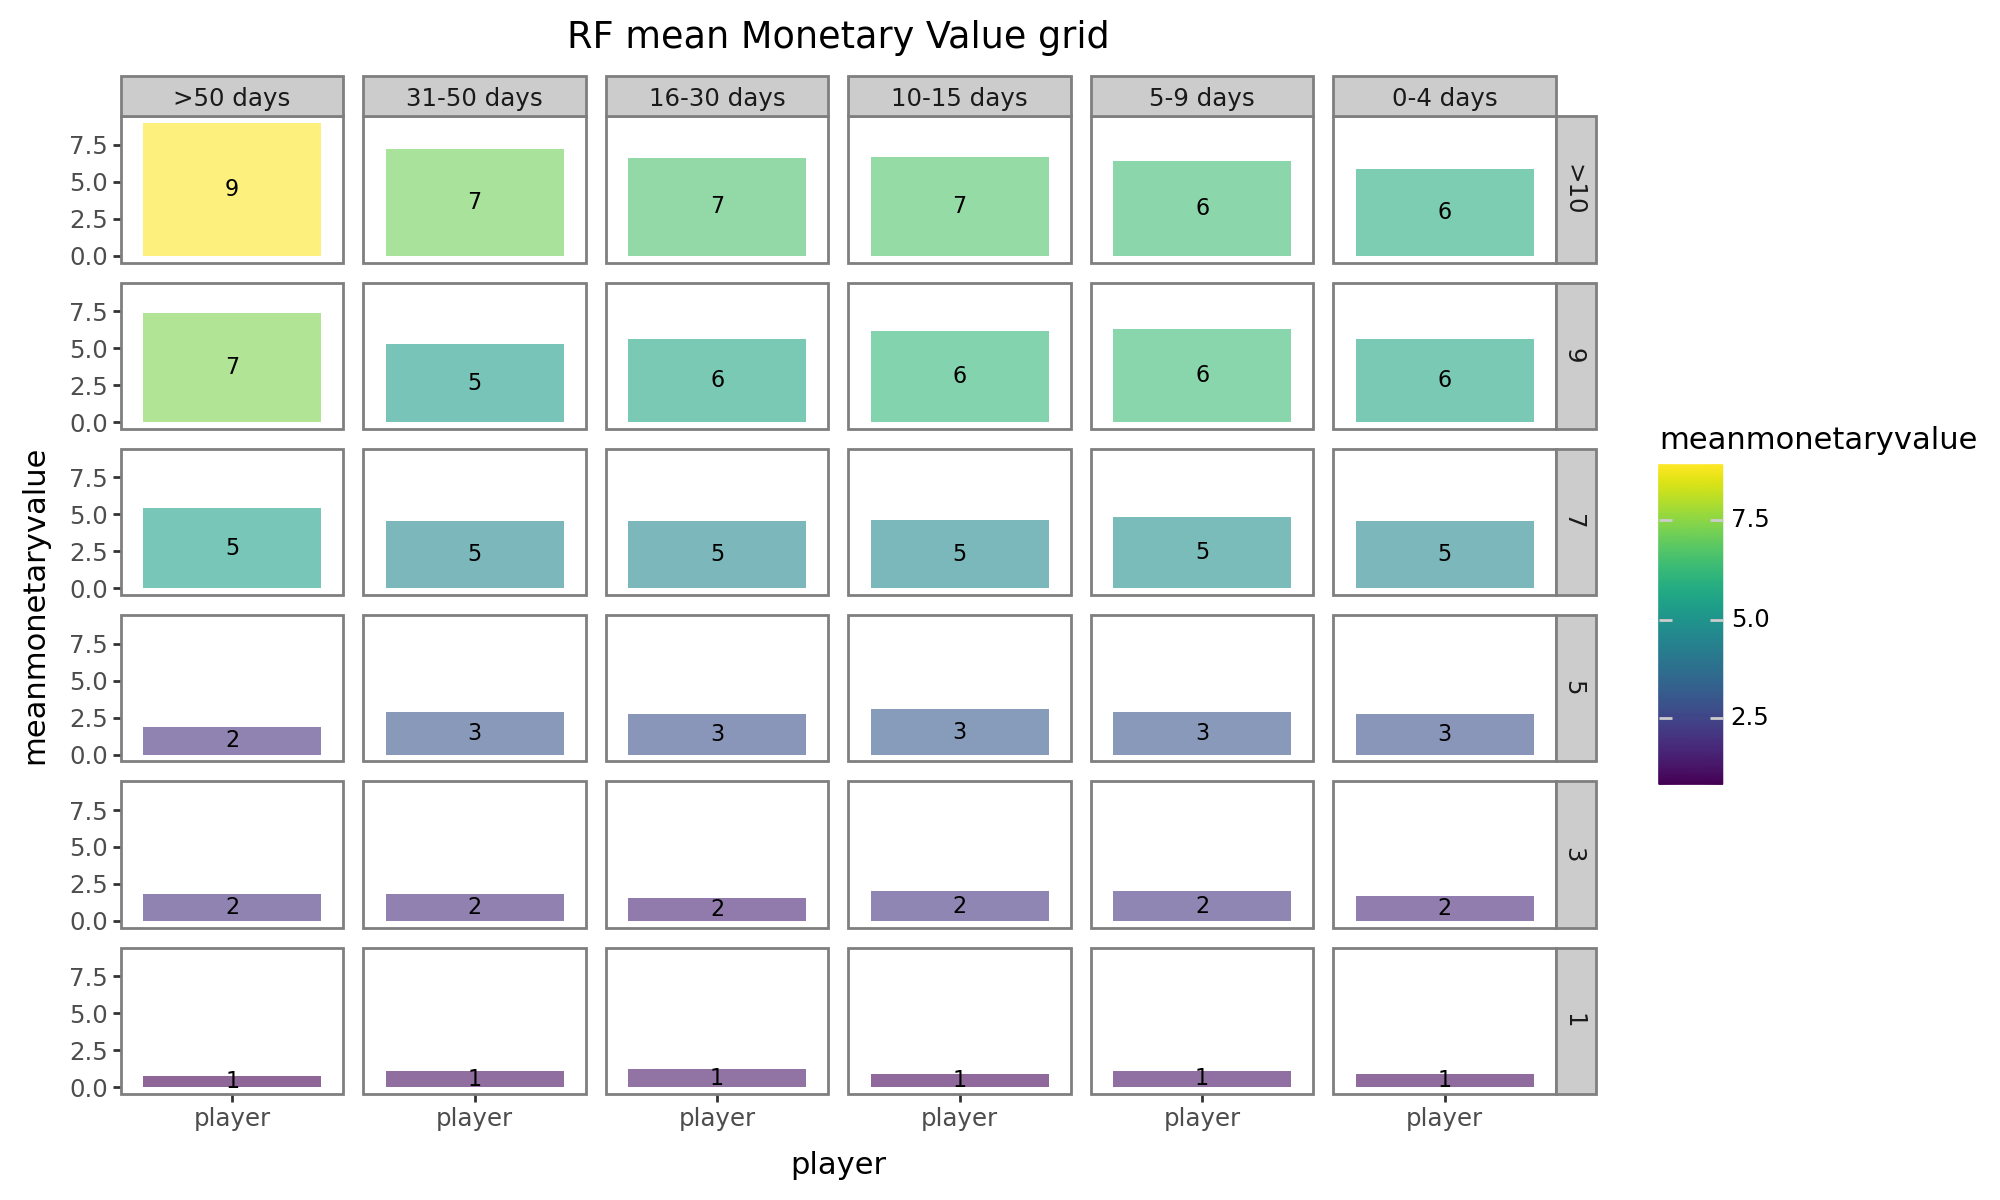

In [43]:
# RFM
Grids["RFM grid"] = (
    ggplot(Grids_data['lcg'], aes(x='player', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='monetaryvalue', label='monetaryvalue'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RFM"))

Grids['RFM grid'].show()

Grids['mean RFM grid'] = (ggplot(Grids_data['lcg'], aes(x='player', y='meanmonetaryvalue', fill='meanmonetaryvalue')) +
         theme_bw() +  # Apply a clean black-and-white theme
         theme(panel_grid=element_blank(),  # Remove the background grid for clarity
               figure_size=(10, 6),  # Set the figure size
               axis_text_x=element_text(rotation=0)) +  # Ensure x-axis labels are horizontal
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Create bars with some transparency and a specified width
         geom_text(aes(label='meanmonetaryvalue'),  # Add text annotations based on the monetary value
                   position=position_stack(vjust=0.5),  # Center the text within each bar
                   format_string="{:.0f}",  # Optional: Format the numbers (remove decimals)
                   size=8,  # Set text size
                   color="black") +  # Choose a text color that stands out from the bar color
         facet_grid('segmfreq ~ segmrec') +  # Create facets based on frequency and recency
         ggtitle('RF mean Monetary Value grid'))  # Set the title of the plot

Grids['mean RFM grid'].show()

In [44]:
# to save grids return these lines to code instead of comment
#for grid in Grids:
    #Grids[grid].save(filename=grid, height=15, width=15, units = 'in', dpi= 1000)

In [45]:
segmented['summer_custsegm']['frequency'].describe()

segmented['summer_custsegm'].to_csv('basetable_summer.csv')

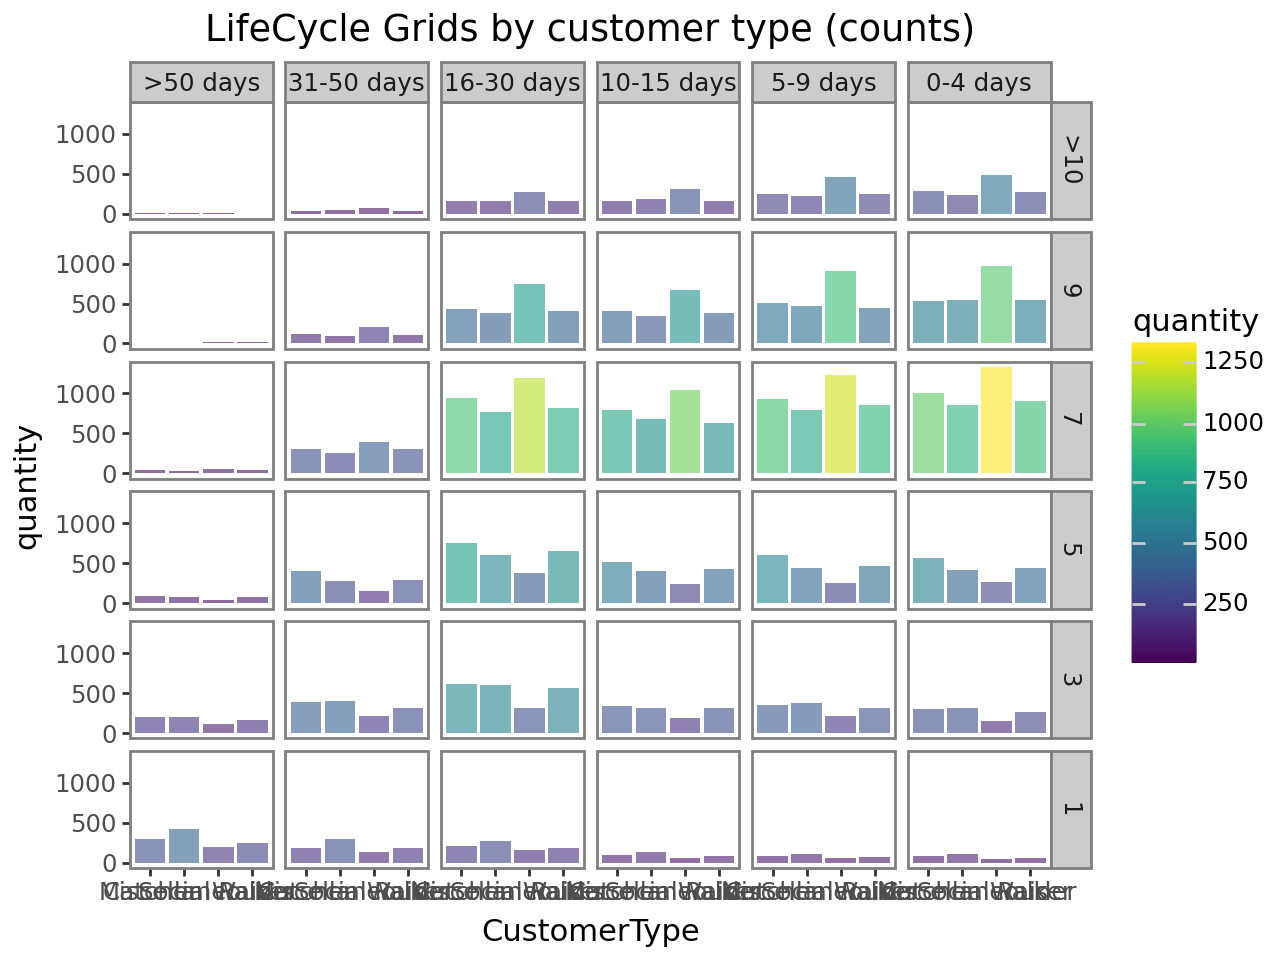

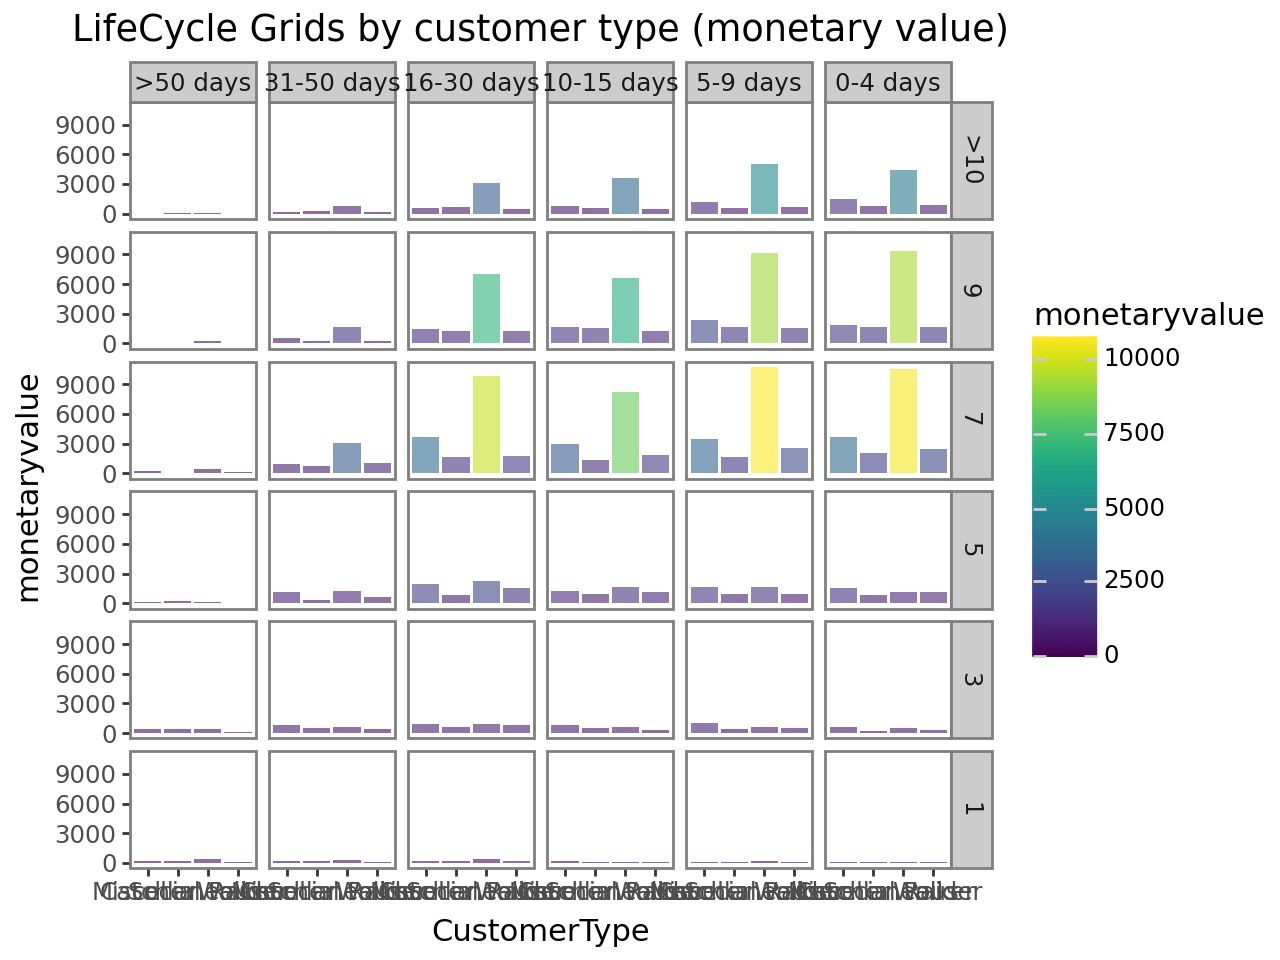

In [46]:
#RF customer type grid
Grids_data ['lcg_age'] = segmented['summer_custsegm'].groupby(['segmfreq','segmrec','segmage'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))

Grids_data['lcg_custtype'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'CustomerType'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'),
    monetaryvalue=('MonetaryValue','sum'))

Grids["LifeCycle Grids by customer type (counts)"]=(
    ggplot(Grids_data['lcg_custtype'], aes(x='CustomerType', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by customer type (counts)"))

Grids["LifeCycle Grids by customer type (counts)"].show()

Grids["LifeCycle Grids by customer type (monetary value)"]=(
    ggplot(Grids_data['lcg_custtype'], aes(x='CustomerType', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by customer type (monetary value)"))

Grids["LifeCycle Grids by customer type (monetary value)"].show()

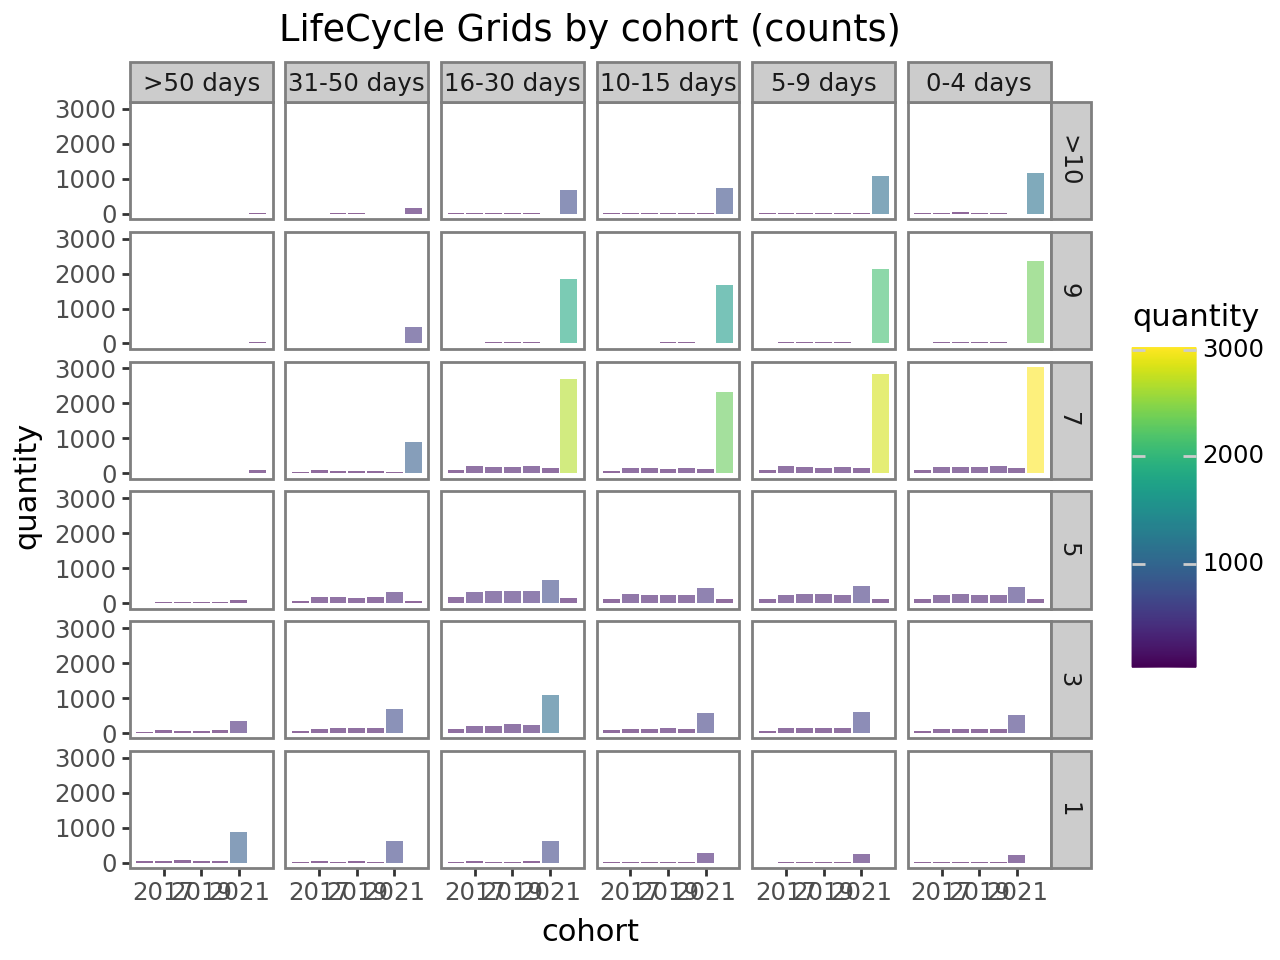

In [47]:
# RF by cohorts
Grids_data['lcg_cohorts'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'cohort'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'),
    monetaryvalue=('MonetaryValue','sum'))

Grids["LifeCycle Grids by cohort (counts)"]=(
    ggplot(Grids_data['lcg_cohorts'], aes(x='cohort', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by cohort (counts)"))

Grids["LifeCycle Grids by cohort (counts)"].show()

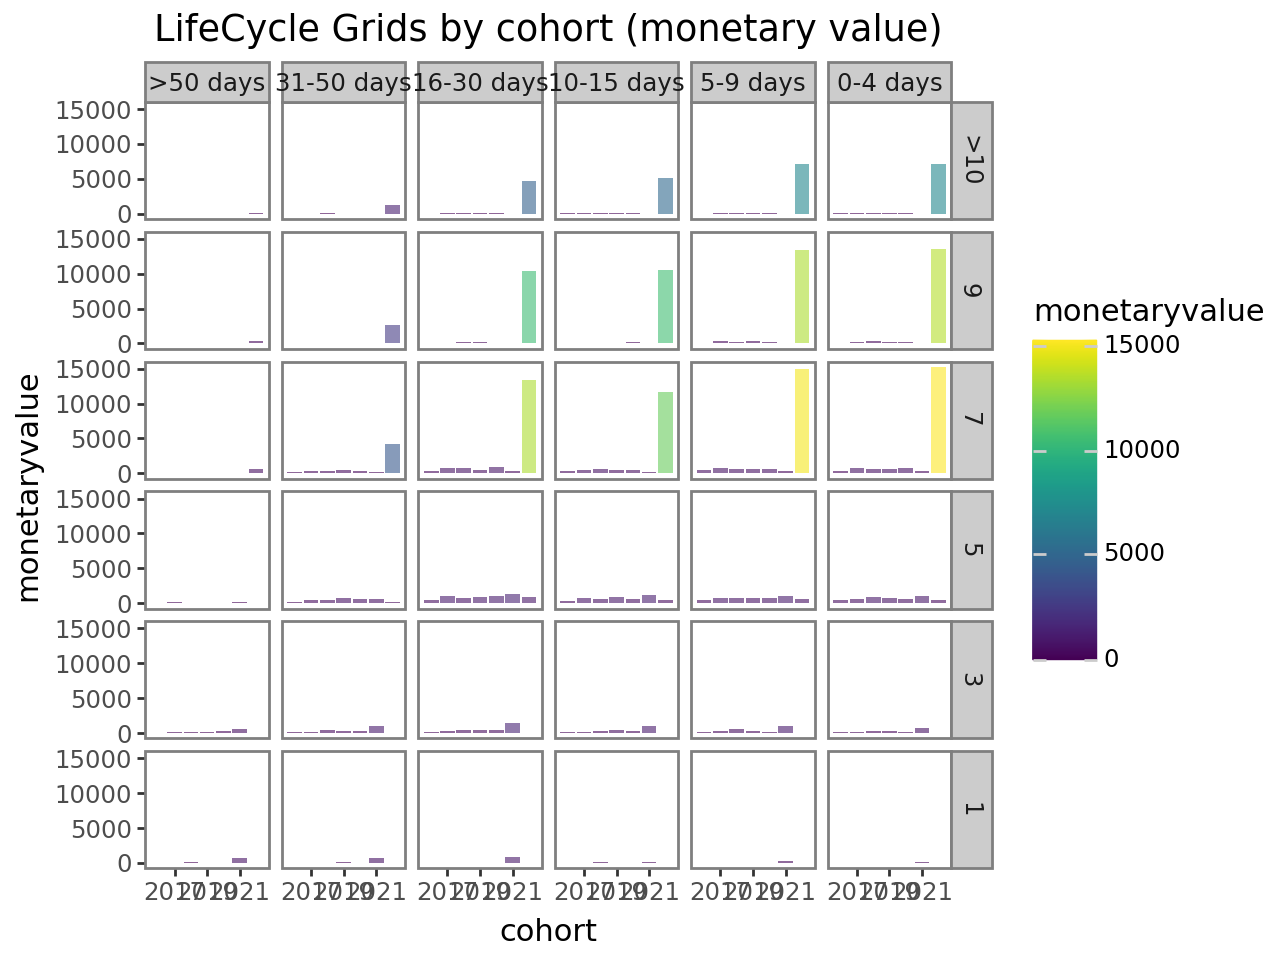

In [48]:
Grids["LifeCycle Grids by cohort (monetary value)"]=(
    ggplot(Grids_data['lcg_cohorts'], aes(x='cohort', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by cohort (monetary value)"))

Grids["LifeCycle Grids by cohort (monetary value)"].show()

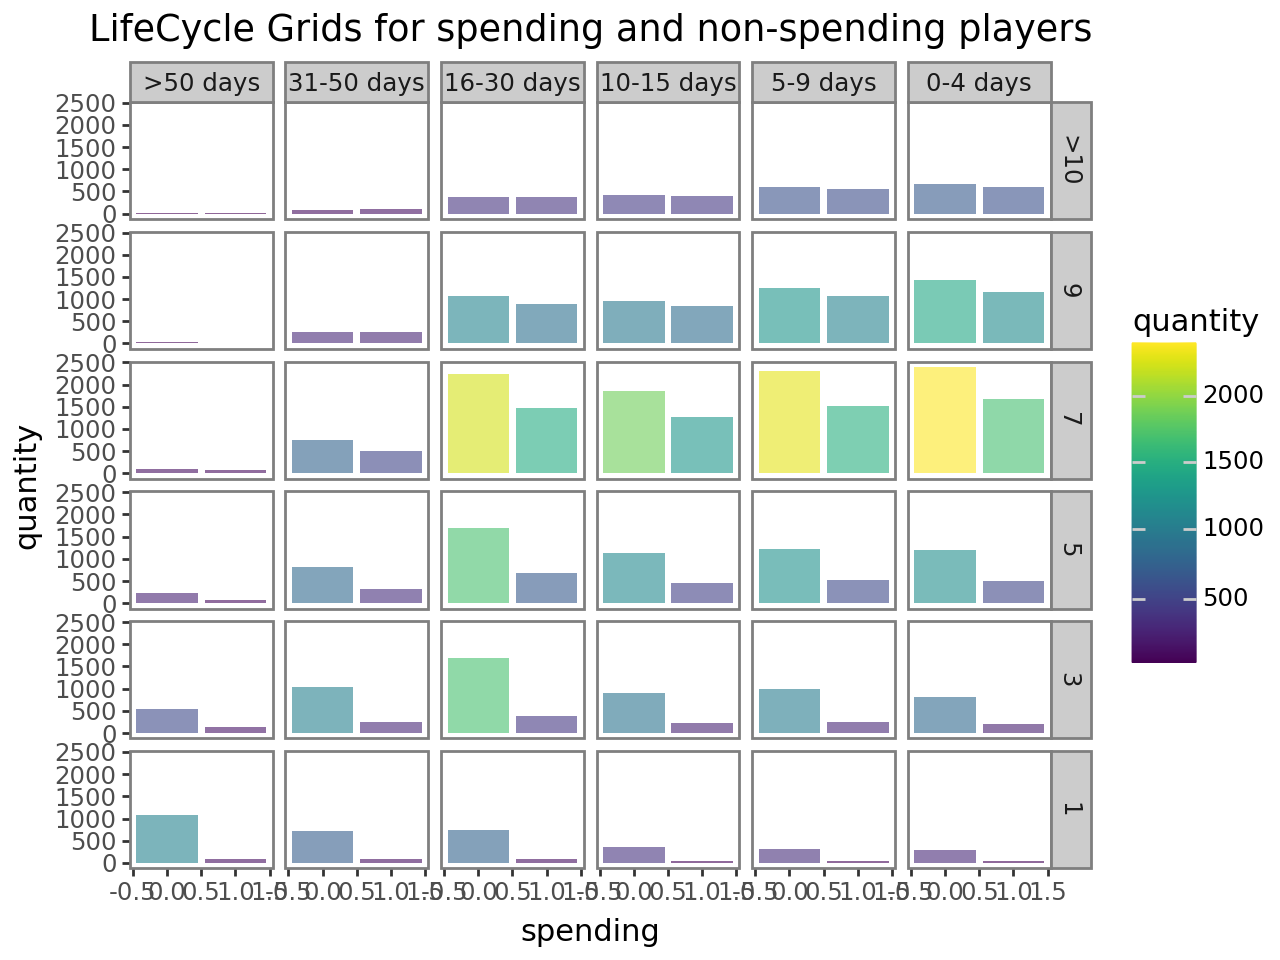

In [49]:
# RF by spending/no spending
Grids_data['lcg_spending'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'spending'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'))

Grids["LifeCycle Grids for spending and non-spending players"]=(
    ggplot(Grids_data['lcg_spending'], aes(x='spending', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids for spending and non-spending players"))

Grids["LifeCycle Grids for spending and non-spending players"].show()

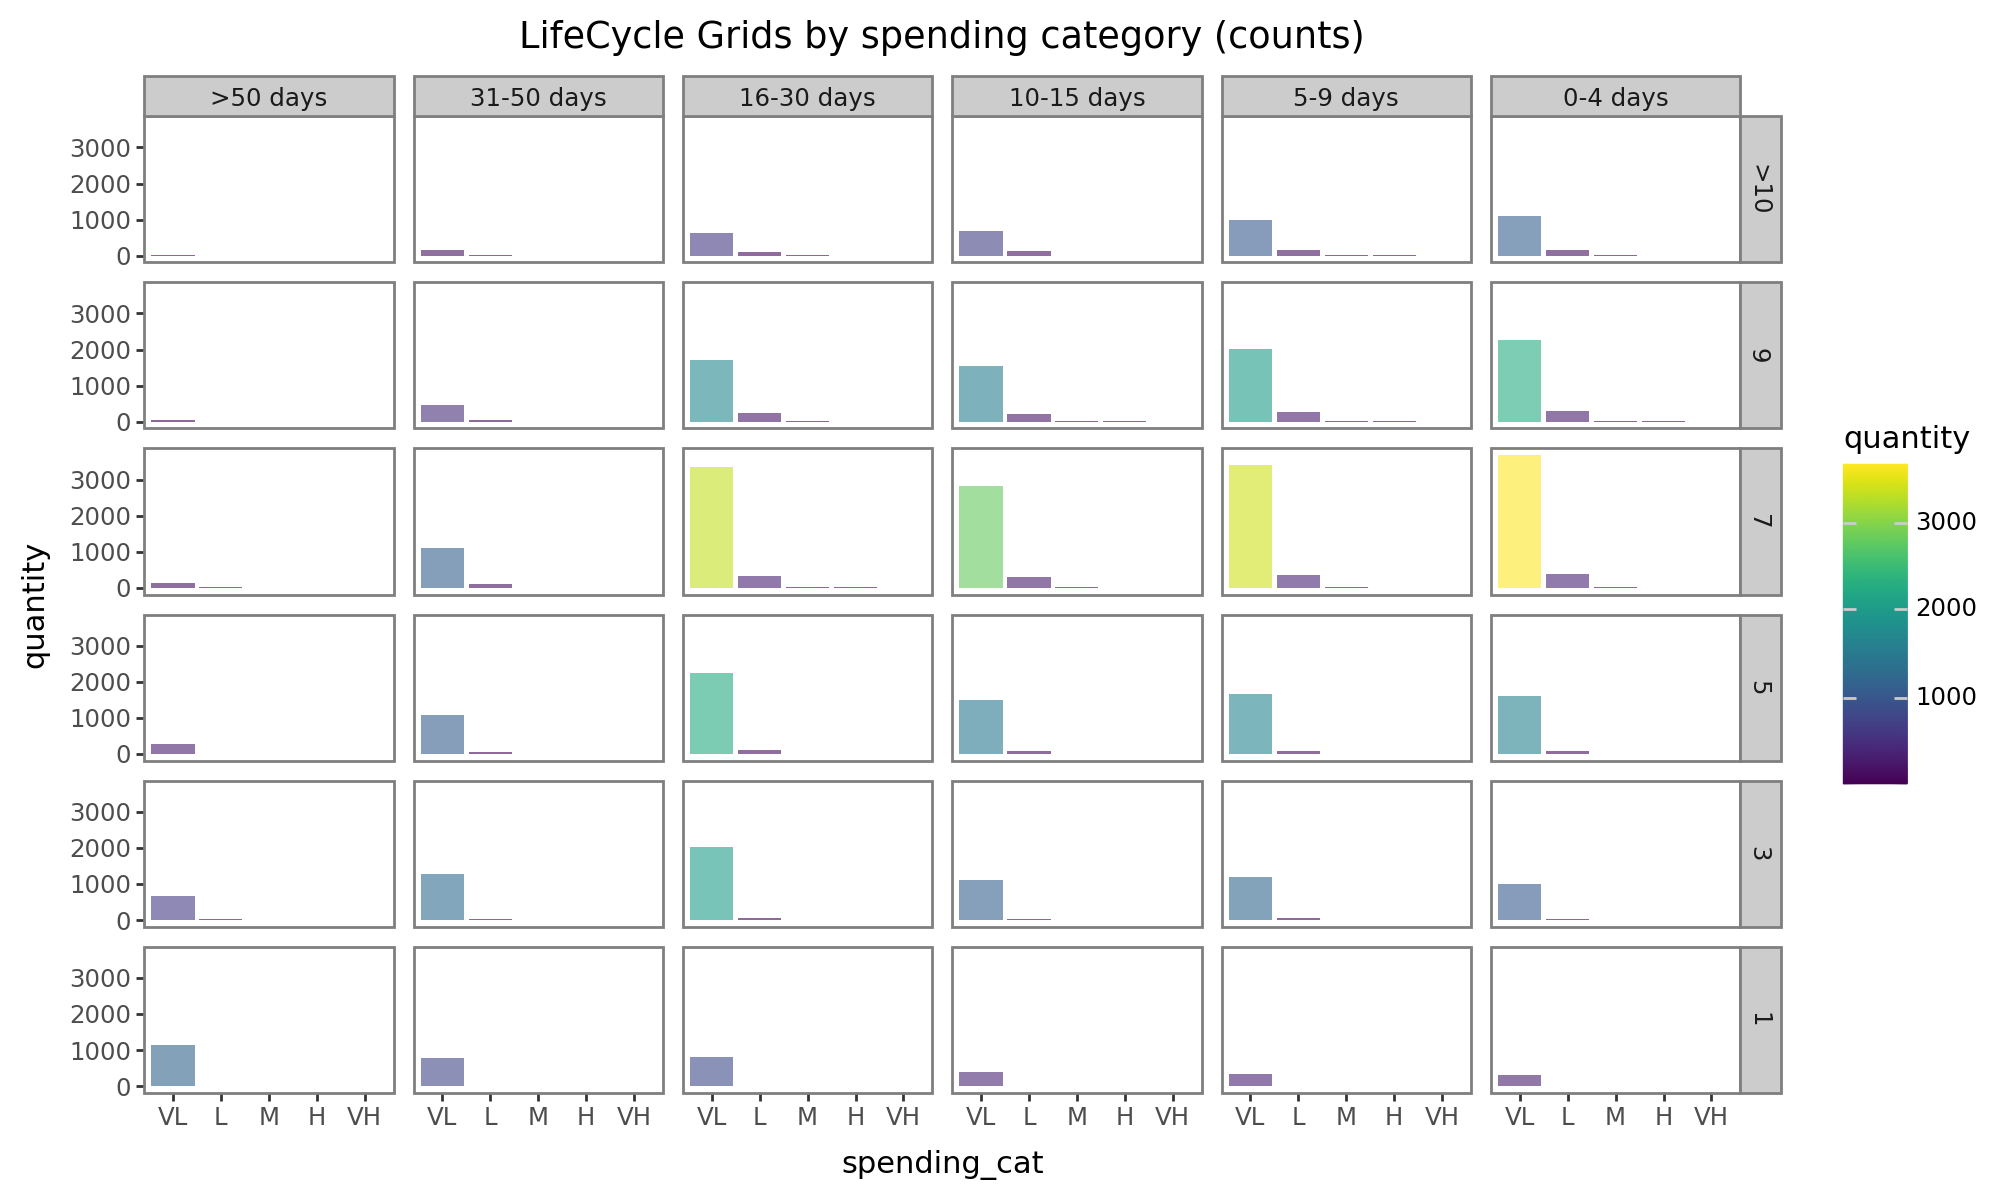

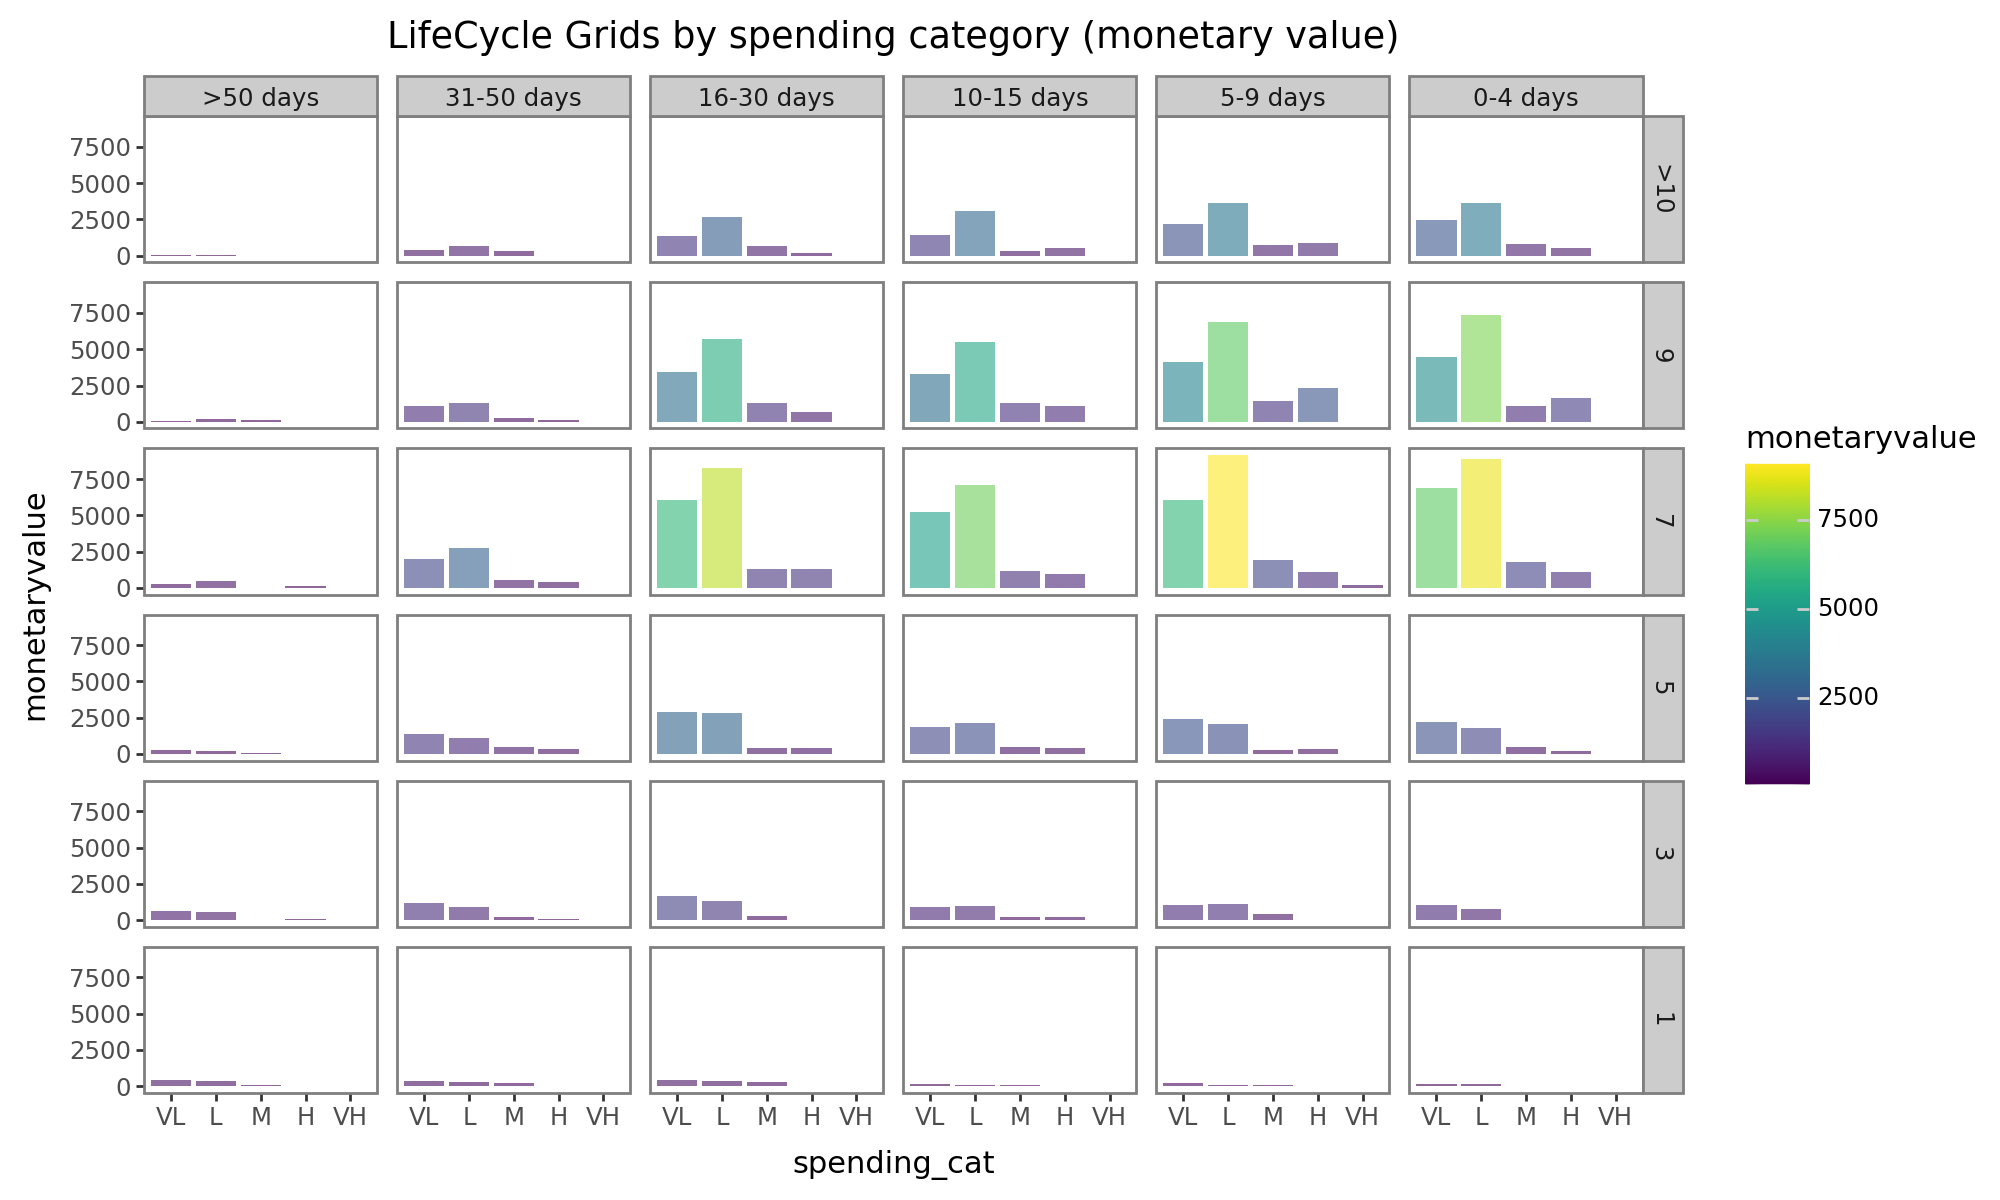

In [50]:
# RF by spending category
Grids_data['lcg_spendingcat'] = segmented['summer_custsegm'].groupby(['segmfreq', 'segmrec', 'spending_cat'], observed=True, as_index=False).agg(
    quantity=('CustomerID', 'count'),
    monetaryvalue=('MonetaryValue','sum'),
    clv=('CLV','sum'))

Grids["LifeCycle Grids by spending category (counts)"]=(
    ggplot(Grids_data['lcg_spendingcat'], aes(x='spending_cat', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank(),
        figure_size=(10, 6))+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by spending category (counts)"))

Grids["LifeCycle Grids by spending category (counts)"].show()

Grids["LifeCycle Grids by spending category (monetary value)"]=(
    ggplot(Grids_data['lcg_spendingcat'], aes(x='spending_cat', y='monetaryvalue',fill='monetaryvalue'))+#xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank(),
        figure_size=(10, 6))+#removes colored box behind bar chart
  geom_bar(stat='identity', alpha=0.6) +  #position=fill will force ggplot to use the whole grid, if you want to use geom_text make sure the location is between 0 and 1
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
 ggtitle("LifeCycle Grids by spending category (monetary value)"))

Grids["LifeCycle Grids by spending category (monetary value)"].show()

# how was the fall bonus assigned? Not RFM
# basic RFM, monetary value for customer type, monetary value by spending category, fall bonus by customer type, age group by monetary value (and mean), income group by CLV, look at fall bonus by customer type,

## Gender, Age Group, Income, Fall bonus, Total Monetary Value

In [51]:
Grids_data['lcgg']= segmented['summer_custsegm'].groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'),
                                                                                                                           monetary_value=('MonetaryValue', 'sum'),
                                                                                                                           mean_monetary_value=('MonetaryValue', 'sum'),
                                                                                                                           clv=('CLV','sum'))
Grids_data['lcgg']['player']='player'
Grids_data['lcgg']

Gender segmfreq     segmrec  quantity  monetary_value  \
0   Female      >10    >50 days         5           65.94   
1   Female      >10  31-50 days        66          442.66   
2   Female      >10  16-30 days       304         1771.04   
3   Female      >10  10-15 days       318         2067.13   
4   Female      >10    5-9 days       456         3210.57   
..     ...      ...         ...       ...             ...   
67    Male        1  31-50 days       473          699.49   
68    Male        1  16-30 days       496          433.55   
69    Male        1  10-15 days       229          242.80   
70    Male        1    5-9 days       198          262.76   
71    Male        1    0-4 days       173          177.85   

    mean_monetary_value          clv  player  
0                 65.94   200.305713  player  
1                442.66  1312.232134  player  
2               1771.04  5210.173944  player  
3               2067.13  6118.056997  player  
4               3210.57  9540.183846  player  
..                  ...          ...     ...  
67               699.49  1704.878270  player  
68               433.55   853.867938  player  
69               242.80   526.963408  player  
70               262.76   620.109329  player  
71               177.85   380.740083  player  

[72 rows x 8 columns]

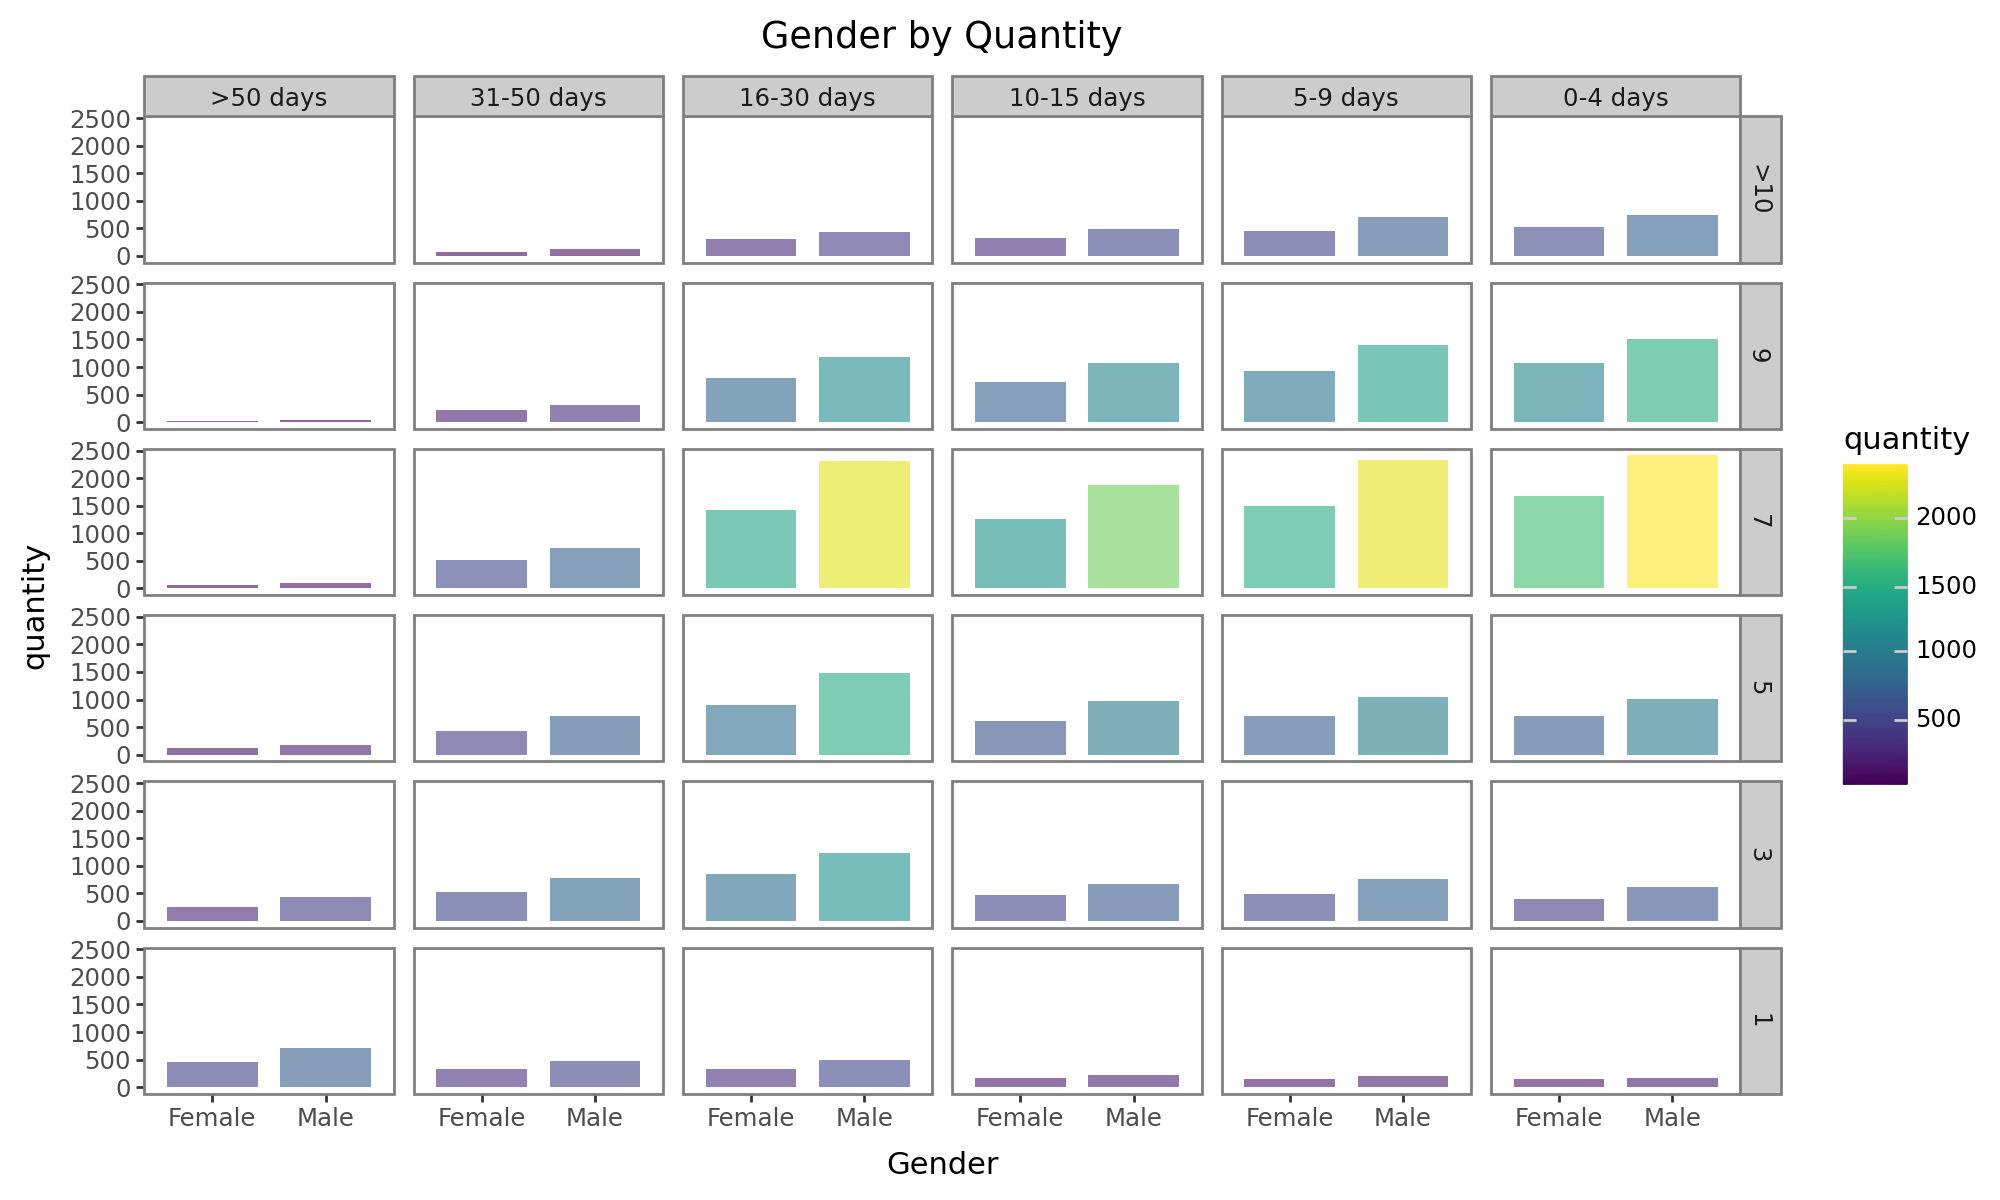

In [52]:
Grids['Gender by Quantity'] = (ggplot(Grids_data['lcgg'], aes(x='Gender', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec', space="free_x") +  # Adjust space based on content
         scale_x_discrete(breaks=['Male', 'Female'], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by Quantity"))

Grids['Gender by Quantity'].show()

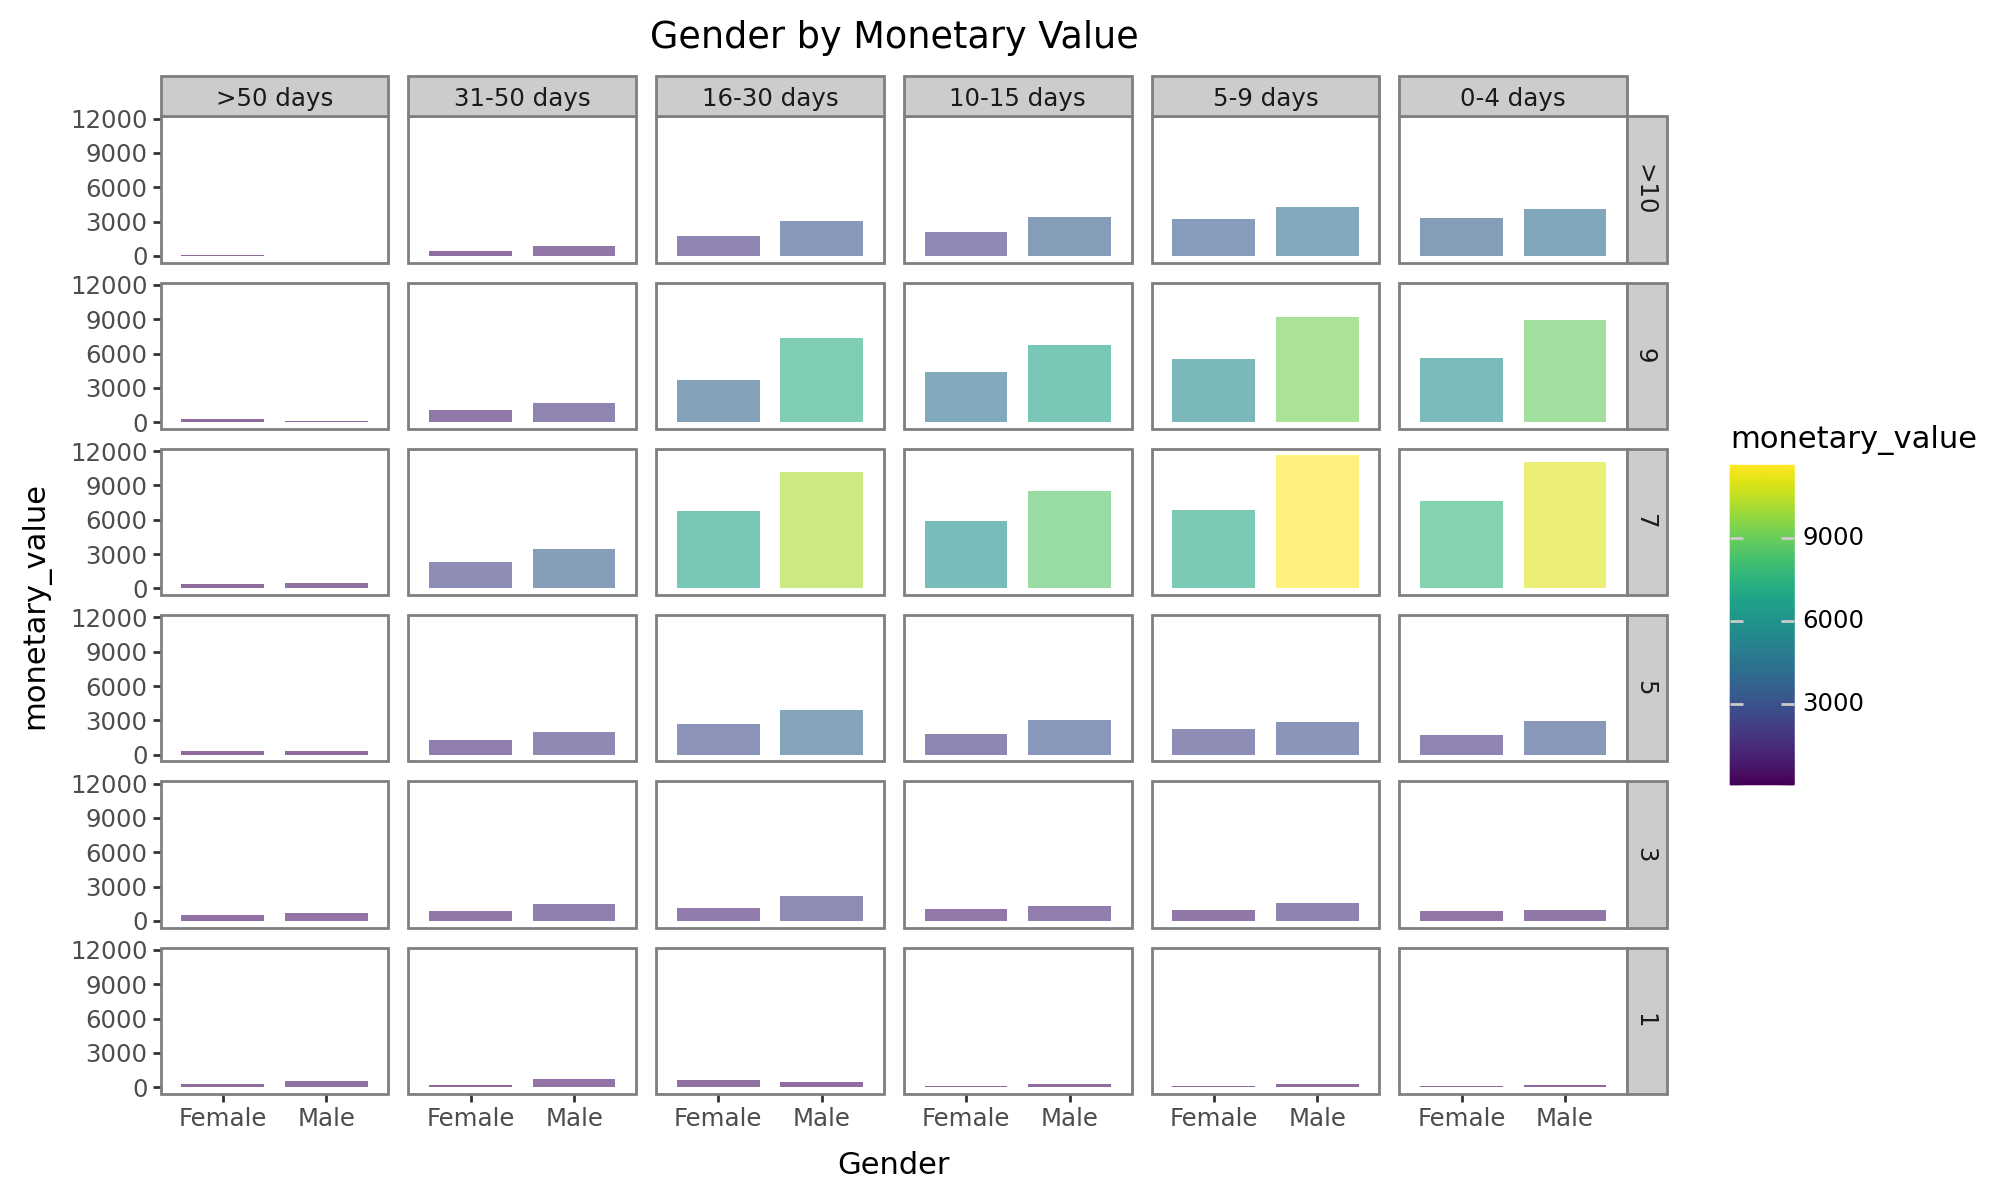

In [53]:
# Gender with Monetary Value

Grids['Gender by Monetary Value'] = (ggplot(Grids_data['lcgg'], aes(x='Gender', y='monetary_value', fill='monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=['Male', 'Female'], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by Monetary Value"))

Grids['Gender by Monetary Value'].show()

For each grid that contains the monetary value we will plot both the sum and the mean to obtain more information regarding spending habbits

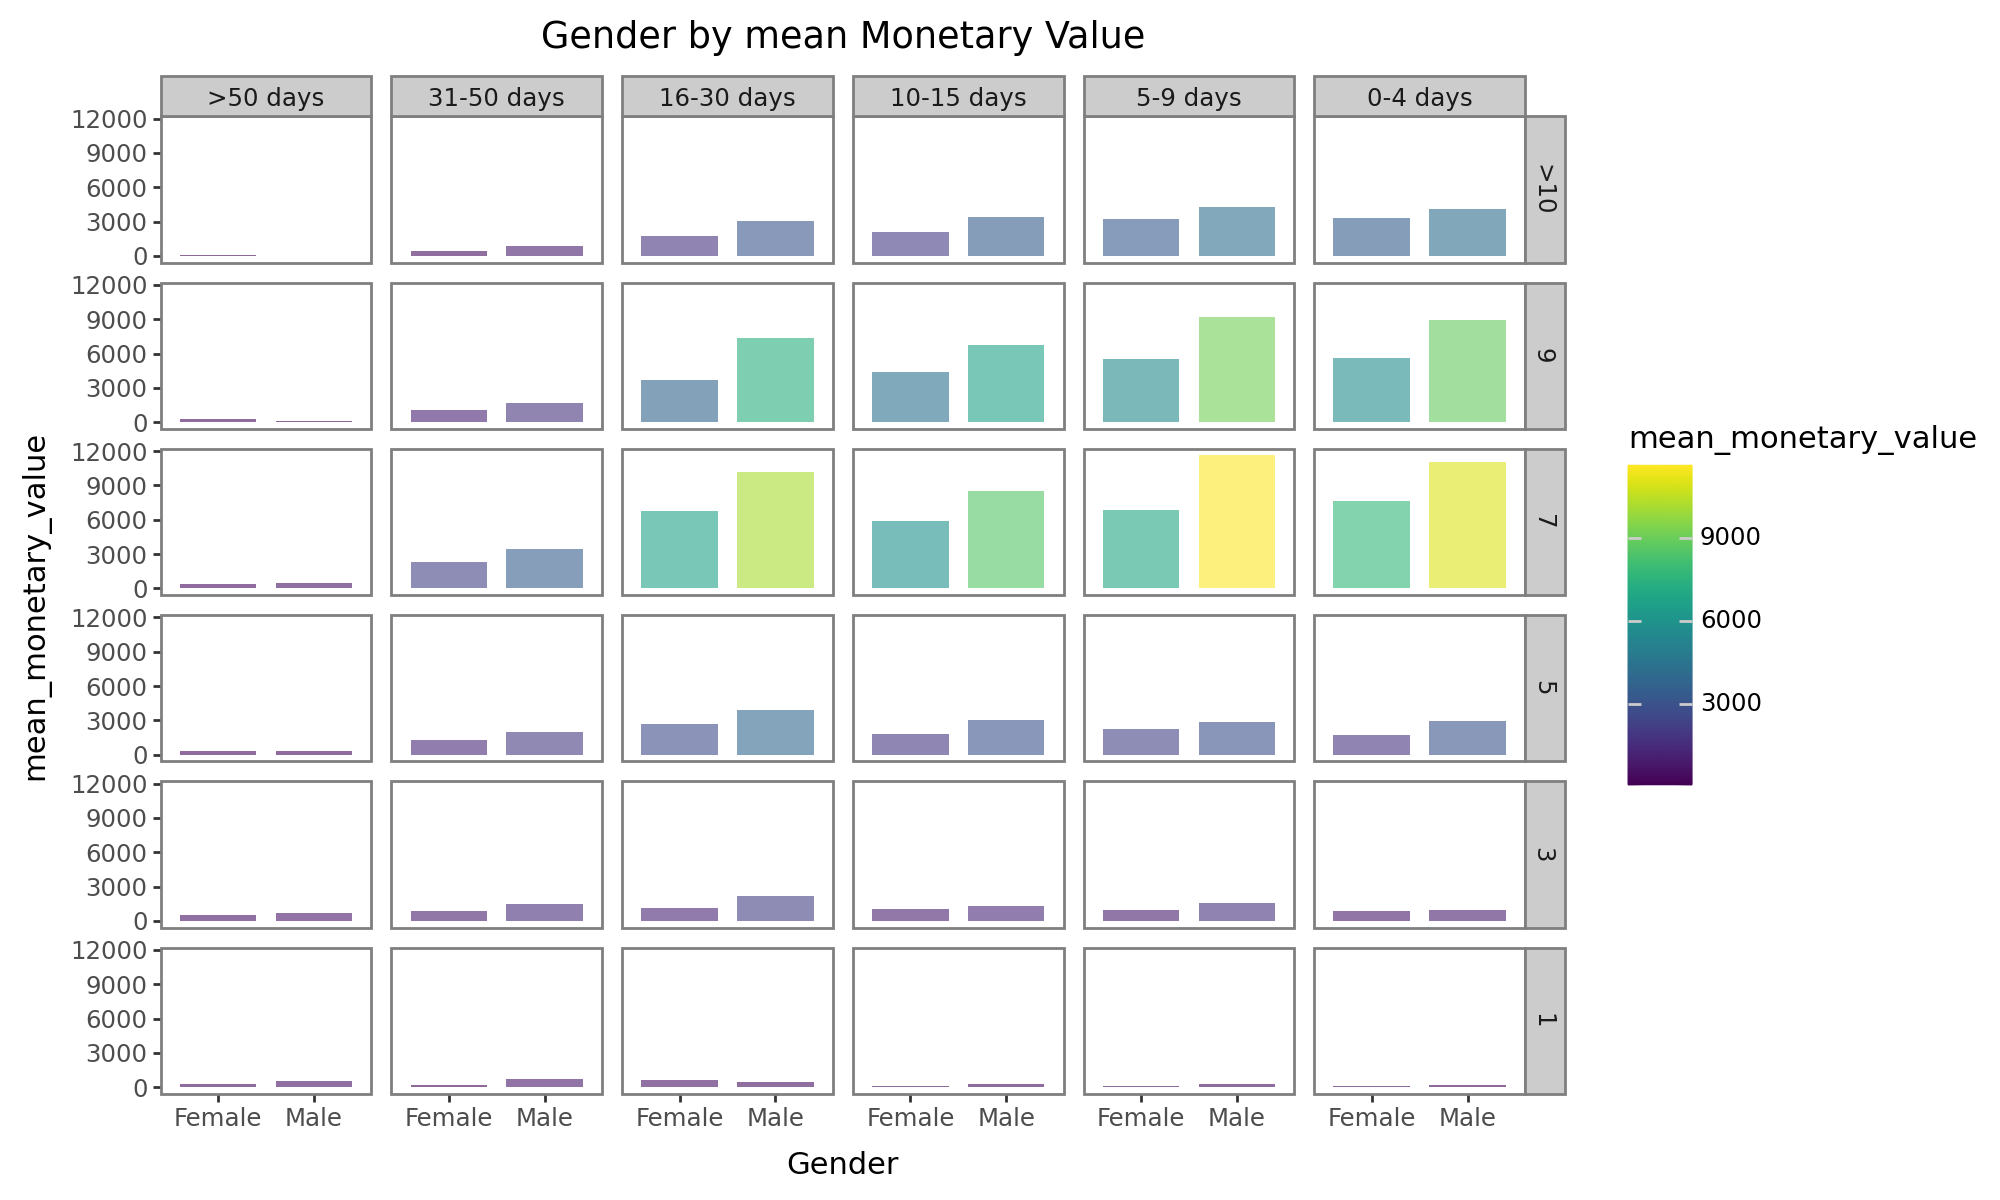

In [54]:
# Gender with Monetary Value (mean)
Grids['Gender by mean Monetary Value'] = (ggplot(Grids_data['lcgg'], aes(x='Gender', y='mean_monetary_value', fill='mean_monetary_value')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=["Male", "Female"], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by mean Monetary Value"))

Grids['Gender by mean Monetary Value'].show()

## Gender with CLV

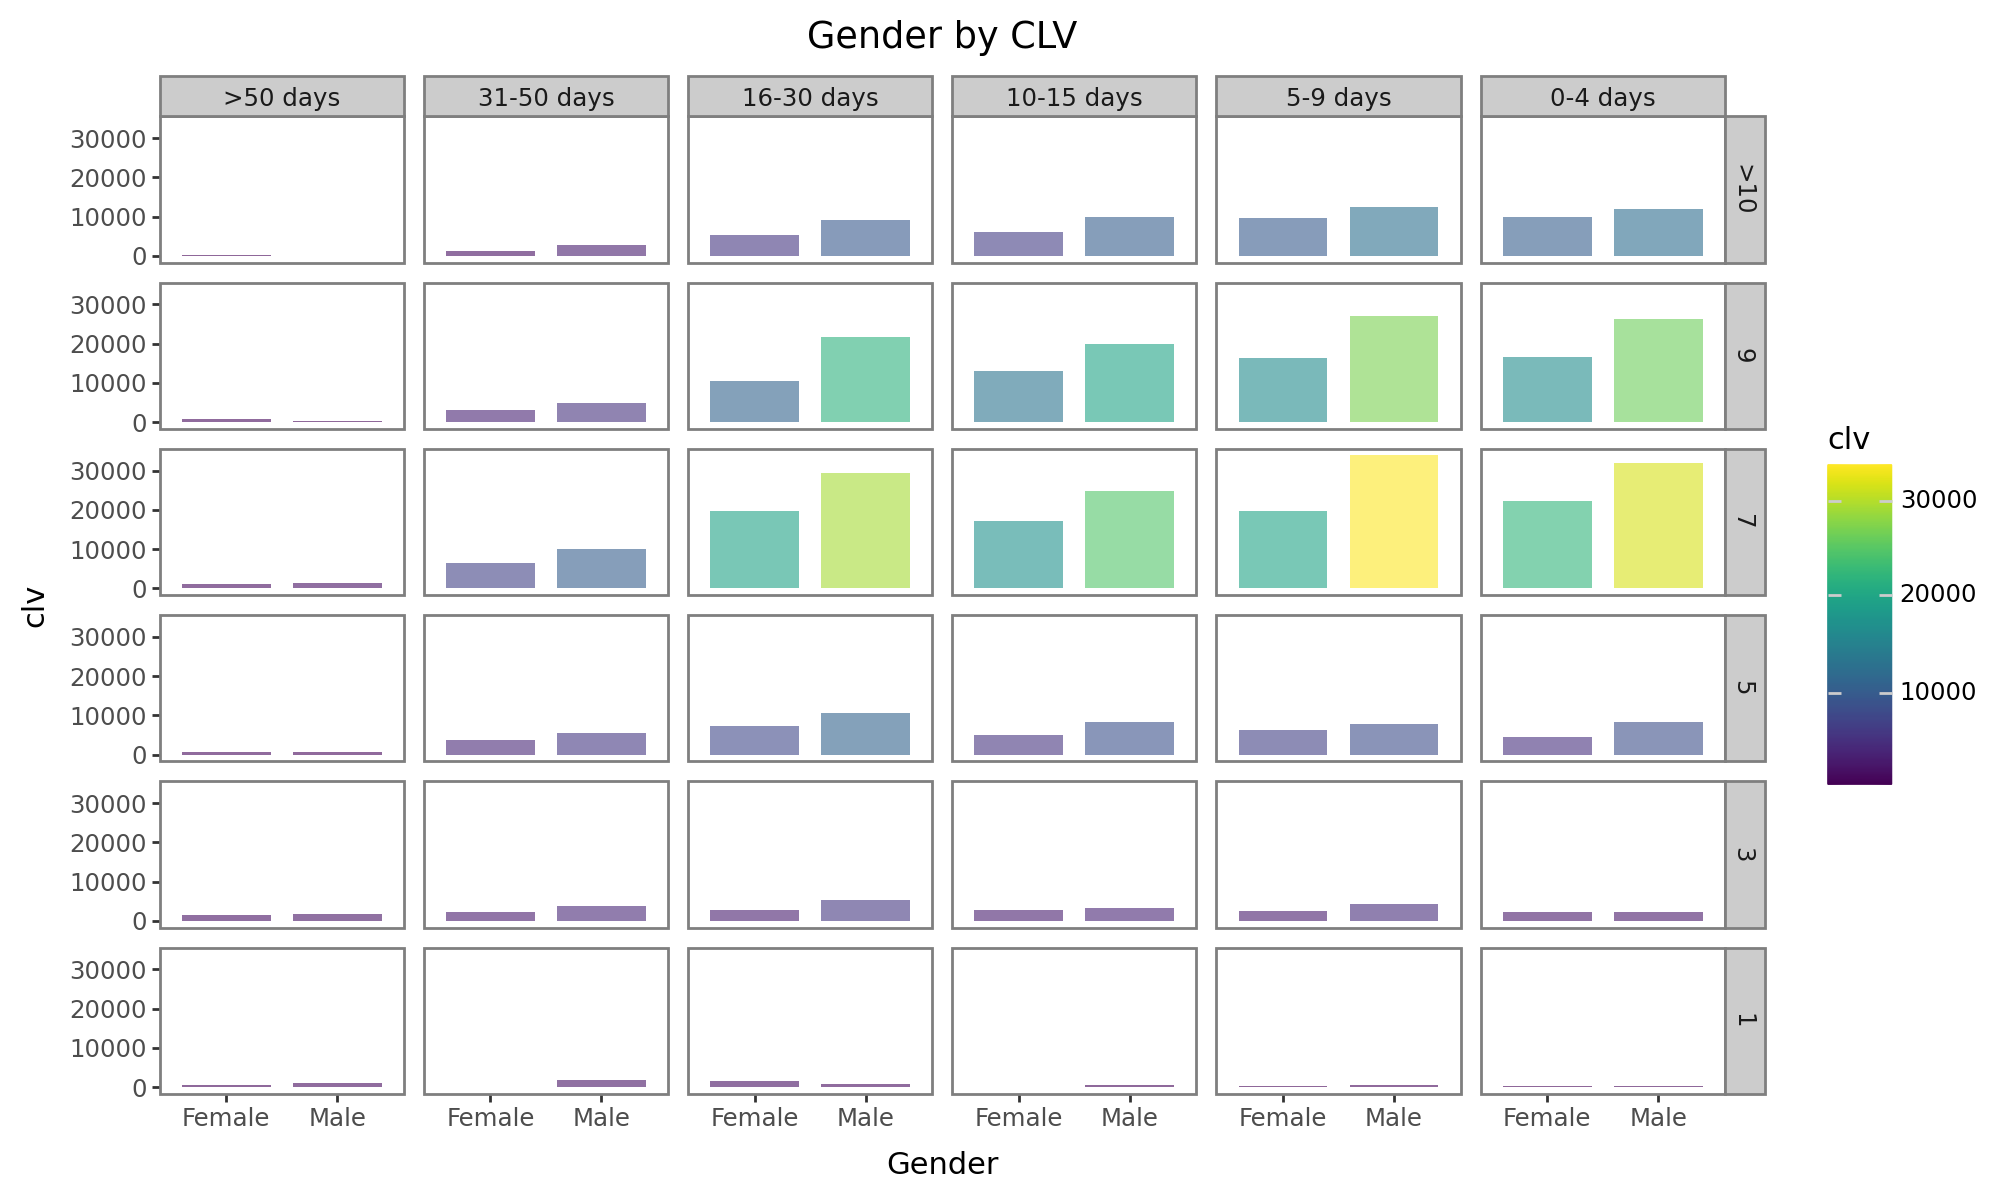

In [55]:
Grids['Gender by CLV'] = (ggplot(Grids_data['lcgg'], aes(x='Gender', y='clv', fill='clv')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=["Male", "Female"], labels=["Male", "Female"]) +  # Adjust x-axis labels
         ggtitle("Gender by CLV"))

Grids['Gender by CLV'].show()

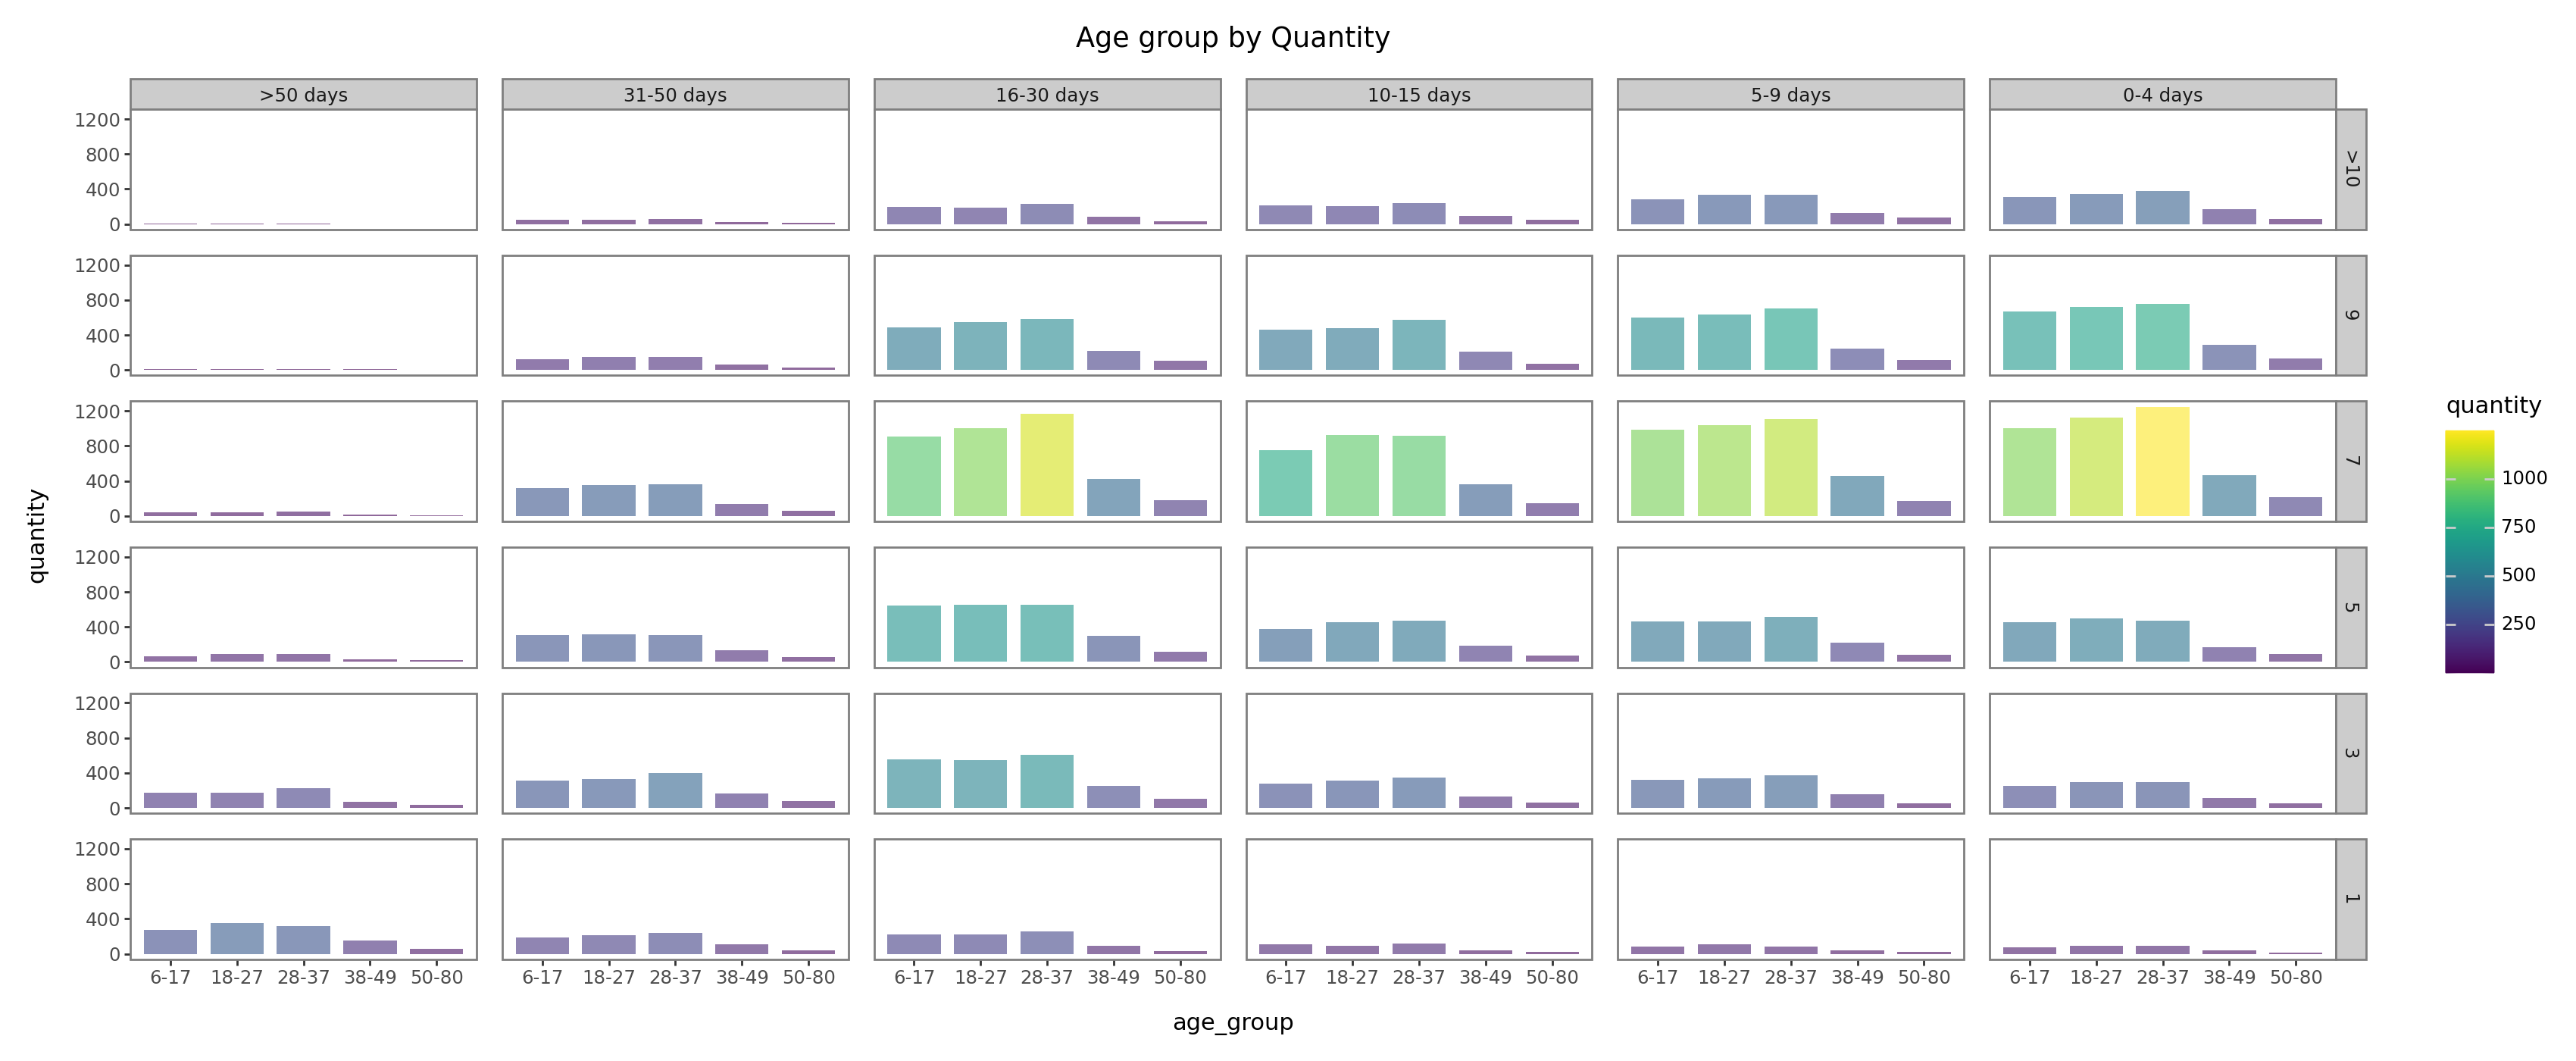

In [56]:
Grids_data['lcga']= segmented['summer_custsegm'].groupby(['age_group','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID', 'count'),
                                                                                                                              monetaryvalue=('MonetaryValue', 'sum'),
                                                                                                                               meanmonetaryvalue=('MonetaryValue', 'mean'),
                                                                                                                              clv=('CLV', 'sum'))
Grids_data['lcga']['player']='player'

Grids["Age group by Quantity"] = (ggplot(Grids_data['lcga'], aes(x='age_group', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by Quantity"))

Grids["Age group by Quantity"].show()

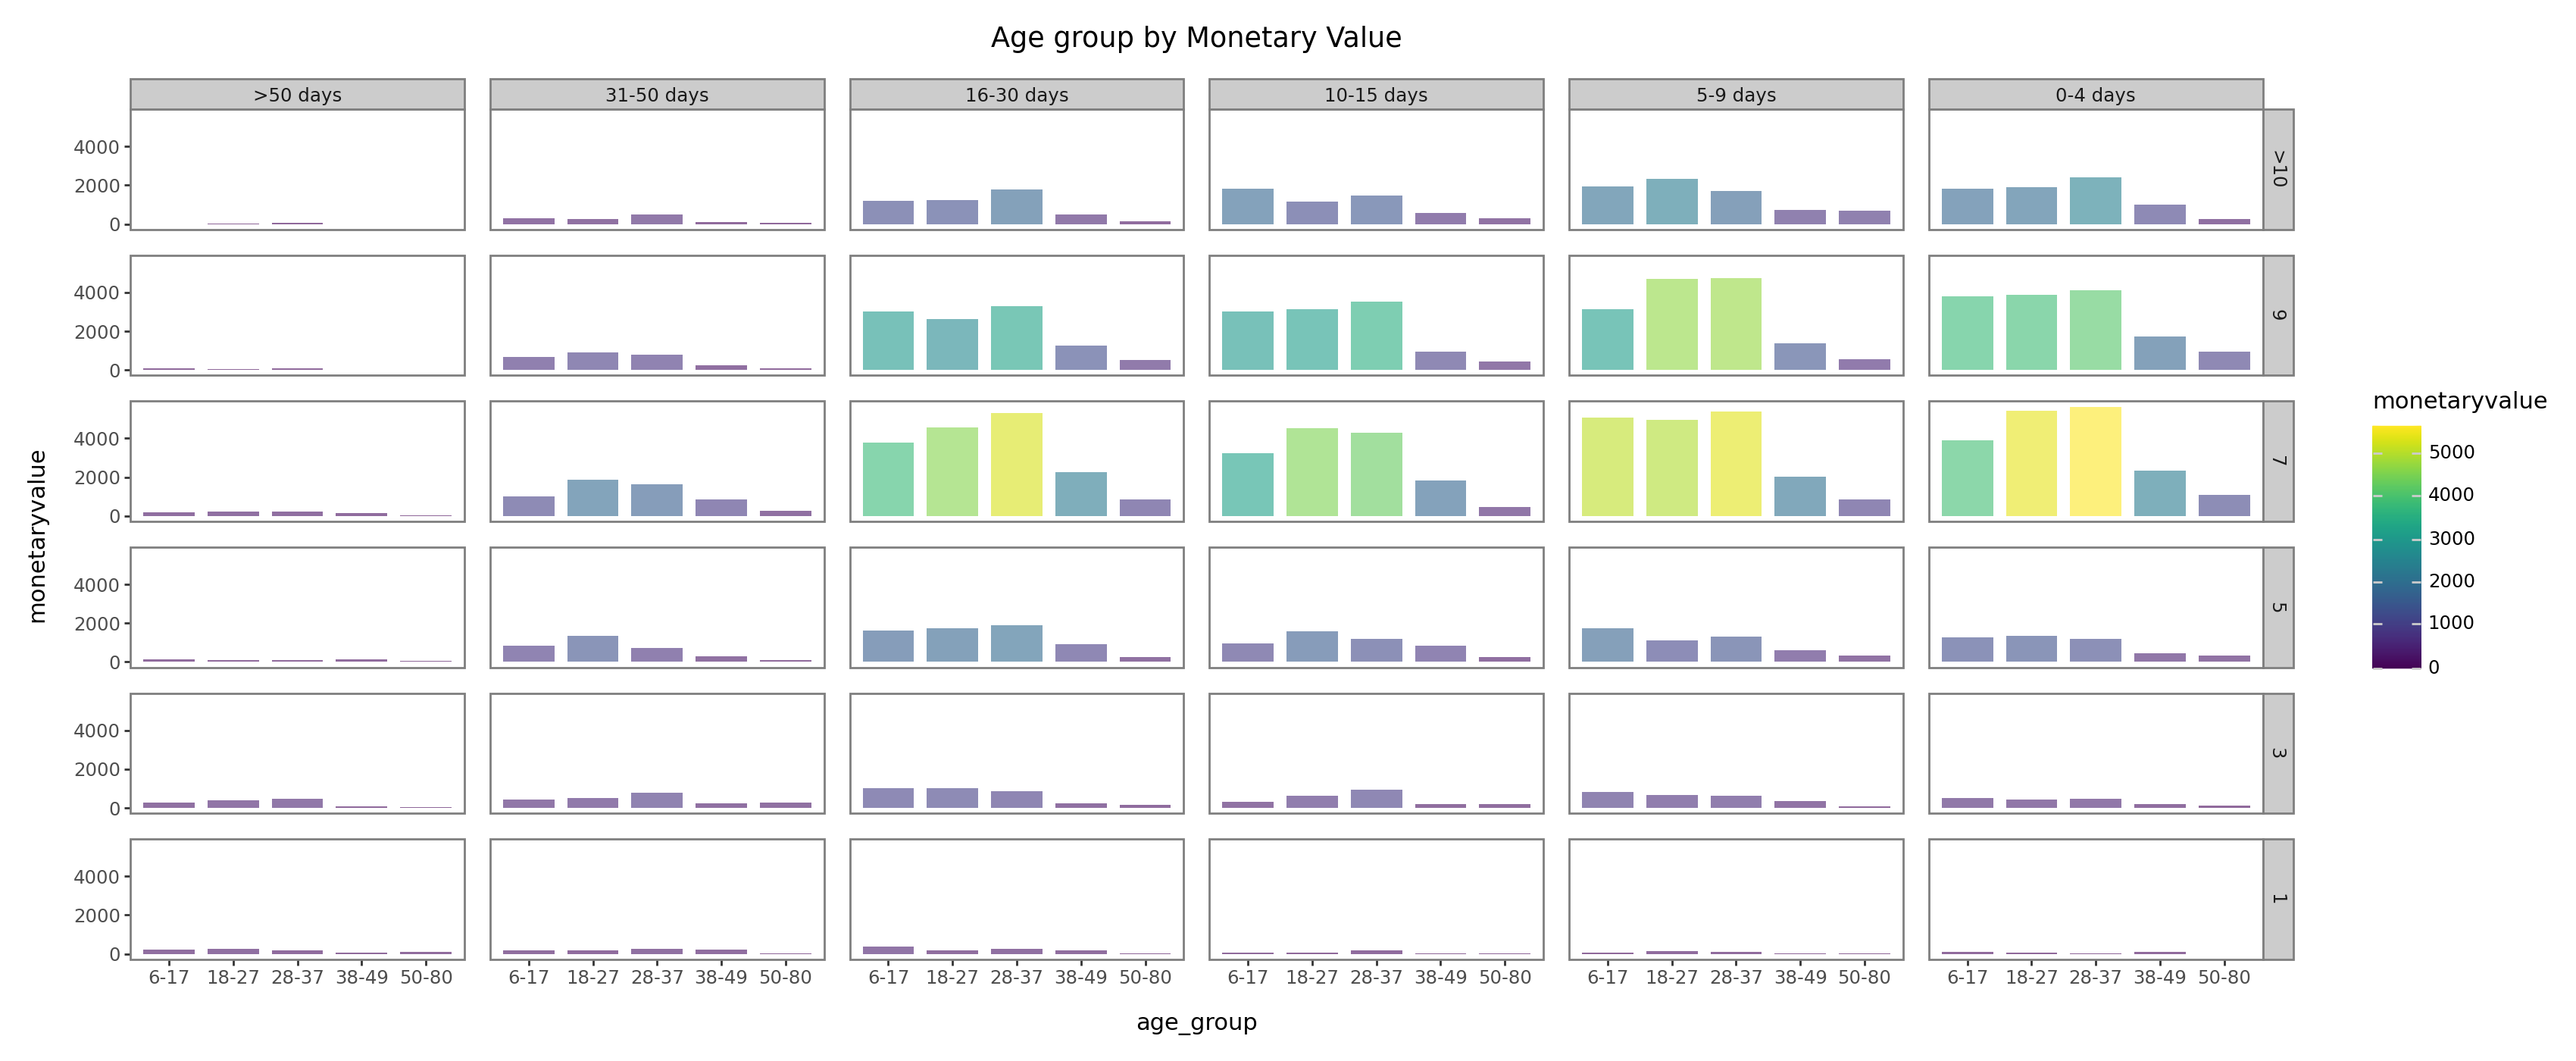

In [57]:
Grids["Age group by Monetary Value"] = (ggplot(Grids_data['lcga'], aes(x='age_group', y='monetaryvalue', fill='monetaryvalue')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by Monetary Value"))

Grids["Age group by Monetary Value"].show()

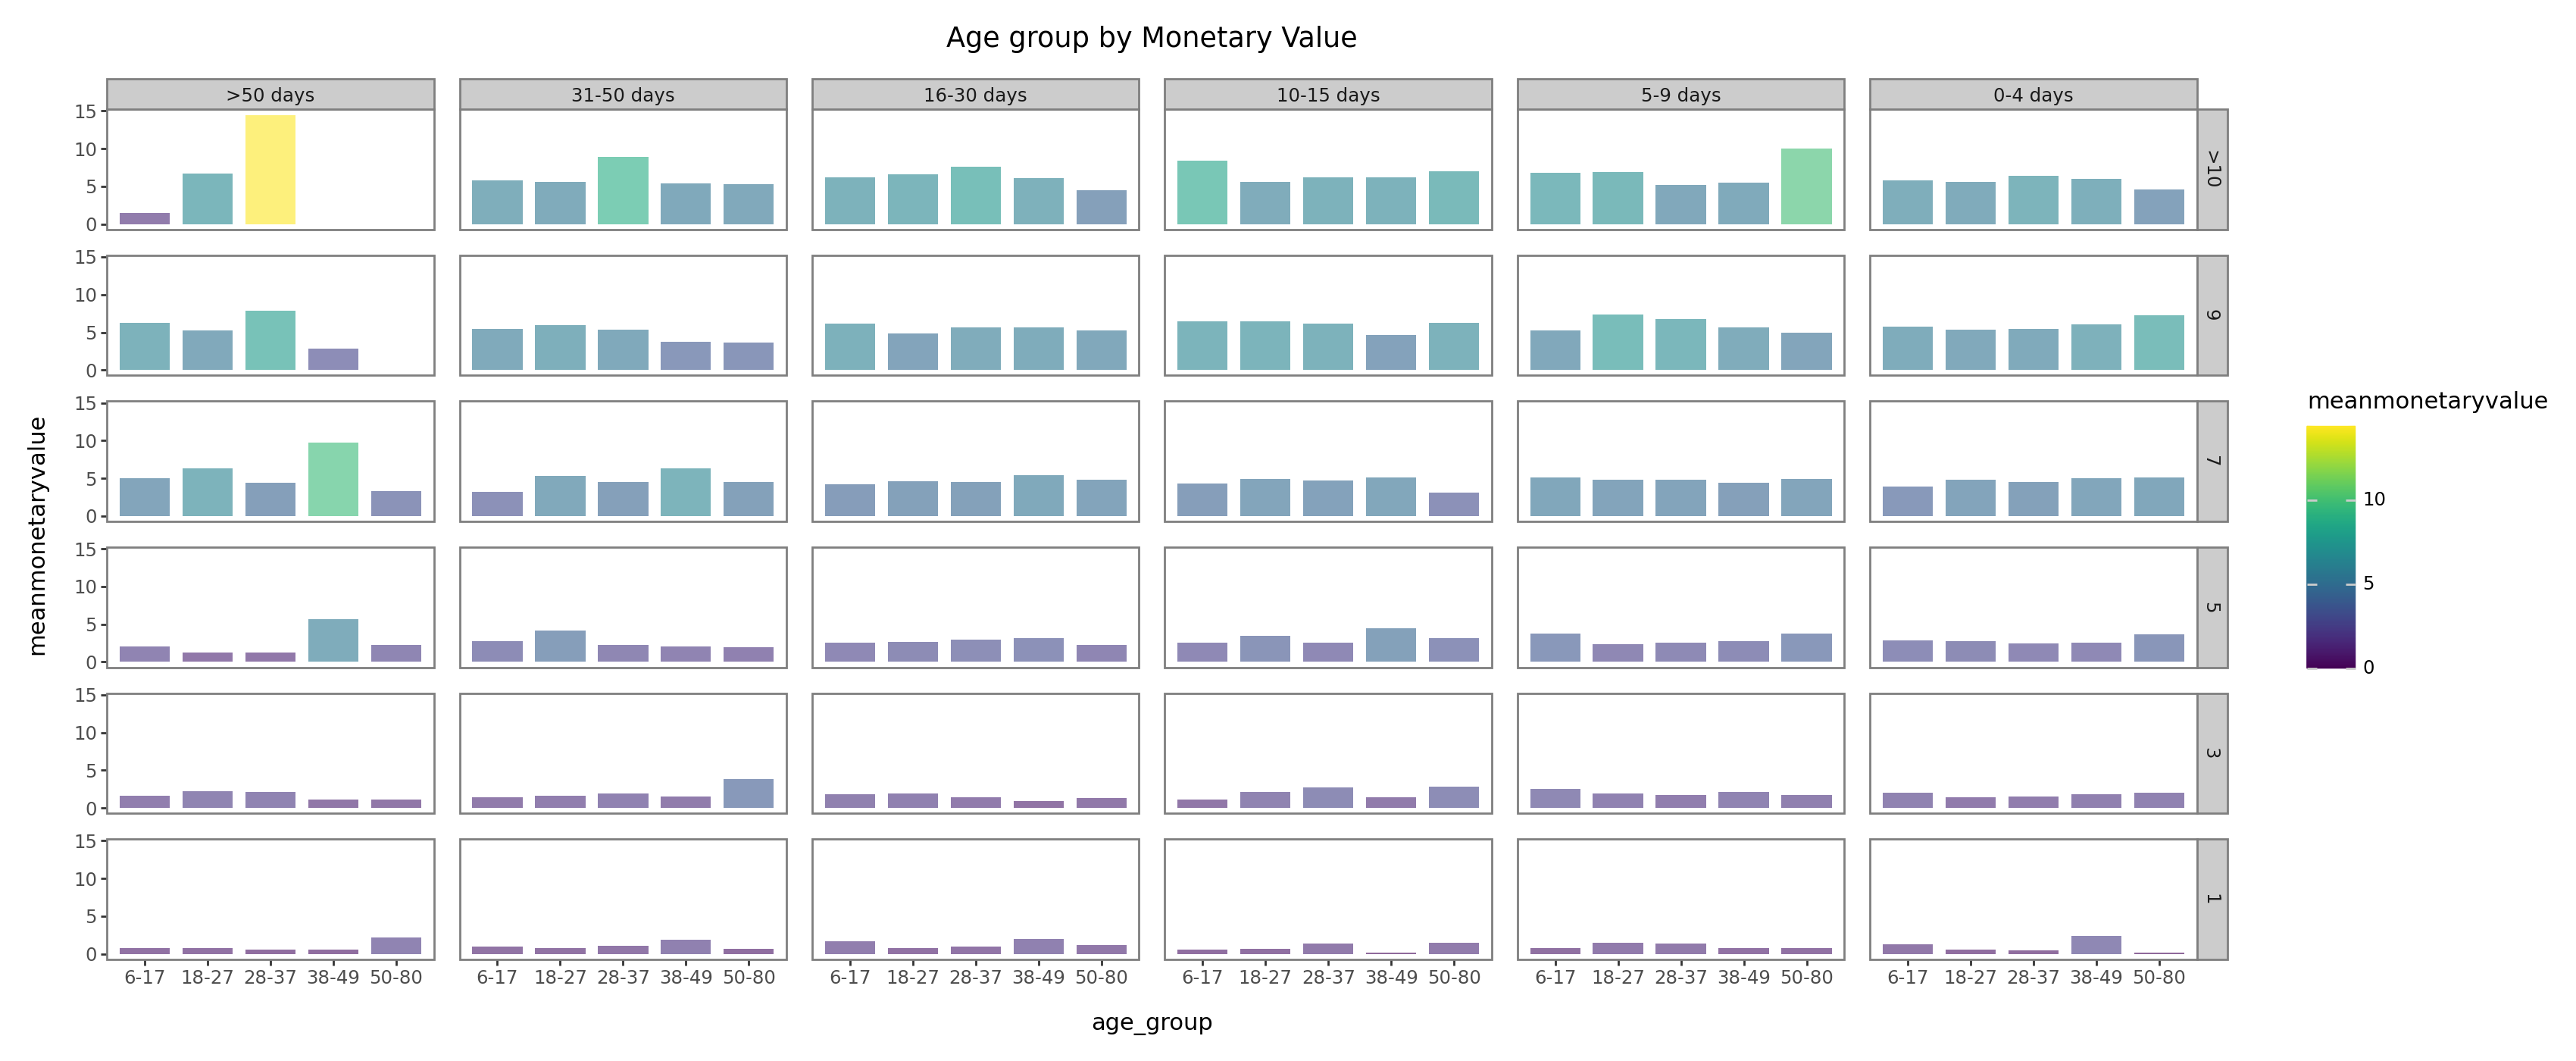

In [58]:
# Age group with Monetary Value (mean)
Grids["Age group by Monetary Value"] = (ggplot(Grids_data['lcga'], aes(x='age_group', y='meanmonetaryvalue', fill='meanmonetaryvalue')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by Monetary Value"))

Grids["Age group by Monetary Value"].show()

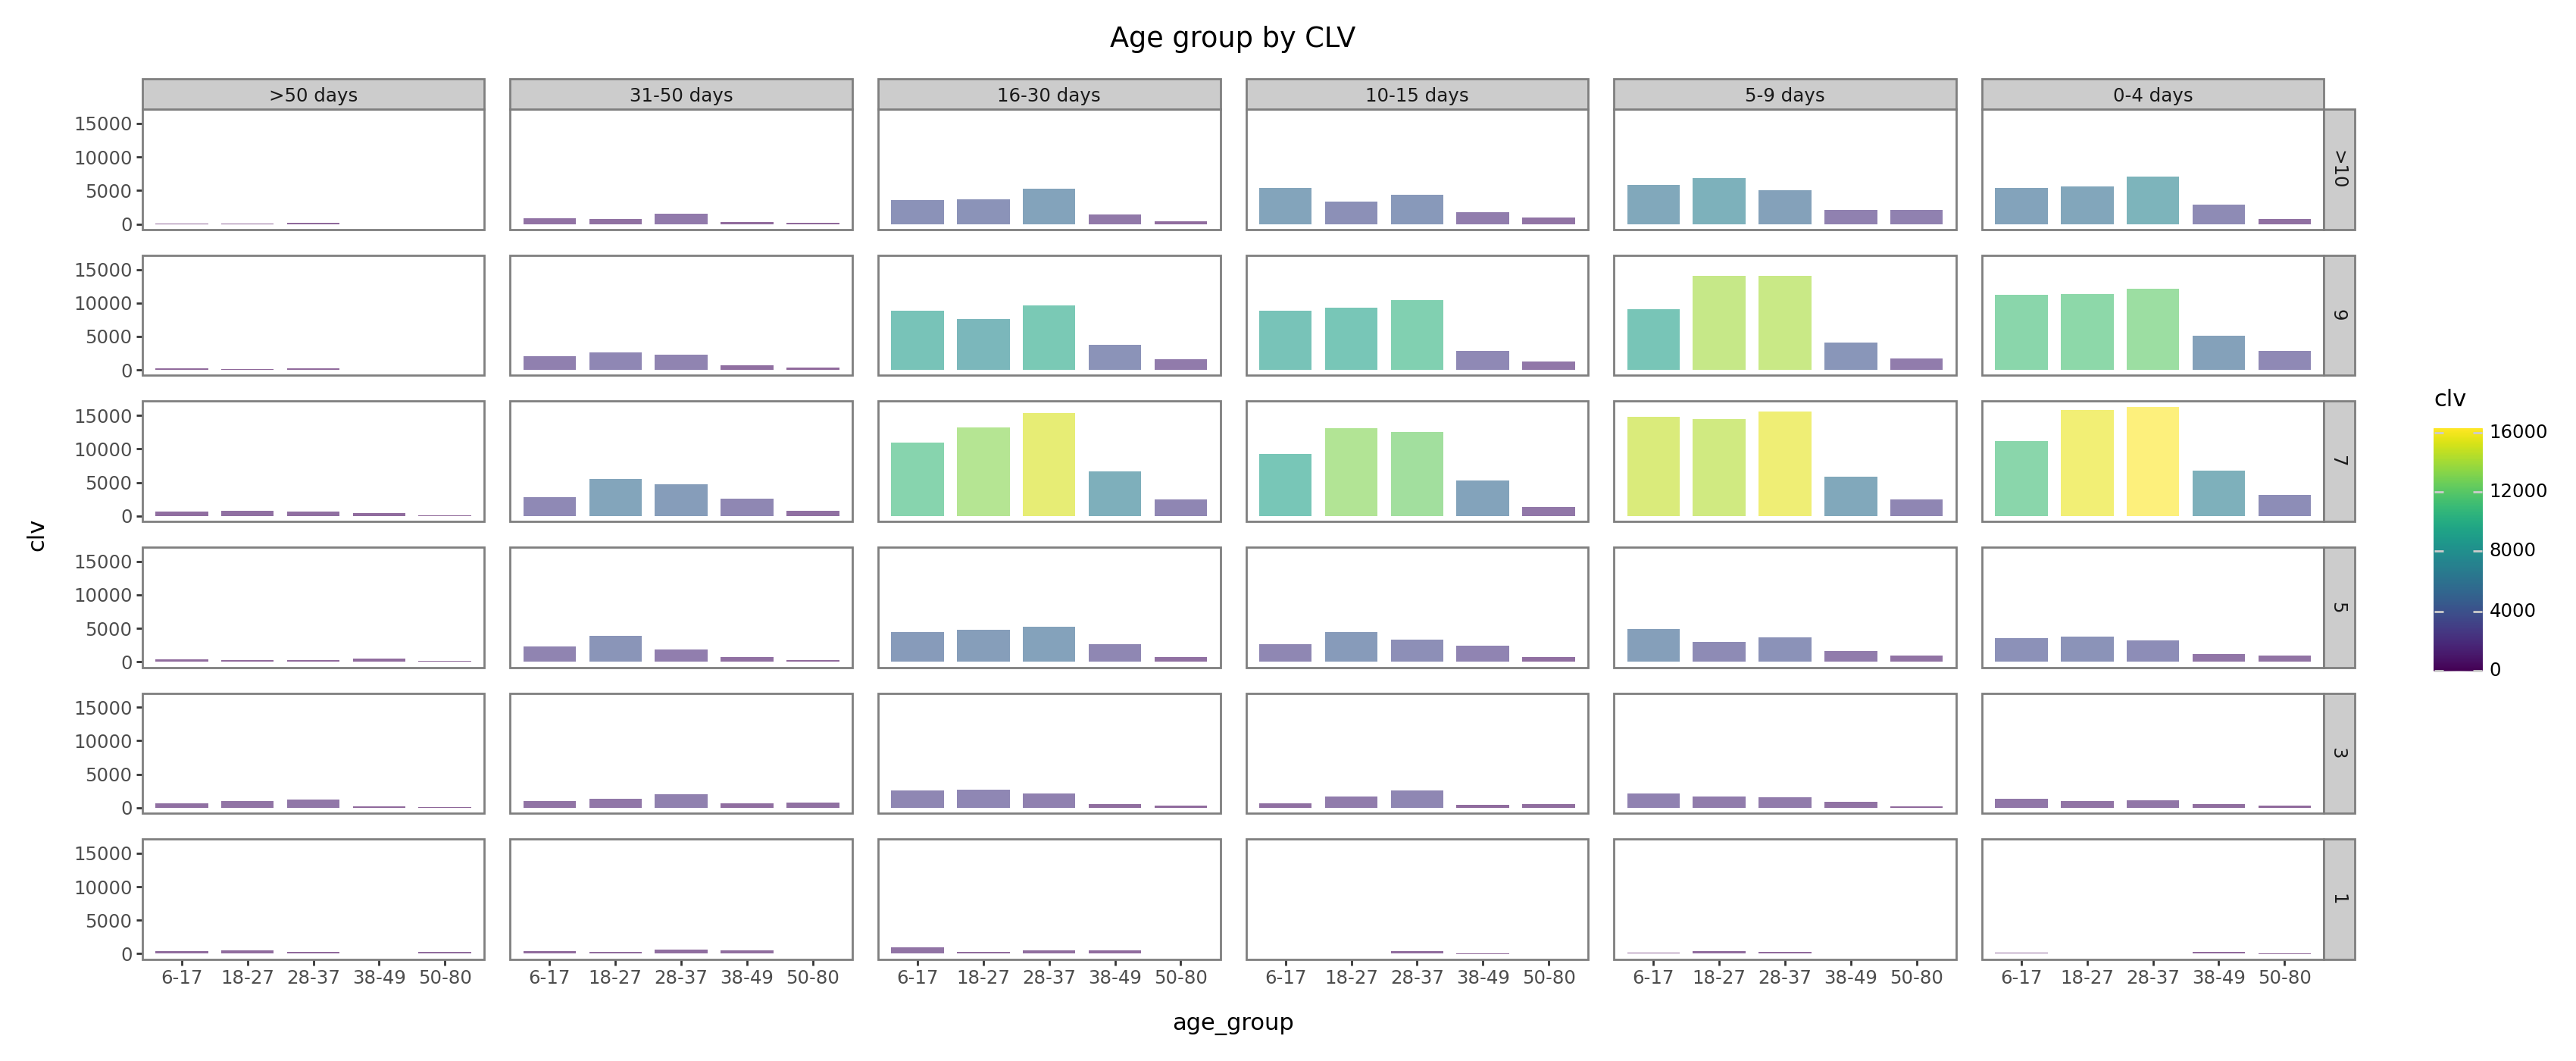

In [59]:
# Age group with CLV
Grids["Age group by CLV"] = (ggplot(Grids_data['lcga'], aes(x='age_group', y='clv', fill='clv')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(17, 7),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         ggtitle("Age group by CLV"))

Grids["Age group by CLV"].show()

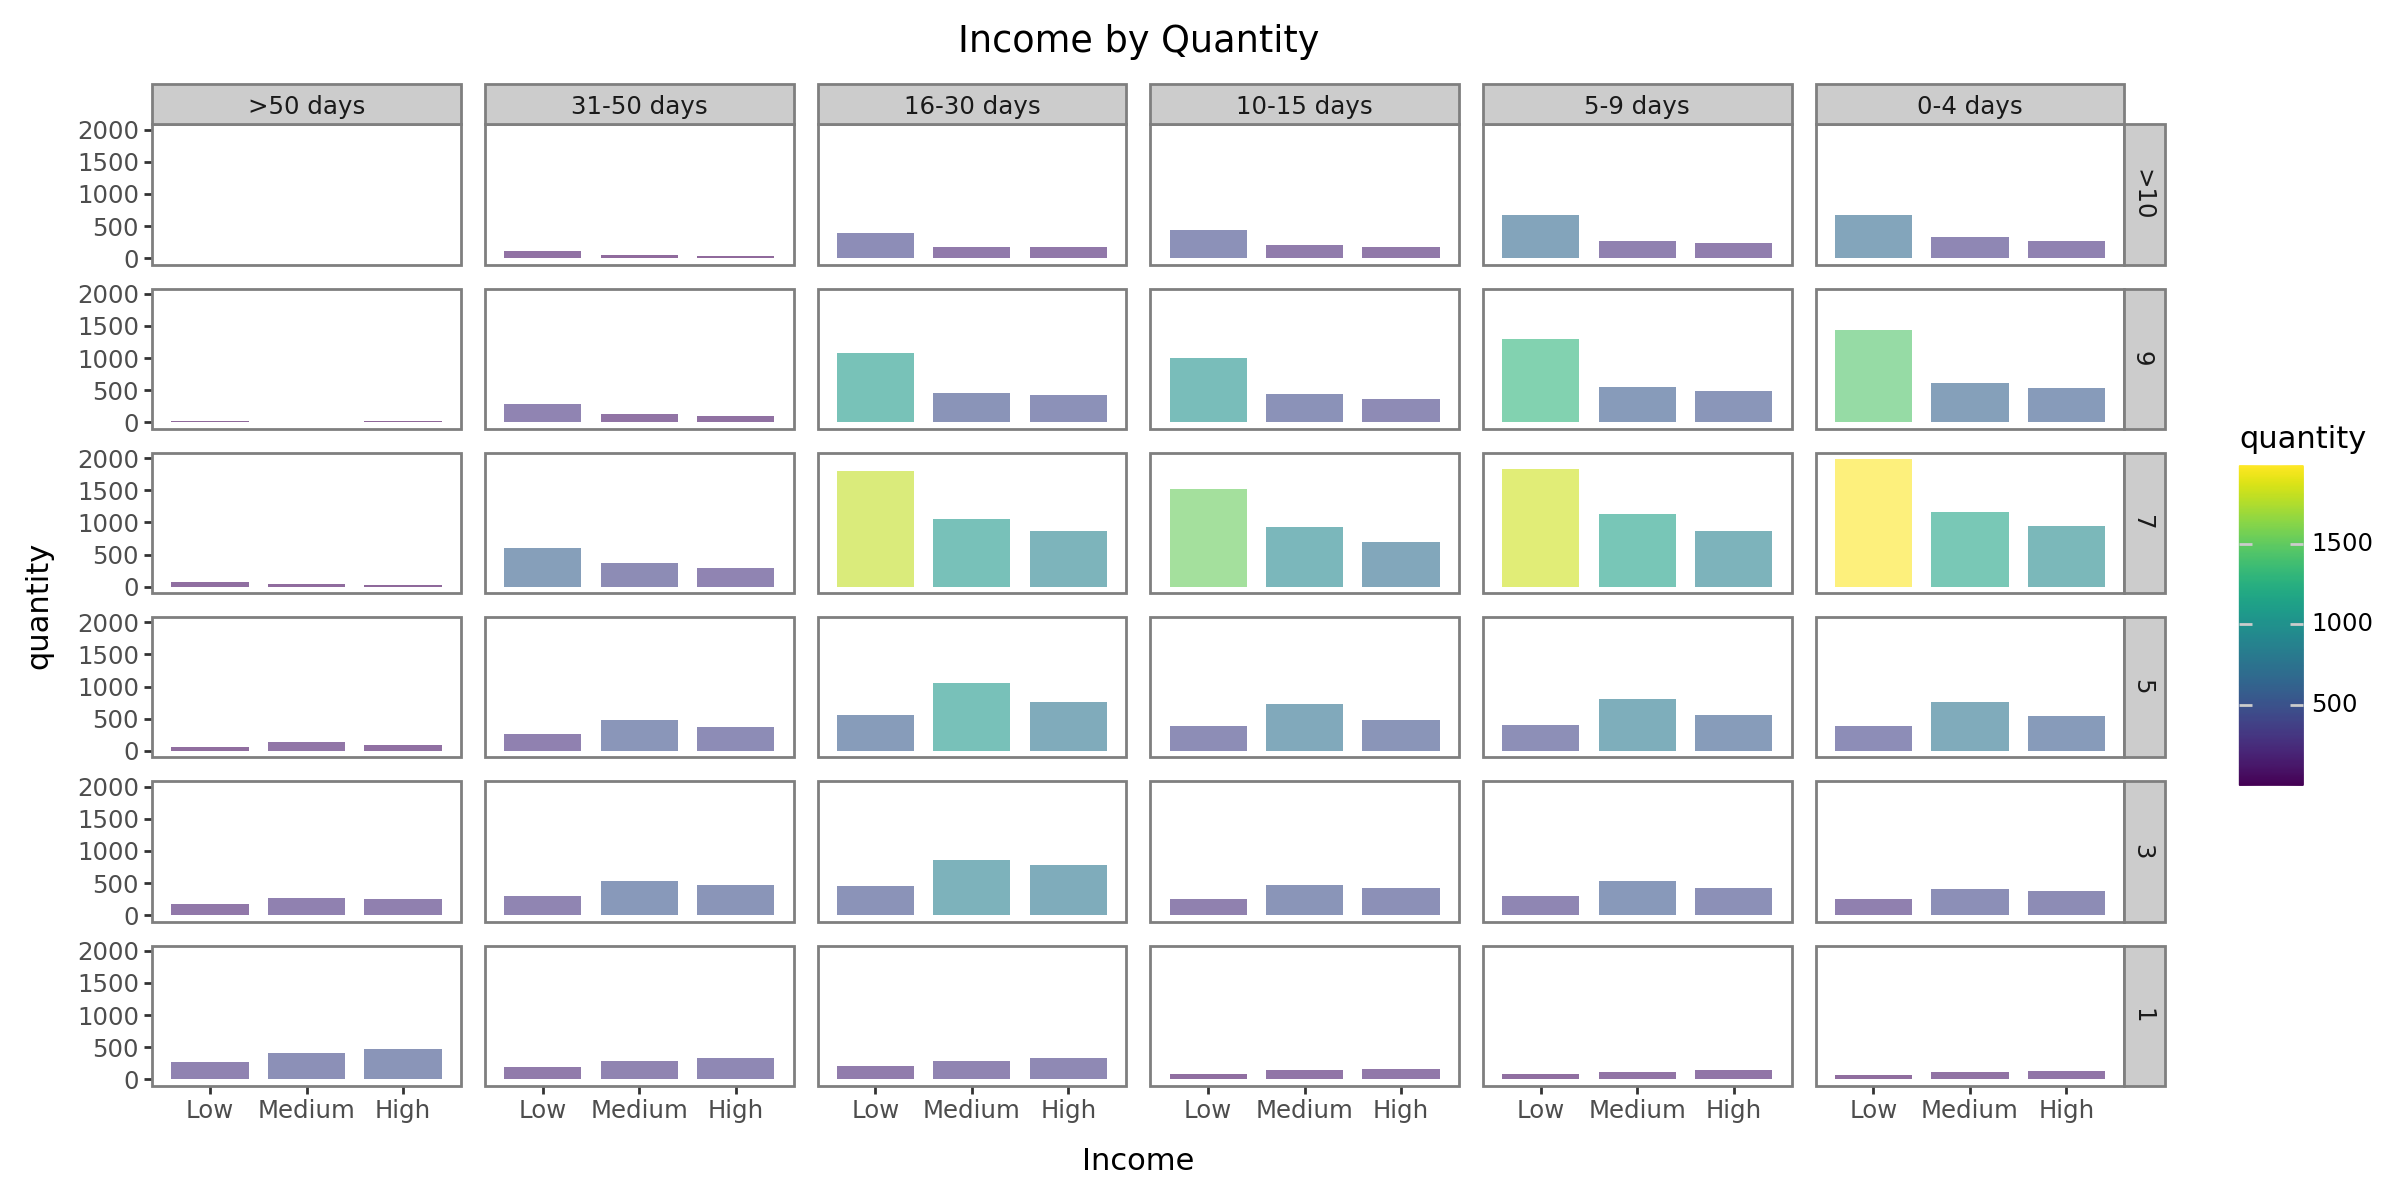

In [60]:
# Income with Quantity
Grids_data['lcgi']= segmented['summer_custsegm'].groupby(['Income','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID', 'count'),
                                                                                                                              monetaryvalue=('MonetaryValue', 'sum'),
                                                                                                                               meanmonetaryvalue=('MonetaryValue', 'mean'),
                                                                                                                              clv=('CLV', 'sum'))
Grids_data['lcgi']['player']='player'

Grids["Income by Quantity"] = (ggplot(Grids_data['lcgi'], aes(x='Income', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=['Low', 'Medium', 'High'], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by Quantity"))

Grids["Income by Quantity"].show()

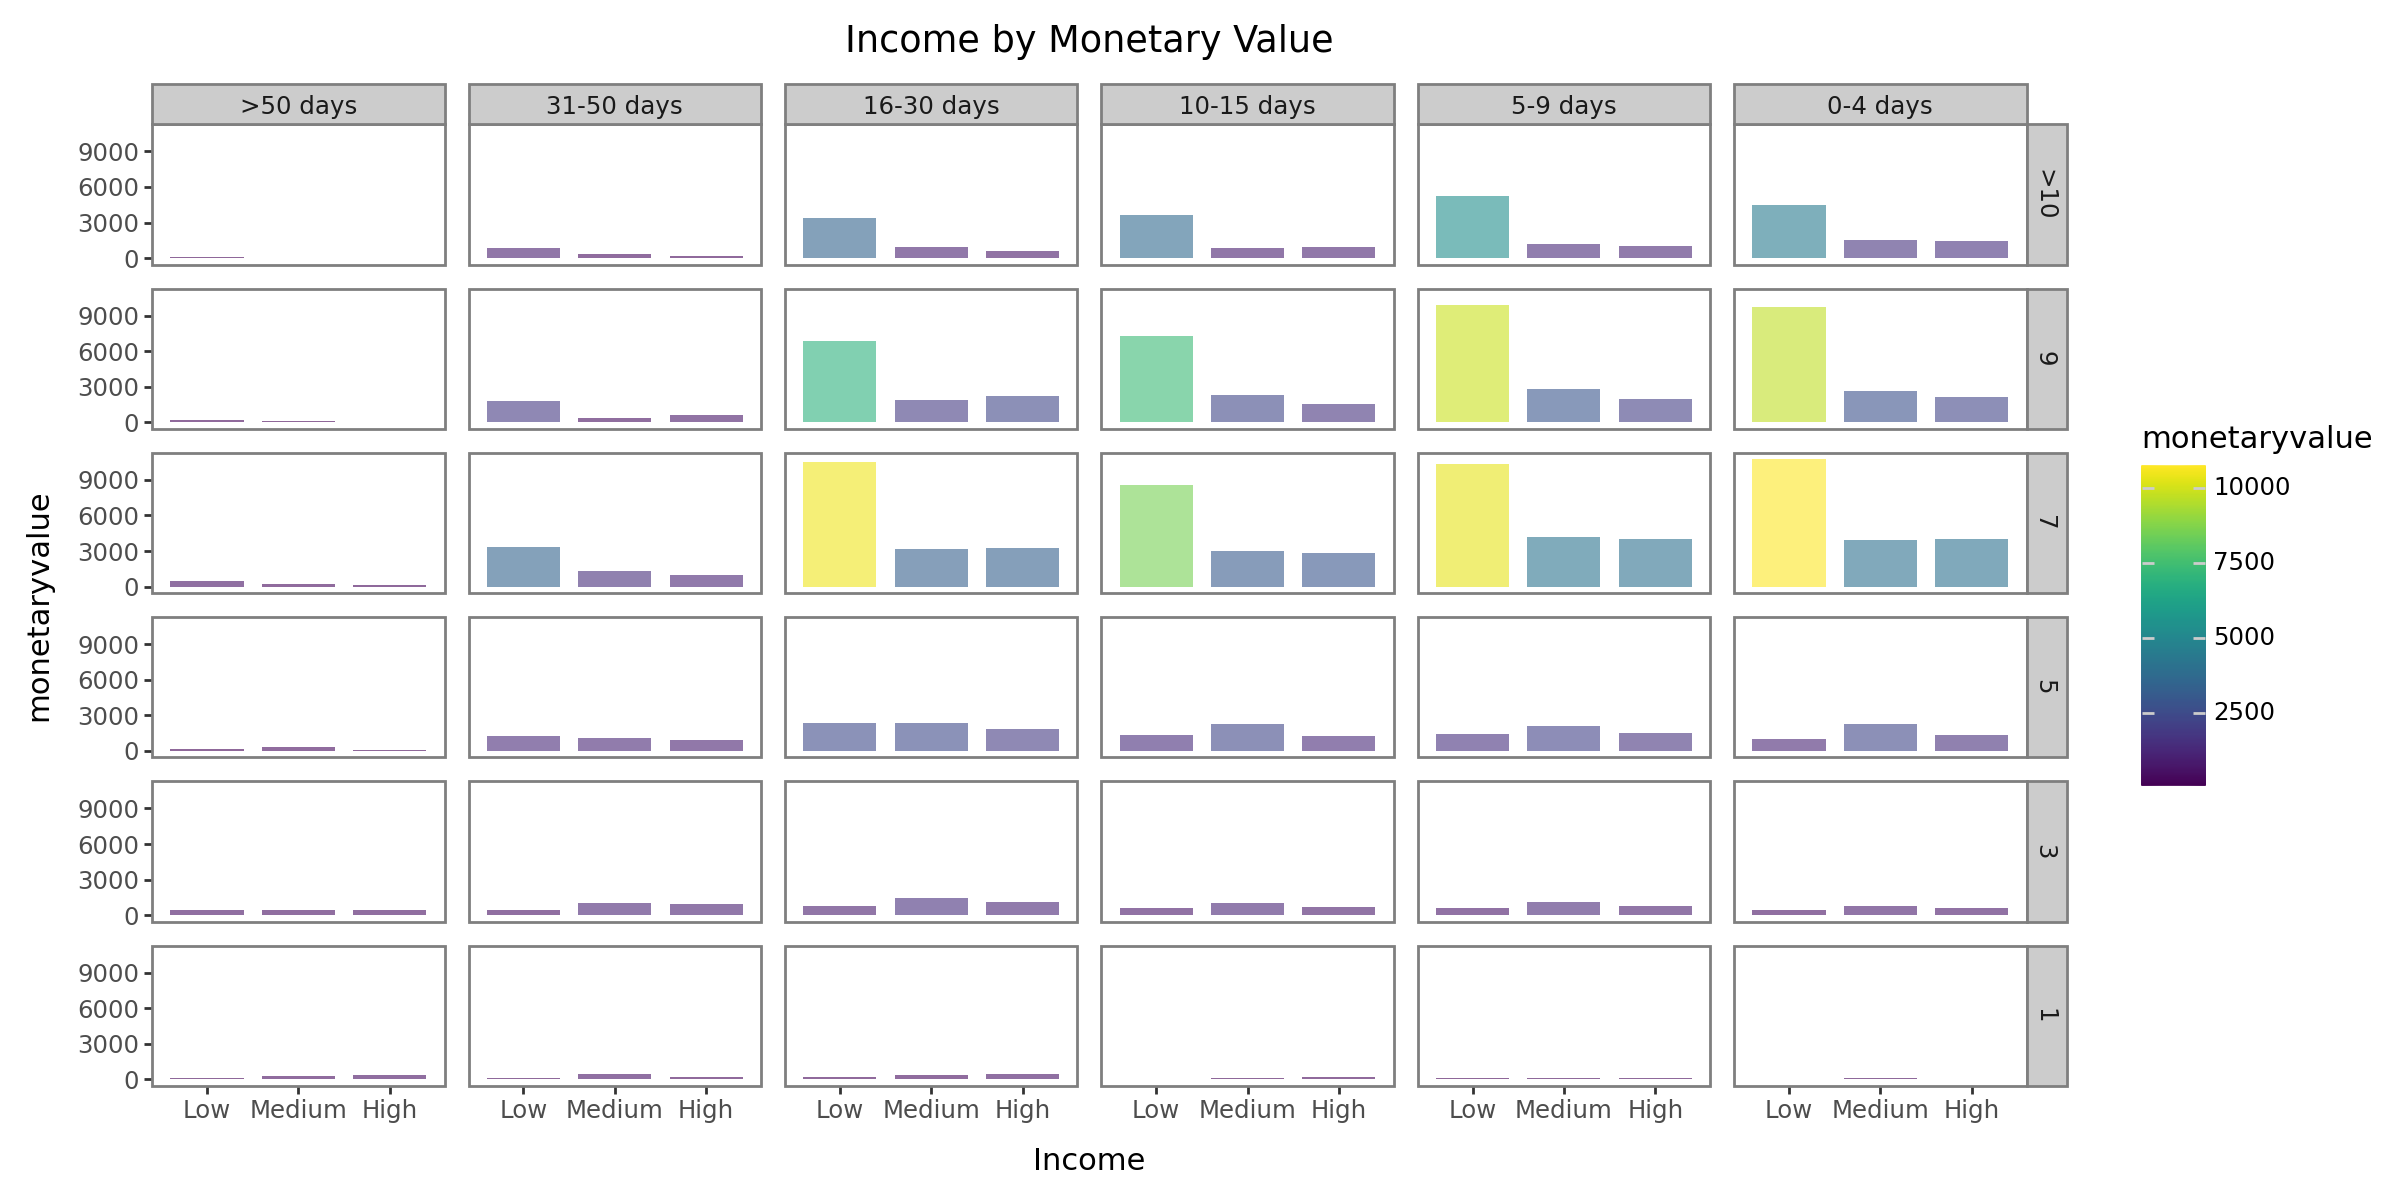

In [61]:
# Income with Monetary Value

Grids["Income by Monetary Value"] = (ggplot(Grids_data['lcgi'], aes(x='Income', y='monetaryvalue', fill='monetaryvalue')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=['Low', 'Medium', 'High'], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by Monetary Value"))

Grids["Income by Monetary Value"].show()

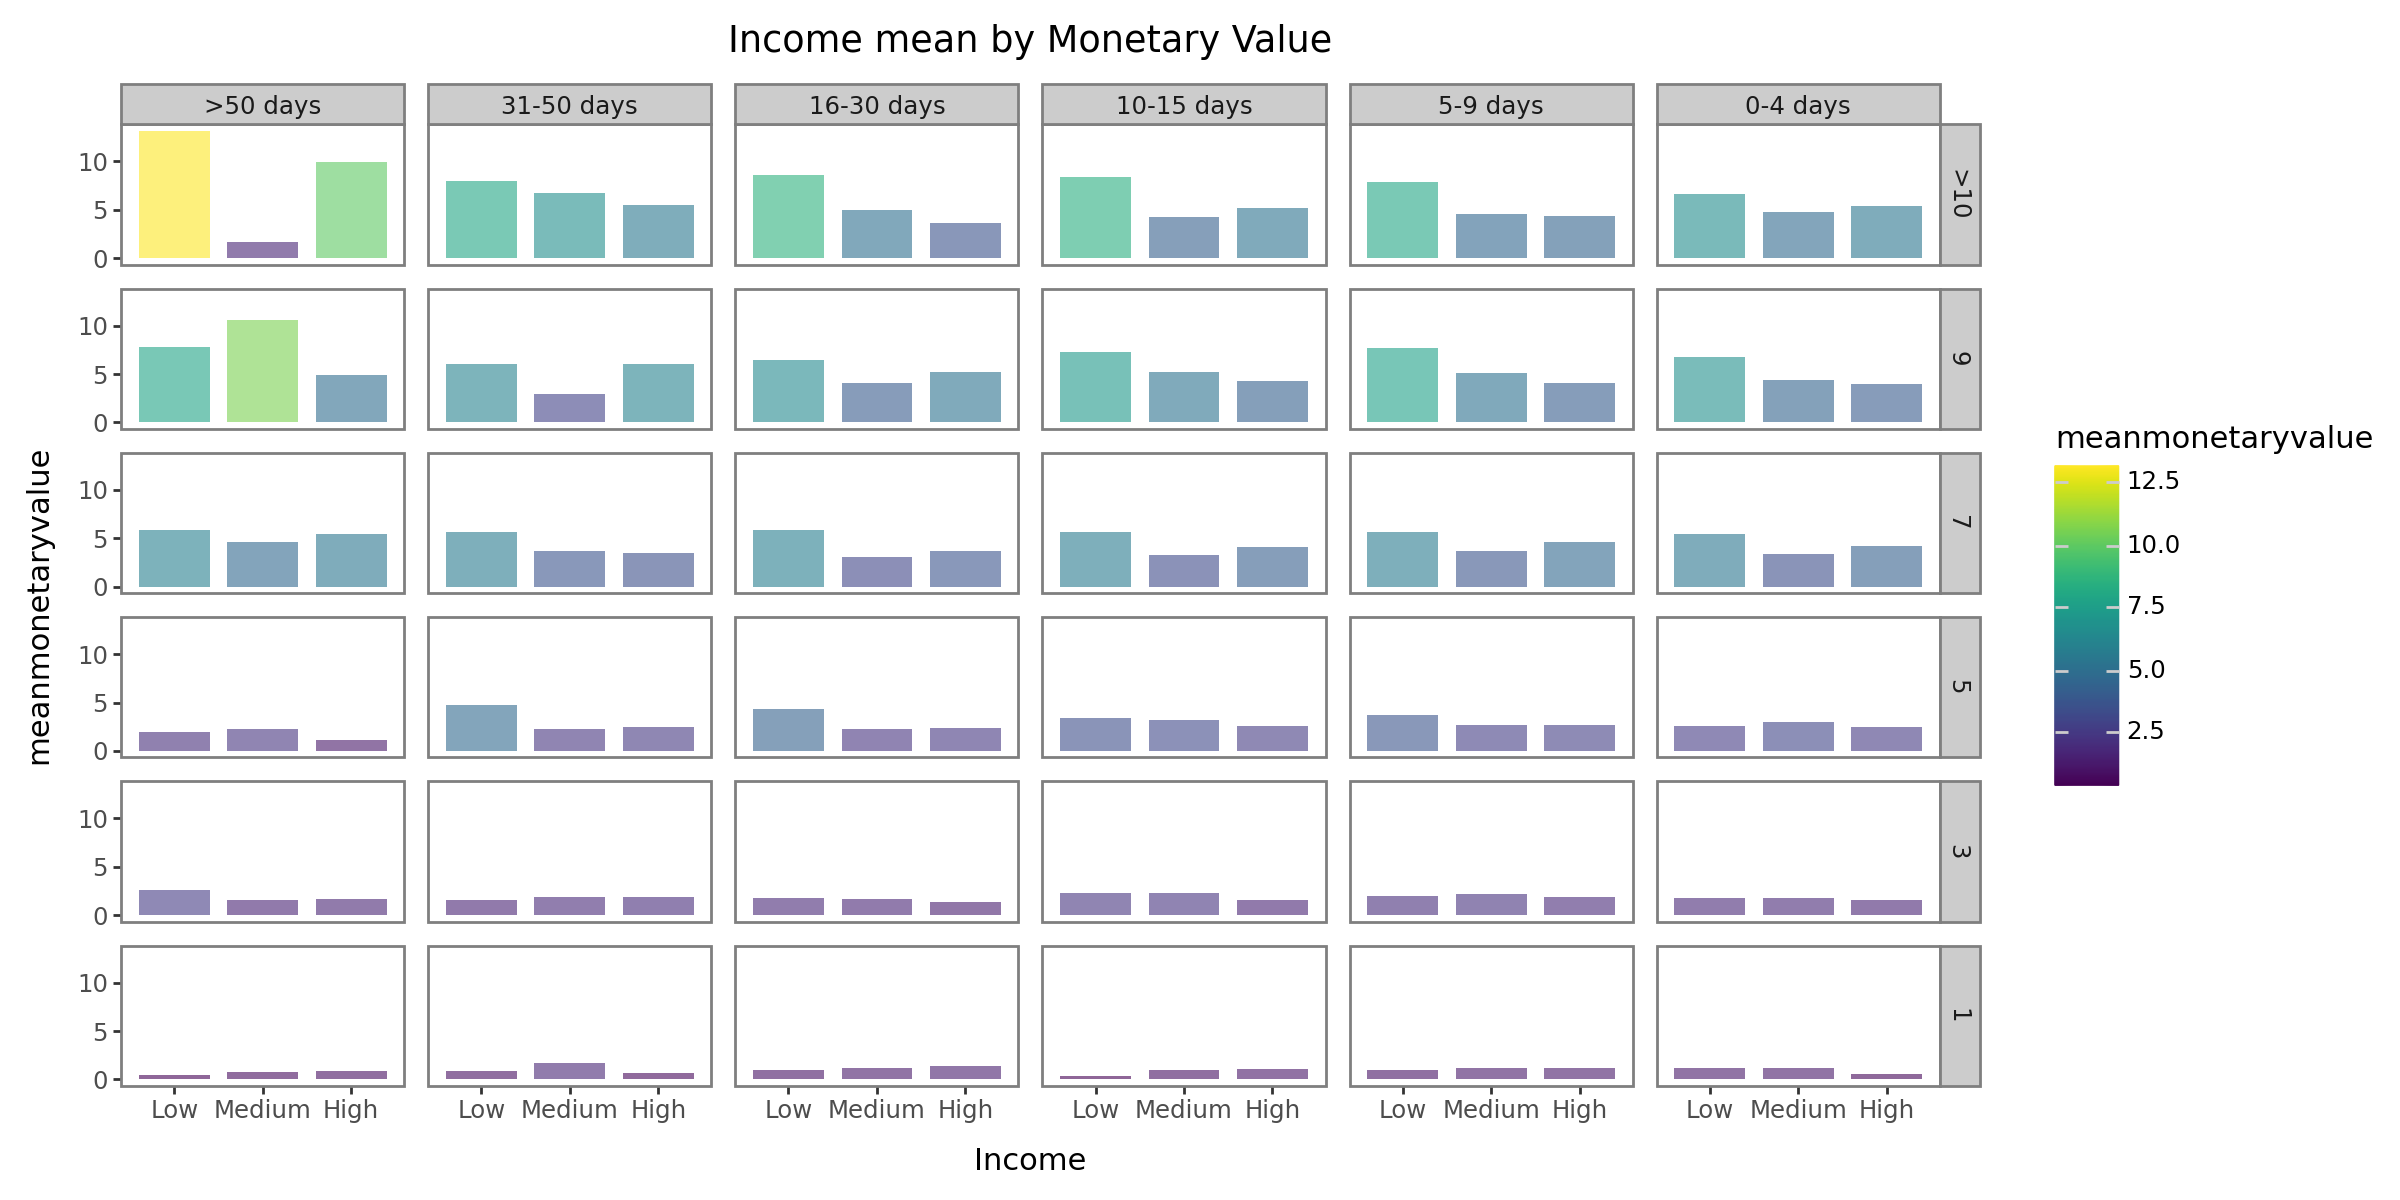

In [62]:
# Income with Monetary Value (mean)

Grids["Income by mean Monetary Value"] = (ggplot(Grids_data['lcgi'], aes(x='Income', y='meanmonetaryvalue', fill='meanmonetaryvalue')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=['Low', 'Medium', 'High'], labels=["Low", "Medium", "High"]) +
         ggtitle("Income mean by Monetary Value"))

Grids["Income by mean Monetary Value"].show()

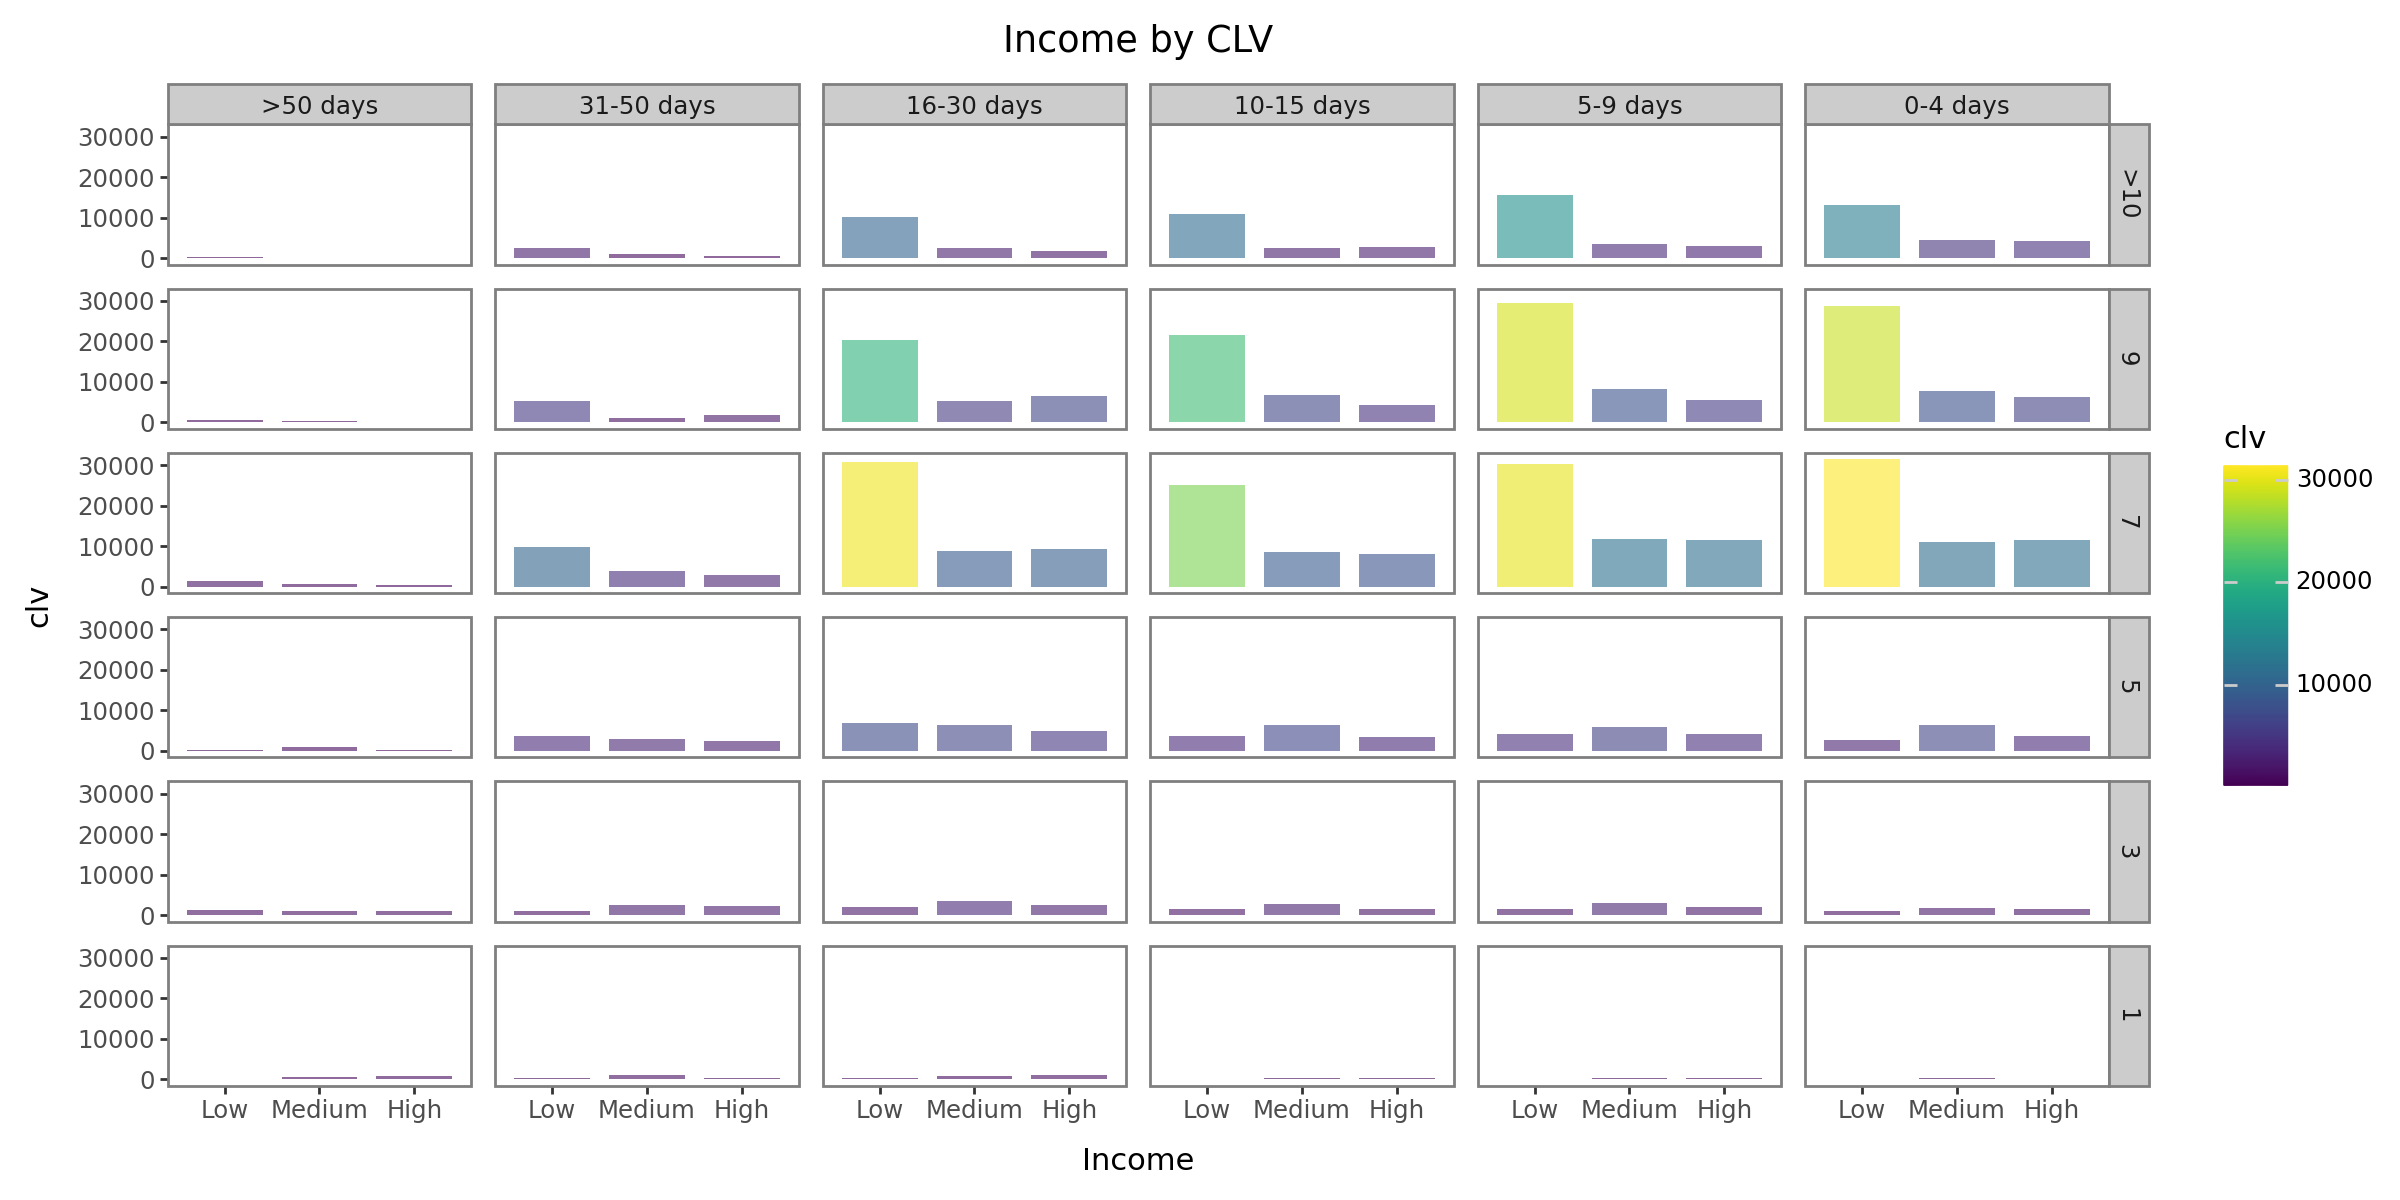

In [63]:
# Income with CLV

Grids["Income by CLV"] = (ggplot(Grids_data['lcgi'], aes(x='Income', y='clv', fill='clv')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(12, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_discrete(breaks=['Low', 'Medium', 'High'], labels=["Low", "Medium", "High"]) +
         ggtitle("Income by CLV"))

Grids["Income by CLV"].show()

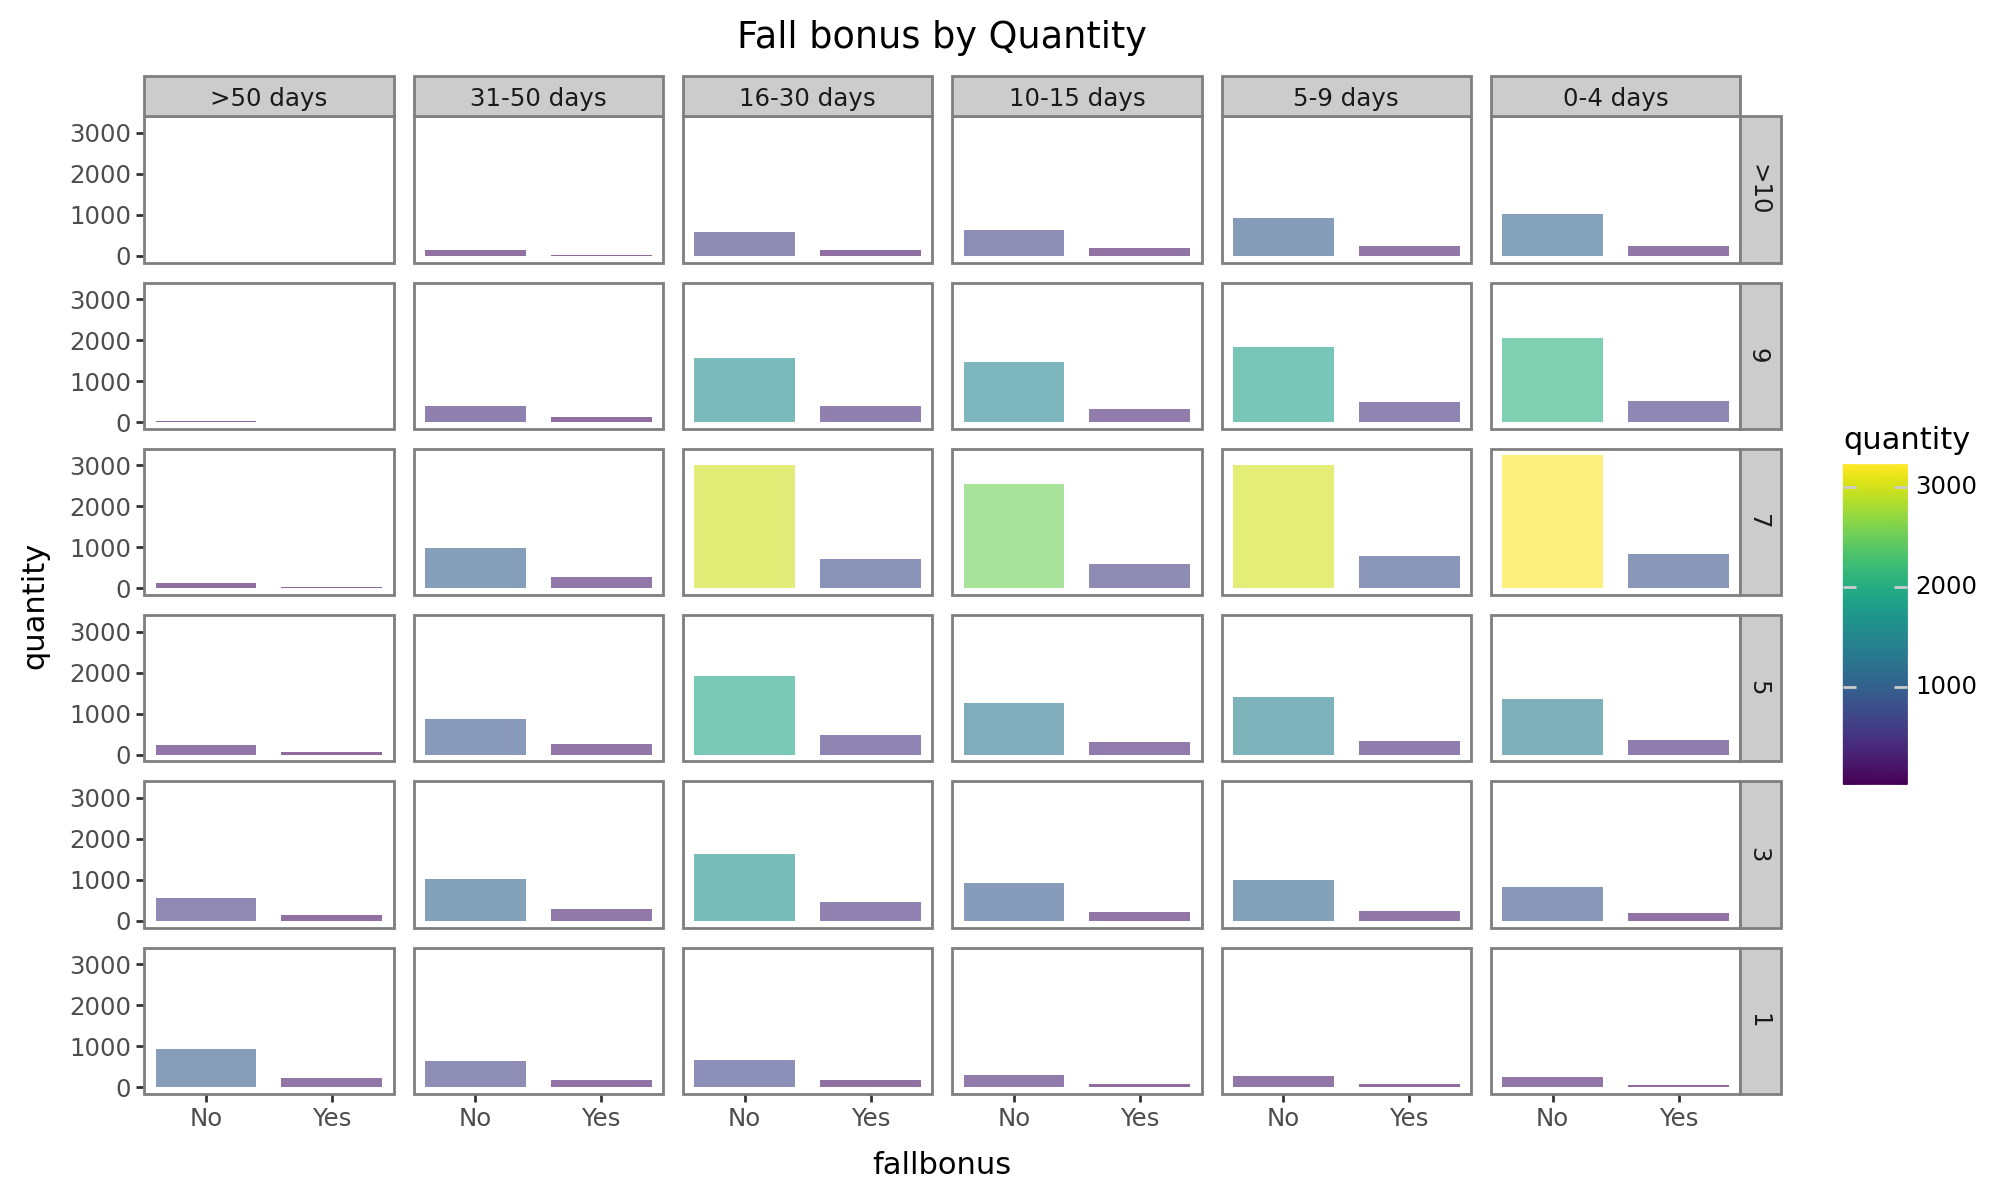

In [64]:
# Fall bonus with Quantity

Grids_data['lcgfb']= segmented['summer_custsegm'].groupby(['fallbonus','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID', 'count'),
                                                                                                                              monetaryvalue=('MonetaryValue', 'sum'),
                                                                                                                               meanmonetaryvalue=('MonetaryValue', 'mean'),
                                                                                                                              clv=('CLV', 'sum'))
Grids_data['lcgfb']['player']='player'

Grids["Fall bonus by Quantity"] = (ggplot(Grids_data['lcgfb'], aes(x='fallbonus', y='quantity', fill='quantity')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by Quantity"))

Grids["Fall bonus by Quantity"].show()

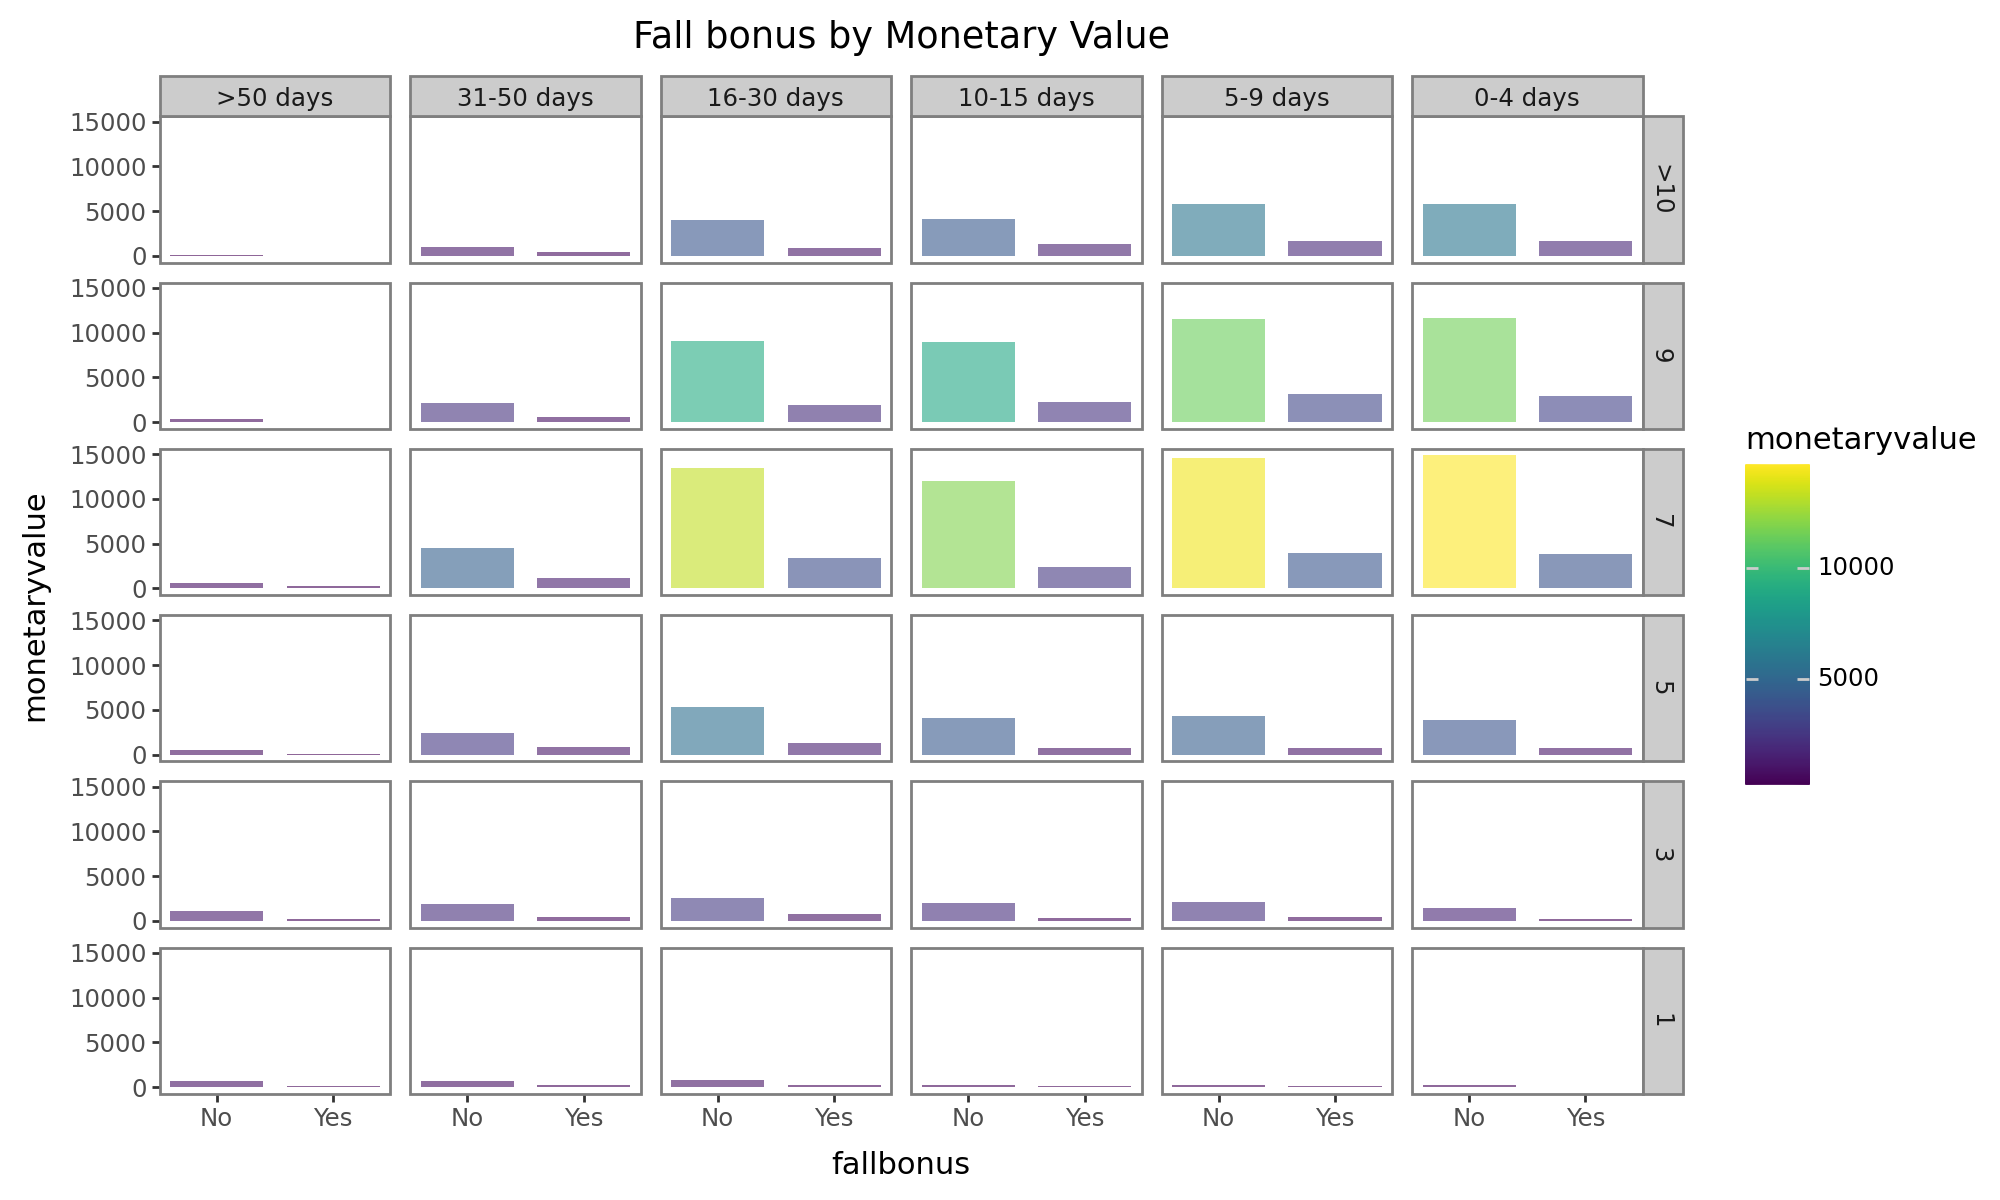

In [65]:
# Fall bonus with Monetary Value (mean)

Grids['Fall bonus by Monetary Value'] = (ggplot(Grids_data['lcgfb'], aes(x='fallbonus', y='monetaryvalue', fill='monetaryvalue')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by Monetary Value"))

Grids['Fall bonus by Monetary Value'].show()

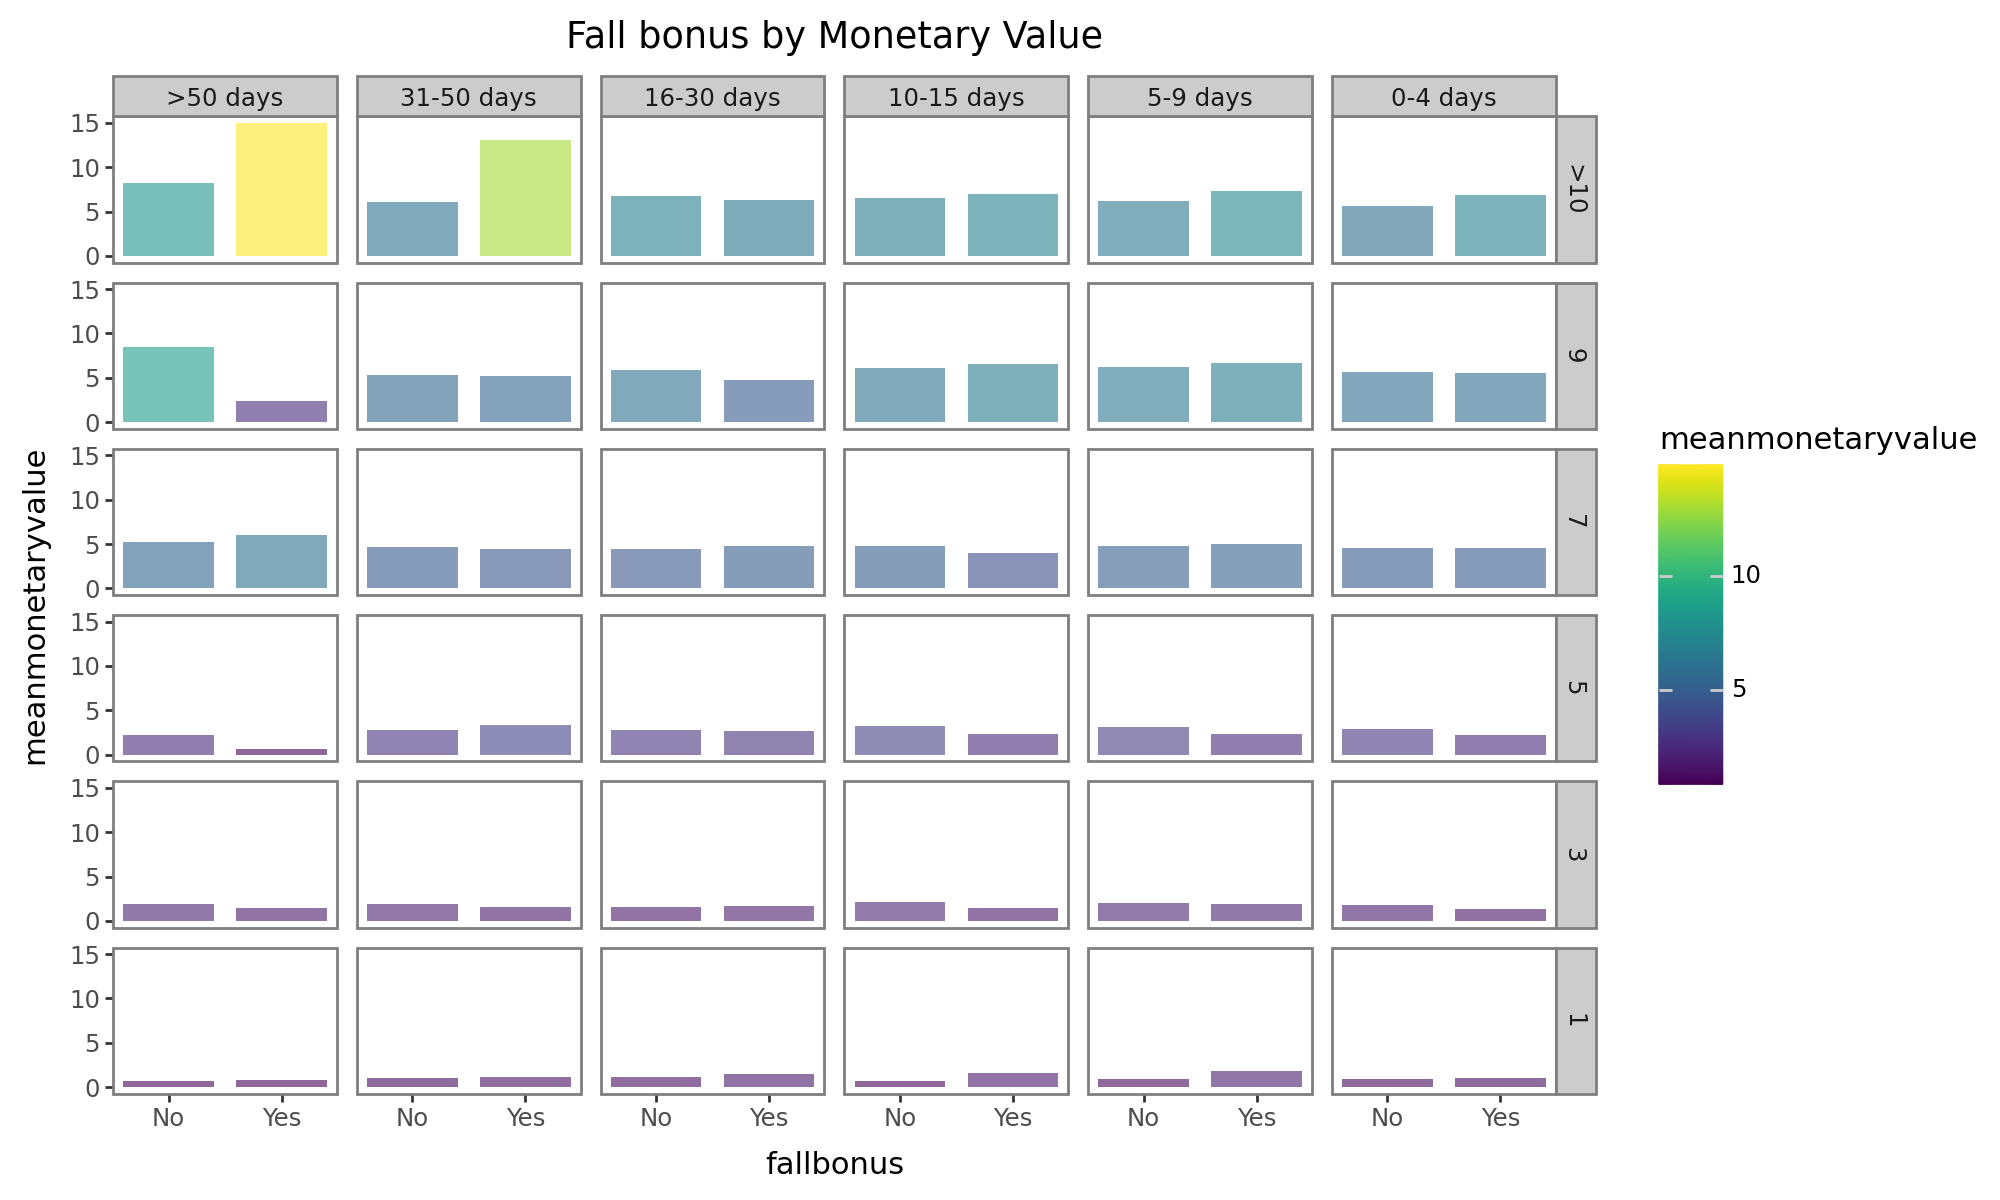

In [66]:
# Fall bonus with Monetary Value (mean)

Grids['Fall bonus by mean Monetary Value'] = (ggplot(Grids_data['lcgfb'], aes(x='fallbonus', y='meanmonetaryvalue', fill='meanmonetaryvalue')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by Monetary Value"))

Grids['Fall bonus by mean Monetary Value'].show()

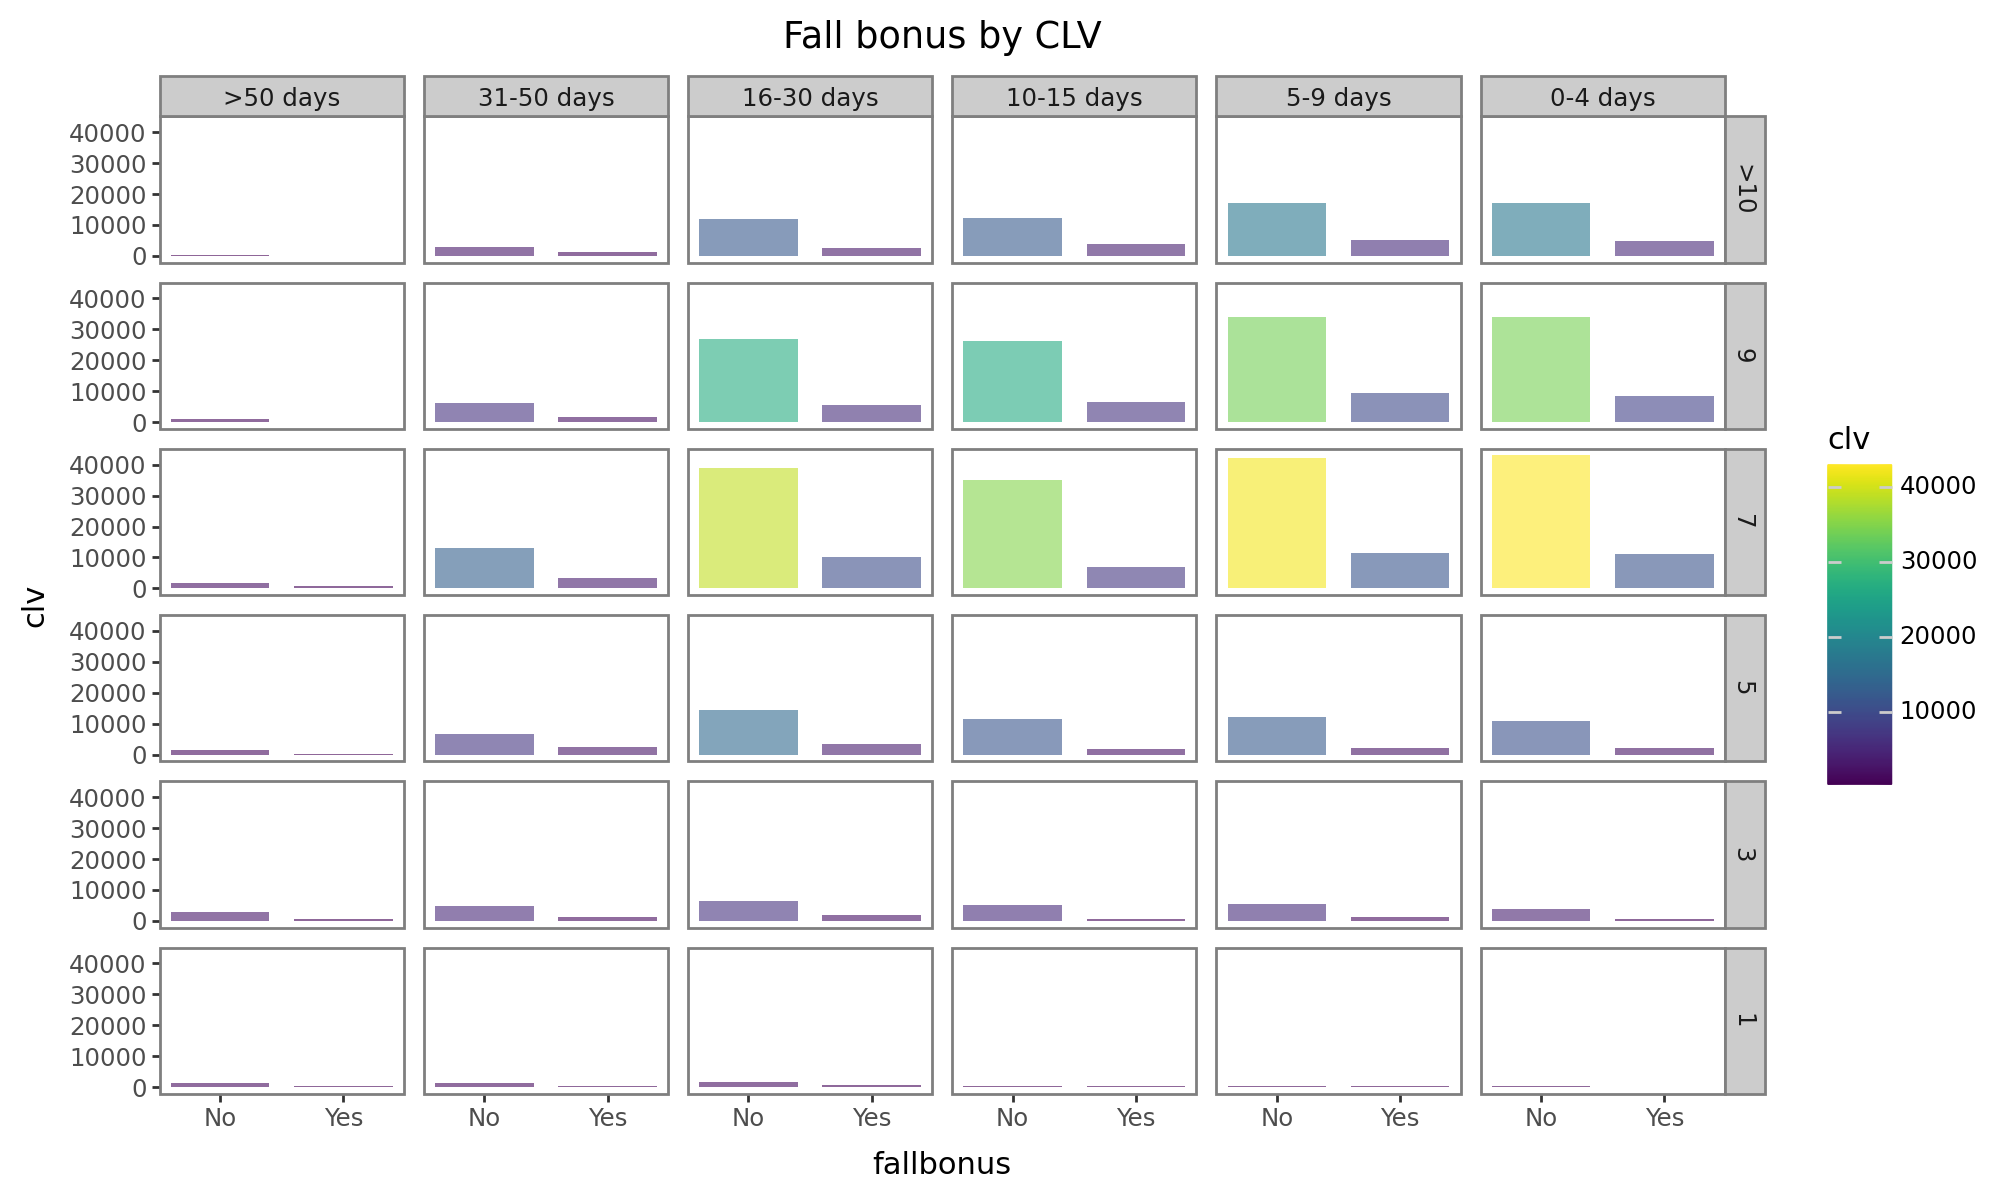

In [67]:
# Fall bonus by CLV
Grids["Fall bonus by CLV"] = (ggplot(Grids_data['lcgfb'], aes(x='fallbonus', y='clv', fill='clv')) +
         theme_bw() +  # Black and white theme
         theme(panel_grid=element_blank(),  # Remove background grid
               figure_size=(10, 6),  # Adjust the overall size of the plot
               axis_text_x=element_text(rotation=0)) +  # Rotate x-axis labels if needed
         geom_bar(stat='identity', alpha=0.6, width=0.8) +  # Increase bar width
         facet_grid('segmfreq ~ segmrec') +  # Adjust space based on content
         scale_x_continuous(breaks=[0, 1], labels=["No", "Yes"]) +
         ggtitle("Fall bonus by CLV"))

Grids["Fall bonus by CLV"].show()

# Churn Analysis

This question focuses on understanding churn in the fall period. Niantic defines churn as a person that played and paid for at least 1 microtransaction in the summer period but does not perform any microtransactions (not paying) during the fall of 2022 According to this definition, calculate which customers have churned in the fall using the fall databases.

## Complete Churner

We identify a player as a complete churner when he makes a purchase in summer but he doesn't repeat this action in fall

In [68]:
data['summerfintrx']

TransactionID       Date  CustomerID  ProductID  SessionID  Value
0                  1 2022-08-06           4          1         21   4.99
1                  2 2022-06-23           8          0         45   2.99
2                  3 2022-06-12           9          1         54   4.99
3                  4 2022-07-23          24          3        170  25.00
4                  5 2022-06-22          24          2        177   9.99
...              ...        ...         ...        ...        ...    ...
21897          21898 2022-05-21       49993          0     379210   2.99
21898          21899 2022-07-20       49993          0     379212   2.99
21899          21900 2022-07-23       49995          0     379225   2.99
21900          21901 2022-06-11       49998          1     379247   4.99
21901          21902 2022-06-24       49998          1     379249   4.99

[21902 rows x 6 columns]

In [69]:
data['fallfintrx']

TransactionID       Date  CustomerID  ProductID  SessionID  Value
0                  1 2022-11-12           4          3         15  25.00
1                  2 2022-09-29           4          1         18   4.99
2                  3 2022-10-09           8          2         35   9.99
3                  4 2022-11-09           9          1         42   4.99
4                  5 2022-12-08          24          2        142   9.99
...              ...        ...         ...        ...        ...    ...
16246          16247 2022-11-06       49980          0     299075   2.99
16247          16248 2022-09-24       49980          0     299079   2.99
16248          16249 2022-10-18       49992          1     299140   4.99
16249          16250 2022-09-29       49992          0     299141   2.99
16250          16251 2022-10-16       49998          3     299171  25.00

[16251 rows x 6 columns]

In [70]:
# We create a dataframe in which we will hold the information regarding churn
analysis['churn'] = data['summerfintrx'].groupby('CustomerID', as_index=False).agg(
    summer_trx_flag=('TransactionID', lambda x: 1 if x.sum() > 0 else 0)).merge(
    data['fallfintrx'].groupby('CustomerID', as_index=False).agg(
        fall_trx_flag=('TransactionID', lambda x: 1 if x.sum() > 0 else 0)),
    how='left', on='CustomerID').fillna(0)

# Complete churn = 1 if summer_trx_flag = 1 and fall_trx_flag = 0, otherwise 0
analysis['churn']['churn'] = analysis['churn'].apply(
    lambda x: 1 if x.summer_trx_flag == 1 and x.fall_trx_flag == 0 else 0, axis=1)

analysis['churn']

CustomerID  summer_trx_flag  fall_trx_flag  churn
0               4                1            1.0      0
1               8                1            1.0      0
2               9                1            1.0      0
3              24                1            1.0      0
4              30                1            0.0      1
...           ...              ...            ...    ...
17165       49983                1            0.0      1
17166       49992                1            1.0      0
17167       49993                1            0.0      1
17168       49995                1            0.0      1
17169       49998                1            1.0      0

[17170 rows x 4 columns]

How many total churner we have?

In [71]:
analysis['churn_count'] = analysis['churn']['churn'].sum()
analysis['churn_percentage'] = (analysis['churn_count'] / len(analysis['churn'])) * 100
print(f"The number of churned customers is: {analysis['churn_count']}")
print(f"The percentage of churned customers is: {analysis['churn_percentage']:.2f}%")

The number of churned customers is: 5172
The percentage of churned customers is: 30.12%


Now we want to understand how many people churn even though they received the fall bonus!

In [72]:
analysis['churn']

CustomerID  summer_trx_flag  fall_trx_flag  churn
0               4                1            1.0      0
1               8                1            1.0      0
2               9                1            1.0      0
3              24                1            1.0      0
4              30                1            0.0      1
...           ...              ...            ...    ...
17165       49983                1            0.0      1
17166       49992                1            1.0      0
17167       49993                1            0.0      1
17168       49995                1            0.0      1
17169       49998                1            1.0      0

[17170 rows x 4 columns]

In [73]:
# Add fall_bonus
analysis['churn'] = analysis['churn'].merge(data['customerdata'][['CustomerID', 'fallbonus']], how='left', on='CustomerID').fillna(0)

# churn_with_bonus = 1 if both churn and fallbonus are 1, otherwise 0
analysis['churn']['churn_with_bonus'] = analysis['churn'].apply(lambda x: 1 if x.churn == 1 and x.fallbonus == 1 else 0, axis=1)

# people with bonus churning
analysis['churnbonus_count'] = analysis['churn']['churn_with_bonus'].sum()

print(f"The number of churned customers even though they received the bonus is: {analysis['churnbonus_count']}")
analysis['churn']

The number of churned customers even though they received the bonus is: 834


CustomerID  summer_trx_flag  fall_trx_flag  churn  fallbonus  \
0               4                1            1.0      0          0   
1               8                1            1.0      0          1   
2               9                1            1.0      0          1   
3              24                1            1.0      0          0   
4              30                1            0.0      1          0   
...           ...              ...            ...    ...        ...   
17165       49983                1            0.0      1          0   
17166       49992                1            1.0      0          1   
17167       49993                1            0.0      1          0   
17168       49995                1            0.0      1          0   
17169       49998                1            1.0      0          1   

       churn_with_bonus  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
17165                 0  
17166                 0  
17167                 0  
17168                 0  
17169                 0  

[17170 rows x 6 columns]

## Partial Churner

Partial churners are customers who have not completely left our company but are gradually reducing their spending or showing signs of declining interest in our product over time. These customers should be a key focus, as fully churned customers are already lost. With the right churn prevention strategy, we have a valuable opportunity to re-engage and retain them.

In [74]:
analysis['spending_customers'] = pd.DataFrame({'CustomerID' : data['summerfintrx']['CustomerID'].unique()}) #we begin by finding the different IDs of the customers who bought something in the summer

# Then we add the total spending for each CustomerID in summer and fall to this dataframe
analysis['spending_customers']=analysis['spending_customers'].merge(
    data['summerfintrx'].groupby('CustomerID', as_index=False).agg(summer_spending=('Value', 'sum')), how='left' ,on='CustomerID')

analysis['spending_customers']=analysis['spending_customers'].merge(
    data['fallfintrx'].groupby('CustomerID',as_index=False).agg(fall_spending = ('Value', 'sum')), how='left', on='CustomerID').fillna(0)

analysis['spending_customers']

CustomerID  summer_spending  fall_spending
0               4             4.99          29.99
1               8             2.99           9.99
2               9             4.99           4.99
3              24            34.99          34.99
4              30             9.99           0.00
...           ...              ...            ...
17165       49983             4.99           0.00
17166       49992             9.99           7.98
17167       49993             8.97           0.00
17168       49995             2.99           0.00
17169       49998             9.98          25.00

[17170 rows x 3 columns]

In [75]:
# partial churn = 1 if summer spending is greater than fall spending, 0 otherwise
analysis['spending_customers']['partial_churn'] = analysis['spending_customers'].apply(lambda x: 1 if x.summer_spending > x.fall_spending else 0, axis=1)

analysis['spending_customers']

CustomerID  summer_spending  fall_spending  partial_churn
0               4             4.99          29.99              0
1               8             2.99           9.99              0
2               9             4.99           4.99              0
3              24            34.99          34.99              0
4              30             9.99           0.00              1
...           ...              ...            ...            ...
17165       49983             4.99           0.00              1
17166       49992             9.99           7.98              1
17167       49993             8.97           0.00              1
17168       49995             2.99           0.00              1
17169       49998             9.98          25.00              0

[17170 rows x 4 columns]

How many partial churner we have?

In [76]:
analysis['partial_churn_count'] = (analysis['spending_customers']['partial_churn'].sum()) - (analysis['churn_count'])
analysis['partial_churn_percentage'] = (analysis['partial_churn_count'] / len(analysis['spending_customers'])) * 100
print(f"The number of partial churned customers is: {analysis['partial_churn_count']}")
print(f"The percentage of churned customers is: {analysis['partial_churn_percentage']:.2f}%")

The number of partial churned customers is: 4991
The percentage of churned customers is: 29.07%


# Preparation Steps for Churn Prediction

In [77]:
analysis['churn']

CustomerID  summer_trx_flag  fall_trx_flag  churn  fallbonus  \
0               4                1            1.0      0          0   
1               8                1            1.0      0          1   
2               9                1            1.0      0          1   
3              24                1            1.0      0          0   
4              30                1            0.0      1          0   
...           ...              ...            ...    ...        ...   
17165       49983                1            0.0      1          0   
17166       49992                1            1.0      0          1   
17167       49993                1            0.0      1          0   
17168       49995                1            0.0      1          0   
17169       49998                1            1.0      0          1   

       churn_with_bonus  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
17165                 0  
17166                 0  
17167                 0  
17168                 0  
17169                 0  

[17170 rows x 6 columns]

In [78]:
# Ensure CustomerID is numeric in all datasets before merging
#analysis['churn']['CustomerID'] = analysis['churn']['CustomerID'].astype(int)

#analysis['spending_customers']['CustomerID'] = analysis['spending_customers']['CustomerID'].astype(int)

#segmented['summer_custsegm']['CustomerID'] = segmented['summer_custsegm']['CustomerID'].astype(int)

# Merge churn-related columns into basetable_summerC
analysis['regression_info'] = segmented['summer_custsegm'].merge(
    analysis['churn'][['CustomerID', 'churn', 'churn_with_bonus']],
    how='inner',
    on='CustomerID'
).merge(
    analysis['spending_customers'][['CustomerID', 'partial_churn']],
    how='inner',
    on='CustomerID'
).merge(
    data['summersesstrx'].groupby('CustomerID', as_index=False).agg(
    Distance=('Distance','sum'),
    Duration=('Duration','sum'),
    Experience=('Experience','sum')),
    how='inner',
    on='CustomerID'
)

analysis['regression_info']['Income'] = analysis['regression_info']['Income'].replace({'Low':0, 'Medium':1, 'High':2})
analysis['regression_info']['Income']= analysis['regression_info']['Income'].astype(int)

# Display the final merged dataset
analysis['regression_info'].columns

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\158887797.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\158887797.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


Index(['CustomerID', 'frequency', 'recency', 'CustomerType',
       'Registrationdate', 'Gender', 'Age', 'fallbonus', 'Income',
       'MonetaryValue', 'age_group', 'segmfreq', 'segmrec', 'segmage',
       'spending_cat', 'cohort', 'spending', 'CLV', 'churn',
       'churn_with_bonus', 'partial_churn', 'Distance', 'Duration',
       'Experience'],
      dtype='object')

# Descriptive Statistics for Churner

In [79]:
analysis['churn_by_types'] = analysis['regression_info'].groupby('CustomerType', as_index=False).agg(
    total_customers=('CustomerID', 'nunique'),
    churn_count=('churn', 'sum')
)

# Calculate the churn rate as a percentage for each CustomerType
analysis['churn_by_types']['churn_rate'] = (analysis['churn_by_types']['churn_count'] / analysis['churn_by_types']['total_customers']) * 100

# Display the churn rate by customer type
analysis['churn_by_types']

CustomerType  total_customers  churn_count  churn_rate
0        Catcher             4162          916   22.008650
1  Miscellaneous             2812          709   25.213371
2  Social Raider             7090         2830   39.915374
3         Walker             3106          717   23.084353

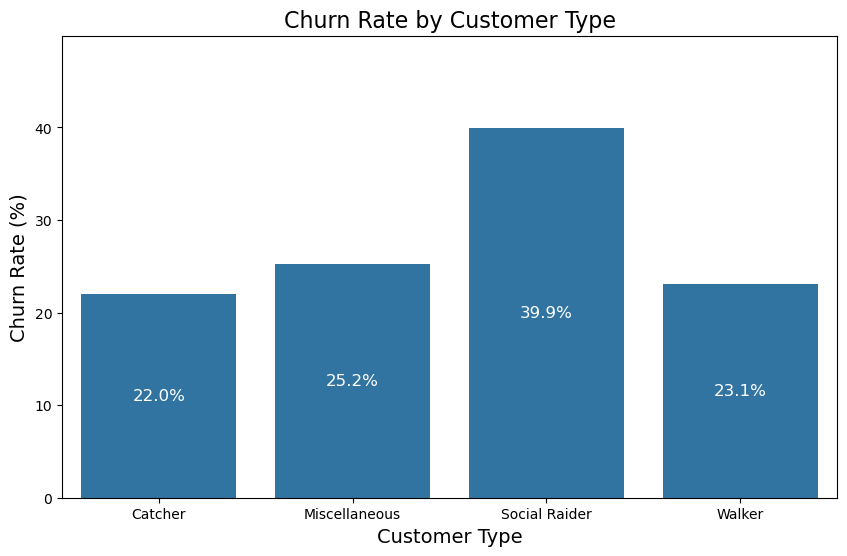

In [80]:
# bar plot for churn rate by customer type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=analysis['churn_by_types'].CustomerType.astype(str), y=analysis['churn_by_types']['churn_rate'])

# Add labels inside each bar, centered both horizontally and vertically
for i, rate in enumerate(analysis['churn_by_types']['churn_rate']):
    ax.text(i, rate / 2, f"{rate:.1f}%", ha='center', va='center', color='white', fontsize=12)

plt.xlabel('Customer Type', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.title('Churn Rate by Customer Type', fontsize=16)
plt.ylim(0, analysis['churn_by_types']['churn_rate'].max() + 10)
plt.show()

In [81]:
# Display basic descriptive statistics for numerical variables (Age, Income)
print("Descriptive Statistics for Churners (Age & Income):")
print(analysis['regression_info'][analysis['regression_info']['churn'] == 1][['Age','Income']].describe())

Descriptive Statistics for Churners (Age & Income):
               Age       Income
count  5172.000000  5172.000000
mean     27.839714     0.666087
std      13.883707     0.797687
min       6.000000     0.000000
25%      18.000000     0.000000
50%      28.000000     0.000000
75%      34.000000     1.000000
max      80.000000     2.000000


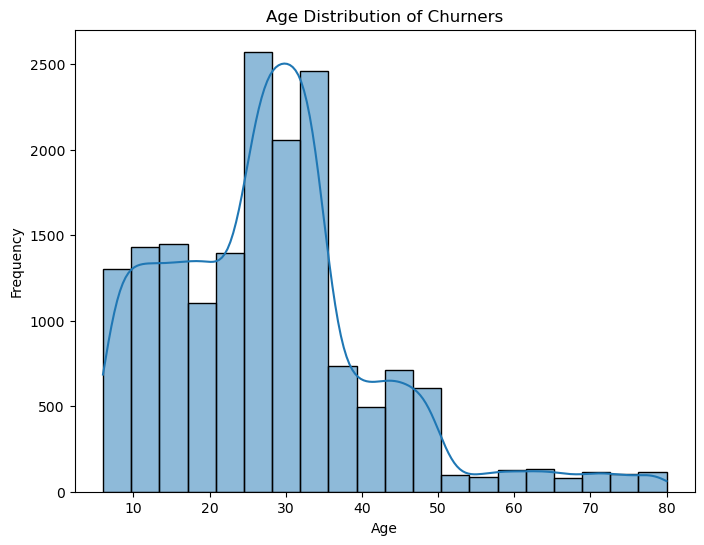

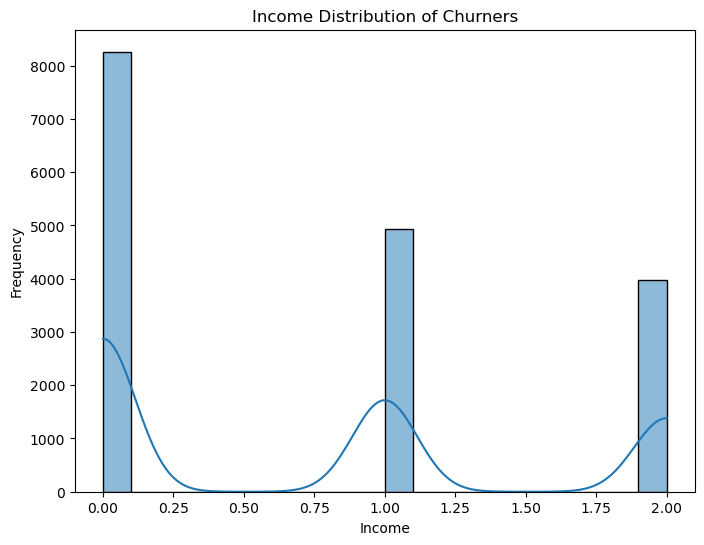

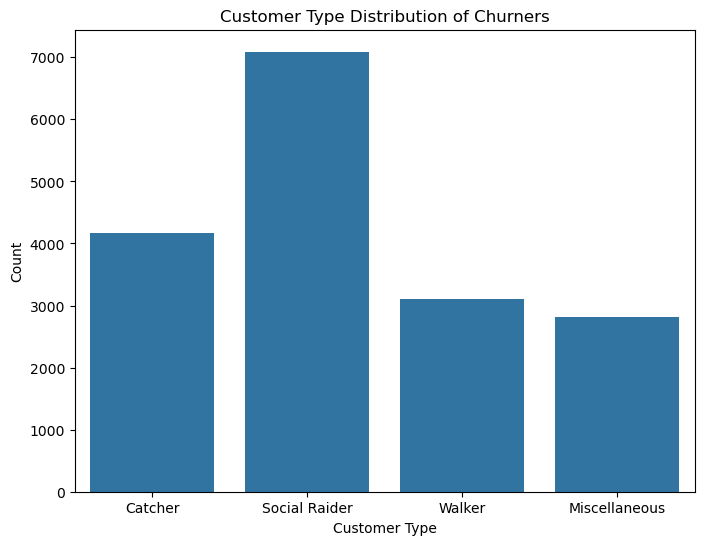

In [82]:
# Age distribution of churners
plt.figure(figsize=(8,6))
sns.histplot(analysis['regression_info']['Age'], bins=20, kde=True)
plt.title("Age Distribution of Churners")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Income distribution of churners
plt.figure(figsize=(8,6))
sns.histplot(analysis['regression_info']['Income'], bins=20, kde=True)
plt.title("Income Distribution of Churners")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()

# CustomerType distribution of churners
plt.figure(figsize=(8,6))
sns.countplot(data=analysis['regression_info'], x='CustomerType')
plt.title("Customer Type Distribution of Churners")
plt.xlabel("Customer Type")
plt.ylabel("Count")
plt.show()

# Churn Analysis and Predictions

In [83]:
# Preparing the basetable for logistic regression
analysis['regression_info']=pd.get_dummies(analysis['regression_info'], prefix=None, drop_first=True)
analysis['regression_info'] = analysis['regression_info'].replace({True:1, False:0})
analysis['regression_info']['CustomerType_SocialRaider'] = analysis['regression_info']['CustomerType_Social Raider']

# Check the data types of all variables in the dataset
print(analysis['regression_info'].dtypes)

CustomerID                             int64
frequency                              int64
recency                                int32
Registrationdate              datetime64[ns]
Age                                    int64
fallbonus                              int64
Income                                 int32
MonetaryValue                        float64
cohort                                 int32
spending                               int32
CLV                                  float64
churn                                  int64
churn_with_bonus                       int64
partial_churn                          int64
Distance                             float64
Duration                             float64
Experience                             int64
CustomerType_Miscellaneous             int64
CustomerType_Social Raider             int64
CustomerType_Walker                    int64
Gender_Male                            int64
age_group_18-27                        int64
age_group_

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\708969920.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [84]:
# Convert specific columns from float to integers
analysis['regression_info']['MonetaryValue'] = analysis['regression_info']['MonetaryValue'].astype(int)
analysis['regression_info']['CLV'] = analysis['regression_info']['CLV'].astype(int)

In [85]:
analysis['regression_info'].columns

Index(['CustomerID', 'frequency', 'recency', 'Registrationdate', 'Age',
       'fallbonus', 'Income', 'MonetaryValue', 'cohort', 'spending', 'CLV',
       'churn', 'churn_with_bonus', 'partial_churn', 'Distance', 'Duration',
       'Experience', 'CustomerType_Miscellaneous',
       'CustomerType_Social Raider', 'CustomerType_Walker', 'Gender_Male',
       'age_group_18-27', 'age_group_28-37', 'age_group_38-49',
       'age_group_50-80', 'segmfreq_9', 'segmfreq_7', 'segmfreq_5',
       'segmfreq_3', 'segmfreq_1', 'segmrec_31-50 days', 'segmrec_16-30 days',
       'segmrec_10-15 days', 'segmrec_5-9 days', 'segmrec_0-4 days',
       'segmage_18-27', 'segmage_28-37', 'segmage_38-49', 'segmage_50-80',
       'spending_cat_L', 'spending_cat_M', 'spending_cat_H', 'spending_cat_VH',
       'CustomerType_SocialRaider'],
      dtype='object')

In [86]:
# Logistic regression

# split into test and train
logit = {'train' : train_test_split(analysis['regression_info'], test_size=0.3,random_state=1)[0],
        'test' : train_test_split(analysis['regression_info'], test_size=0.3,random_state=1)[1]}

# use the professor stepwise function to determine the final model

X=logit['train'][['frequency', 'MonetaryValue', 'Age', 'Income', 'Gender_Male', 'CustomerType_Miscellaneous', 'CustomerType_SocialRaider', 'CustomerType_Walker', 'Experience', 'cohort']]
Y=logit['train']['churn']
forward=forwardSelection(X, Y,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
forward[2].summary()
backward=backwardSelection(X, Y,model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
backward[2].summary()
bidirectional=BidirectionalStepwiseSelection(X,Y,model_type="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst",senter=0.05, sstay=0.05)
bidirectional[2].summary()

logit['Xtrain']=logit['train'][np.intersect1d(logit['train'].columns,forward[0])] # only select var retained from backbward selection
logit['Xtrain']=logit['Xtrain'].reindex(columns=forward[0]) # sort them according to the sequence used in the regression
logit['Xtrain']['intercept']=1 # add constant variable
logit['train']['predict']=forward[2].predict(logit['Xtrain']) # store prediction in corresponding dataset

logit['Xtest']=logit['test'][np.intersect1d(logit['test'].columns,forward[0])] # only select var retained from backbward selection
logit['Xtest']=logit['Xtest'].reindex(columns=forward[0]) # sort them according to the sequence used in the regression
logit['Xtest']['intercept']=1 # add constant variable
logit['test']['predict']=forward[2].predict(logit['Xtest']) # store prediction in corresponding dataset

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.608684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605885
         Iterations 5
Optimization te

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Optimization terminated successfully.
         Current function value: 0.592656
         Iterations 5
Entered : CustomerType_SocialRaider 	AIC : 14250.25957694765
Optimization terminated successfully.
         Current function value: 0.592468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592575
         Iterations 5


C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Optimization terminated successfully.
         Current function value: 0.591758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591758
         Iterations 6
Entered : cohort 	AIC : 14230.667800592655
Optimization terminated successfully.
         Current function value: 0.590847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 6
Optimization terminated successfully.
 

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Entered : frequency 	AIC : 14210.773181765275
Optimization terminated successfully.
         Current function value: 0.590796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7


C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Entered : CustomerType_Miscellaneous 	AIC : 14208.605428714354
Optimization terminated successfully.
         Current function value: 0.590625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590592
         Iterations 7
Break : Significance Level
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7


C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                12019
Model:                          Logit   Df Residuals:                    12014
Method:                           MLE   Df Model:                            4
Date:                Wed, 26 Feb 2025   Pseudo R-squ.:                 0.02959
Time:                        22:10:34   Log-Likelihood:                -7099.3
converged:                       True   LL-Null:                       -7315.8
Covariance Type:            nonrobust   LLR p-value:                 2.104e-92
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   -175.9290     30.003     -5.864      0.000    -234.734    -117.124
CustomerType_SocialRaider      0.7773      0.048     16.283      0.000       0.684 

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

Optimization terminated successfully.
         Current function value: 0.606632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592656
         Iterations 5
break : No need to Backward Elimination
Entered : CustomerType_SocialRaider 	AIC : 14250.25957694765
Optimization terminated successfully.
         Current function value: 0.592468
   

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Optimization terminated successfully.
         Current function value: 0.590847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590847
         Iterations 7


C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


break : No need to Backward Elimination
Entered : frequency 	AIC : 14210.773181765275
Optimization terminated successfully.
         Current function value: 0.590796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590826
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7


C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


break : No need to Backward Elimination
Entered : CustomerType_Miscellaneous 	AIC : 14208.605428714354
Optimization terminated successfully.
         Current function value: 0.590625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590592
         Iterations 7
Break : Significance Level
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                1201

The logistic regression model reveals several factors;

- Customers with a longer Duration are more likely to leave, suggesting that sustained engagement strategies are essential to be implemented

- Receiving a fallbonus lowers churn risk, confirming the value of seasonal promotions.

- CustomerTypes are prone to exit, indicating that targeted retention efforts should focus on these higher-risk segments.

- Recency shows that customers who have not interacted for a while are at greater risk of churning, while Experience implies that seasoned users may lose interest unless given new incentives.

- Frequency indicates that even frequent interactions can precede churn, underscoring the need for deeper, more personalized engagement rather than relying solely on high usage.

Cutoff used:  0.5
          Predicted 0  Predicted 1
Actual 0         8444            0
Actual 1         3575            0
Accuracy Score :  70.26
ROC AUC score :  61.36
Precision score :  0.0
sensitivity score :  0.0
specificity score :  100.0
<ggplot: (640 x 480)>
Cutoff used:  0.5
          Predicted 0  Predicted 1
Actual 0         3554            0
Actual 1         1597            0
Accuracy Score :  69.0
ROC AUC score :  62.05
Precision score :  0.0
sensitivity score :  0.0
specificity score :  100.0
<ggplot: (640 x 480)>
percentage churn in train dataset:  29.74
percentage churn in test dataset:  31.0


C:\Users\cedri\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\cedri\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


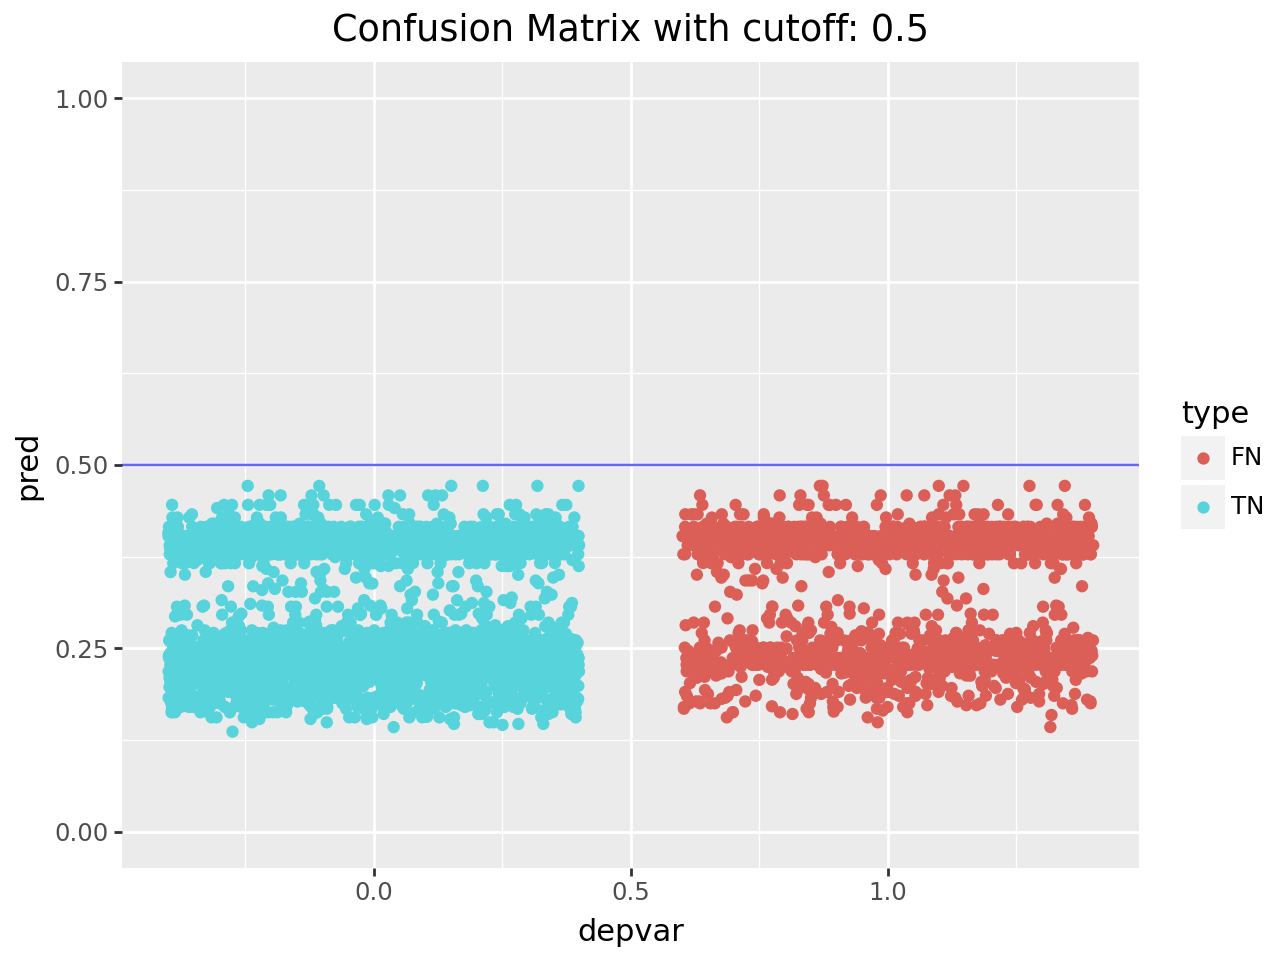

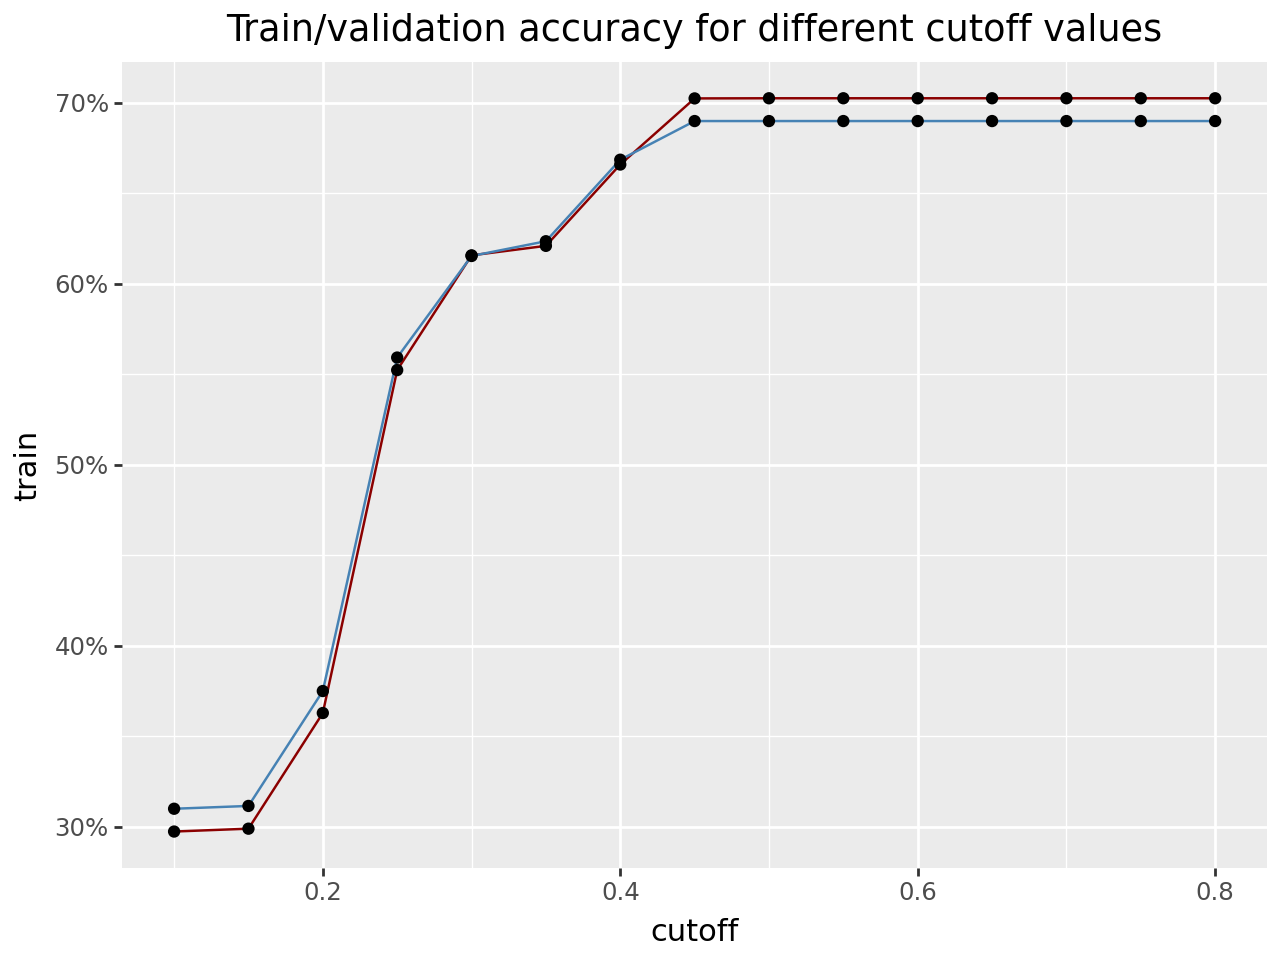

In [87]:
# performance with cutoff 0.5 just to initialize
logit['performance train']=evaluate_model(logit['train']['churn'],logit['train']['predict'])

logit['performance test']=evaluate_model(logit['test']['churn'],logit['test']['predict'])

print('percentage churn in train dataset: ',np.round(np.mean(logit['train']['churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(logit['test']['churn'])*100,2))

#confusion matrix for opt cutoff
confusionmatrixplot(logit['test']['churn'],logit['test']['predict'],cutoff=0.5)

#how does the accuracy change for different cutoff values
AccuracyCutoffInfo(logit['train'],logit['test'],depvar='churn',pred='predict')

In [88]:
logit['test']['churn']

2072     0
6612     0
14978    0
8705     1
13170    0
        ..
4906     0
15599    0
4021     0
4761     0
15550    1
Name: churn, Length: 5151, dtype: int64

In [89]:
logit['test']['predict']

2072     0.225784
6612     0.209801
14978    0.162695
8705     0.402943
13170    0.402943
           ...   
4906     0.227454
15599    0.201278
4021     0.415562
4761     0.182508
15550    0.402943
Name: predict, Length: 5151, dtype: float64

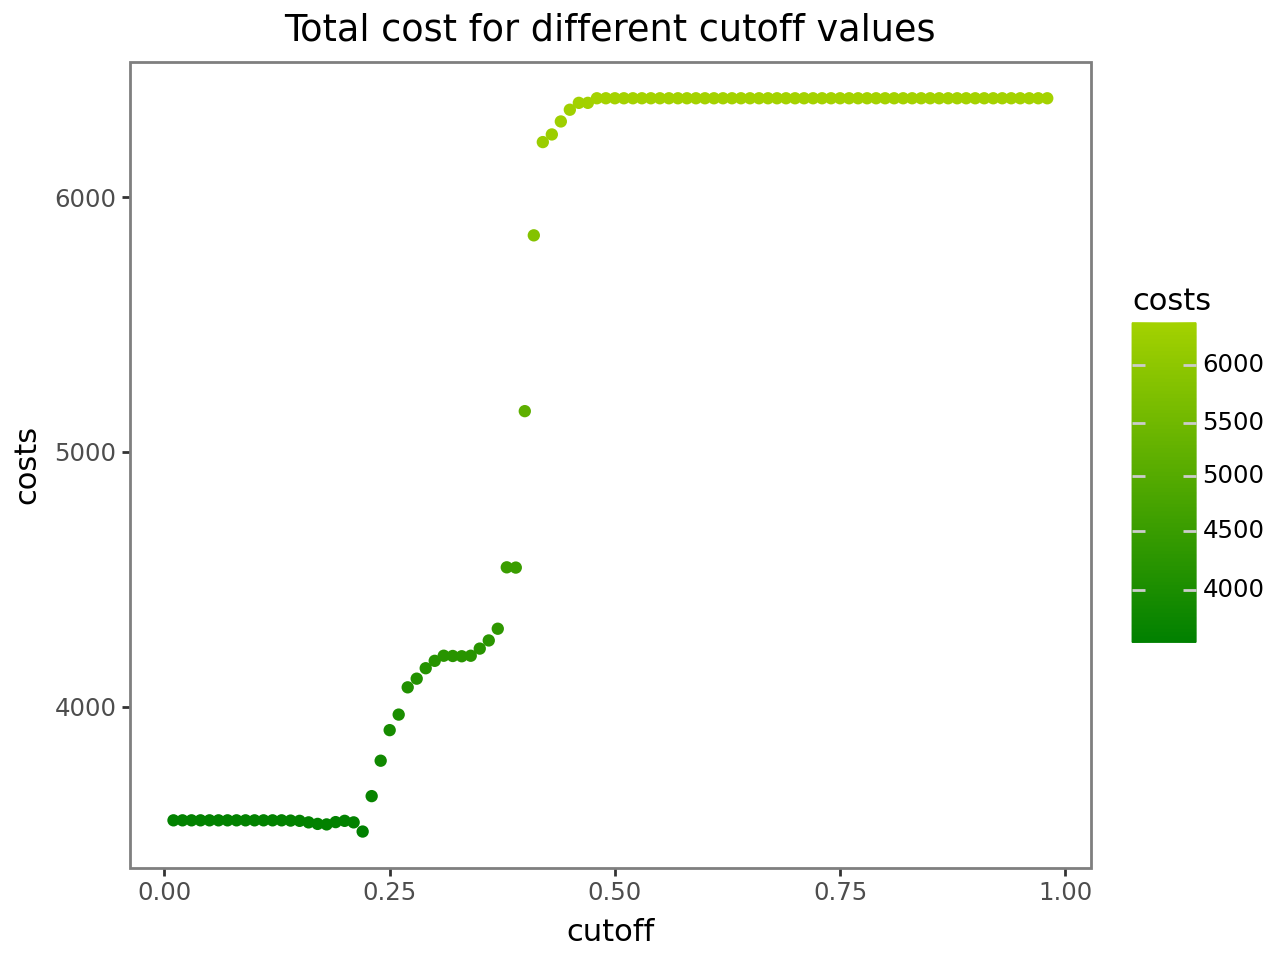

best cutoff:  0.22
Cutoff used:  0.22
          Predicted 0  Predicted 1
Actual 0          856         2698
Actual 1          203         1394
Accuracy Score :  43.68
ROC AUC score :  62.05
Precision score :  34.07
sensitivity score :  87.29
specificity score :  24.09
<ggplot: (640 x 480)>
percentage churn in train dataset:  29.74
percentage churn in test dataset:  31.0


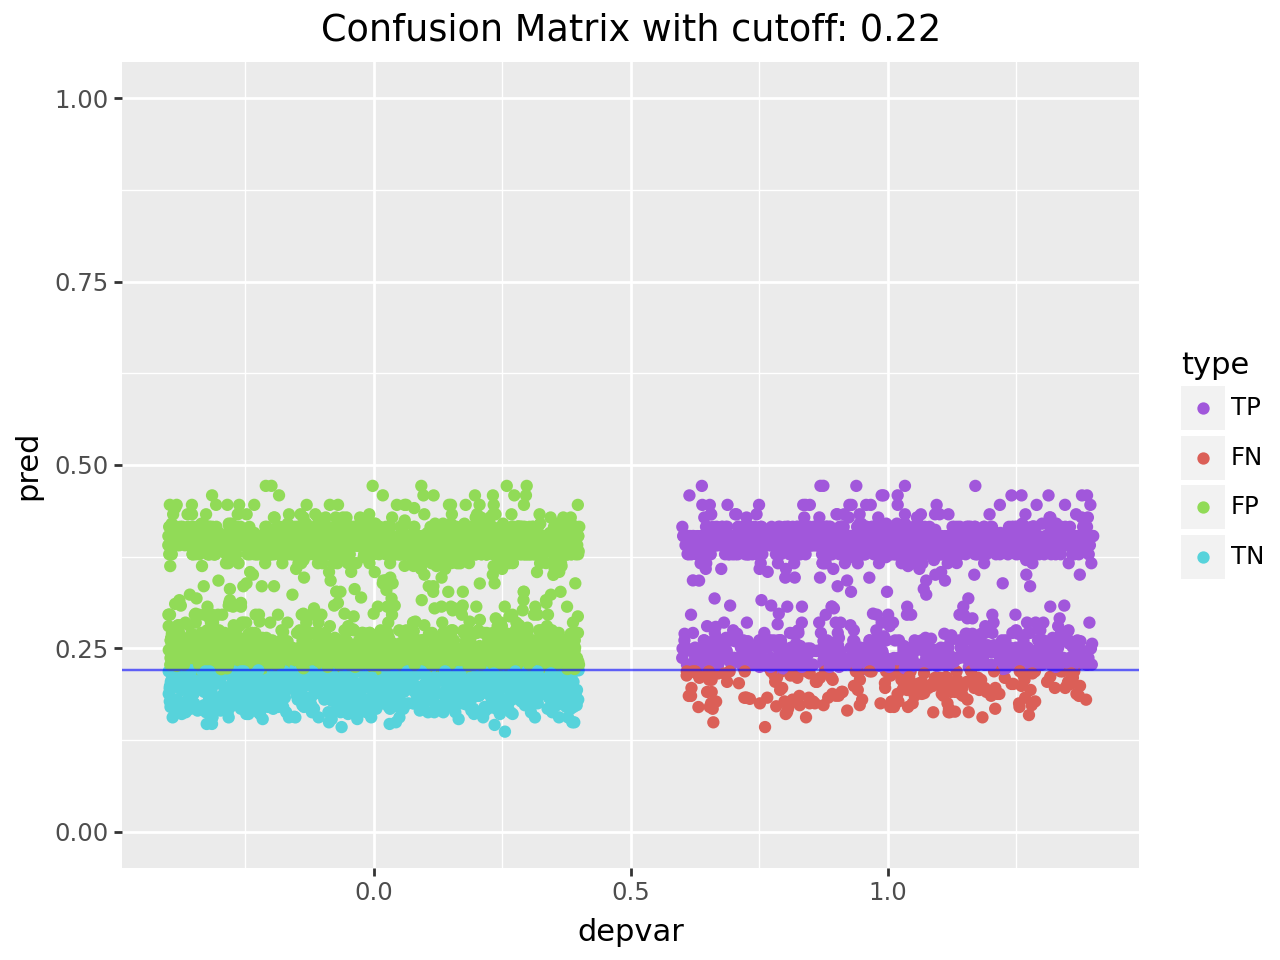

C:\Users\cedri\Anaconda\Lib\site-packages\plotnine\stats\smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


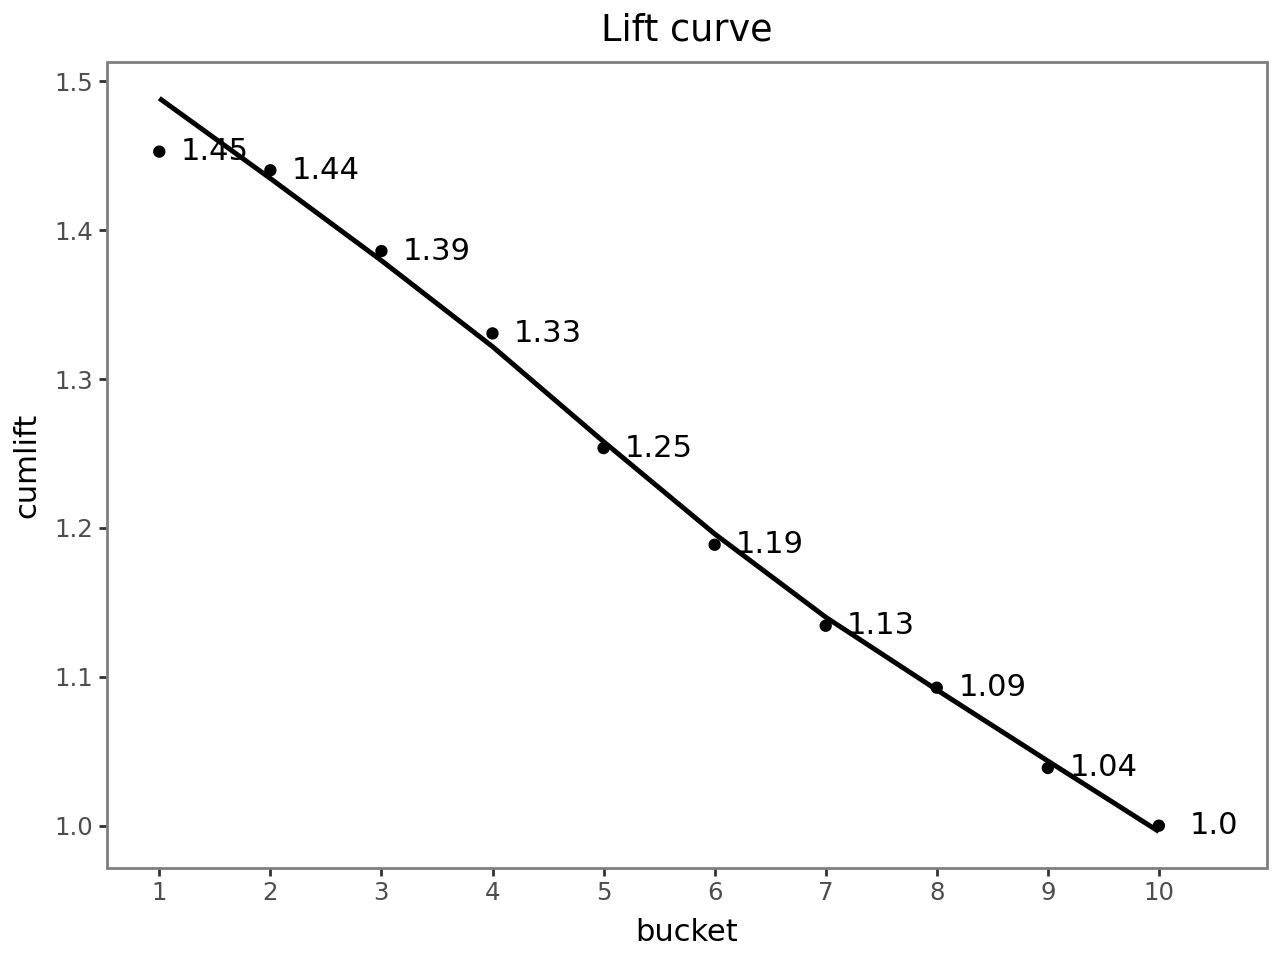

In [90]:
#find optimal cutoff to balance the accuracy
logit['optcutoff']=findoptcutoff(logit['test']['churn'],logit['test']['predict'])

# performance with optimal cutoff
logit['performance_optcutoff']=evaluate_model(logit['test']['churn'],logit['test']['predict'],cutoff=logit['optcutoff']) # we deleted the best cutoff because it gives us 0.01, meaning everyone is considered as a churner, selected 0.3 as cutoff based on the train/validation accuracy graph

print('percentage churn in train dataset: ',np.round(np.mean(logit['train']['churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(logit['test']['churn'])*100,2))

#confusion matrix for opt cutoff
confusionmatrixplot(logit['test']['churn'],logit['test']['predict'],cutoff=logit['optcutoff'])

lifttabletest=plot_liftchart(logit['test']['churn'],logit['test']['predict'])

This is the prediction with the optimal cutoff. We are assuming that the cost of providing a discoount is equal to the acquisition cost that is equal to 1.

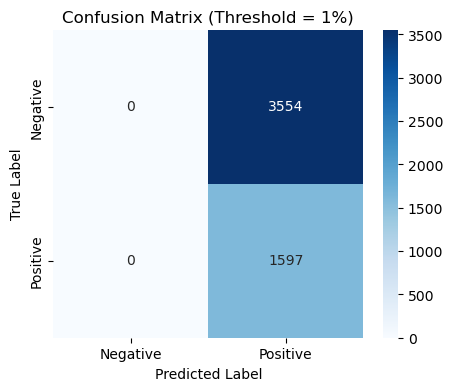

In [91]:
from sklearn.metrics import confusion_matrix

# Define threshold
logit['threshold'] = 0.01

# Convert probabilities to binary predictions based on threshold
logit['test']["pred"] = (logit['test']["predict"] >= logit['threshold']).astype(int)

# Compute confusion matrix
conf_mat = confusion_matrix(logit['test']["churn"], logit['test']["pred"])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Threshold = {logit['threshold']*100:.0f}%)")
plt.show()

At a 0.01 as optimal cutoff, almost everyone is flagged as a churner. This means the model catches all churners (100% recall) but mislabels every non-churner (0% specificity). We did this because we are providing a virtual product and in practice, the fallbonus costs us essentially nothing. In other words, it is optimal for us to consider every paying customer a potential churner for the sake of our marketing.

In [92]:
# The same analysis but only for SocialRaiders
analysis['SocialRaiders'] = analysis['regression_info'][analysis['regression_info']['CustomerType_SocialRaider']==1]
analysis['SocialRaiders'].columns

Index(['CustomerID', 'frequency', 'recency', 'Registrationdate', 'Age',
       'fallbonus', 'Income', 'MonetaryValue', 'cohort', 'spending', 'CLV',
       'churn', 'churn_with_bonus', 'partial_churn', 'Distance', 'Duration',
       'Experience', 'CustomerType_Miscellaneous',
       'CustomerType_Social Raider', 'CustomerType_Walker', 'Gender_Male',
       'age_group_18-27', 'age_group_28-37', 'age_group_38-49',
       'age_group_50-80', 'segmfreq_9', 'segmfreq_7', 'segmfreq_5',
       'segmfreq_3', 'segmfreq_1', 'segmrec_31-50 days', 'segmrec_16-30 days',
       'segmrec_10-15 days', 'segmrec_5-9 days', 'segmrec_0-4 days',
       'segmage_18-27', 'segmage_28-37', 'segmage_38-49', 'segmage_50-80',
       'spending_cat_L', 'spending_cat_M', 'spending_cat_H', 'spending_cat_VH',
       'CustomerType_SocialRaider'],
      dtype='object')

In [93]:
# split into test and train
logit['trainS'] = train_test_split(analysis['SocialRaiders'], test_size=0.3,random_state=1)[0]
logit['testS'] = train_test_split(analysis['SocialRaiders'], test_size=0.3,random_state=1)[1]

logit['XS'] = logit['trainS'][['frequency', 'MonetaryValue', 'Age', 'Income', 'Gender_Male', 'cohort', 'fallbonus', 'Experience']]
logit['YS'] = logit['trainS']['churn']
forwardS=forwardSelection(logit['XS'], logit['YS'],model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
forwardS[2].summary()
backwardS=backwardSelection(logit['XS'], logit['YS'],model_type ="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05)
backwardS[2].summary()
bidirectionalS=BidirectionalStepwiseSelection(logit['XS'],logit['YS'],model_type="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst",senter=0.05, sstay=0.05)
bidirectionalS[2].summary()

logit['XtrainS']=logit['trainS'][np.intersect1d(logit['train'].columns,forwardS[0])] # only select var retained from backbward selection
logit['XtrainS']=logit['XtrainS'].reindex(columns=forwardS[0]) # sort them according to the sequence used in the regression
logit['XtrainS']['intercept']=1 # add constant variable
logit['trainS']['predict']=forwardS[2].predict(logit['XtrainS']) # store prediction in corresponding dataset

logit['XtestS']=logit['testS'][np.intersect1d(logit['test'].columns,forwardS[0])] # only select var retained from backbward selection
logit['XtestS']=logit['XtestS'].reindex(columns=forwardS[0]) # sort them according to the sequence used in the regression
logit['XtestS']['intercept']=1 # add constant variable
logit['testS']['predict']=forwardS[2].predict(logit['XtestS']) # store prediction in corresponding dataset

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671972
         Iterations 4
Optimization te

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

Optimization terminated successfully.
         Current function value: 0.663173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662160
         Iterations 6
Entered : frequency 	AIC : 6580.60144029366
Optimization terminated successfully.
         Current function value: 0.661626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661626
         Iterations 6
Entered : MonetaryValue 	AIC : 6577.29

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
Entered : Experience 	AIC : 6574.461132368735
Optimization terminated successfully.
         Current function value: 0.661013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661064
         Iterations 6
Break : Significance Level
Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 4963
Model:                          Logit   Df Residuals:                     4957
Method:                           MLE   Df Model:                            5

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Eliminated : Income
Optimization terminated successfully.
         Current function value: 0.660935
         Iterations 6
Eliminated : Gender_Male
Optimization terminated successfully.
         Current function value: 0.661013
         Iterations 6
Eliminated : Age
Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
Final Variables: ['intercept', 'frequency', 'MonetaryValue', 'cohort', 'fallbonus', 'Experience']
Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671930
         Iterations 4


C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

Optimization terminated successfully.
         Current function value: 0.671414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665161
         Iterations 5
break : No need to Backward Elimination
Entered : fallbonus 	AIC : 6606.388832872817
Optimization terminated successfully.
         Current function value: 0.665092
         Iterations

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtype

Optimization terminated successfully.
         Current function value: 0.661551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
break : No need to Backward Elimination
Entered : Experience 	AIC : 6574.461132368735
Optimization terminated successfully.
         Current function value: 0.661013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661064
         Iterations 6
Break : Significance Level
Optimization terminated successfully.
         Current function value: 0.661139
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 4963
Model:         

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\2868078651.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


# Bonus

## Statistical Analyis on Fallbonus

In [94]:
from scipy.stats import chi2_contingency, ttest_ind

# 2. Check overall distribution of fallbonus
print("Distribution of fallbonus:")
print(segmented['summer_custsegm']['fallbonus'].value_counts(dropna=False))
print("\nPercentage distribution of fallbonus:")
print(segmented['summer_custsegm']['fallbonus'].value_counts(normalize=True, dropna=False) * 100)

Distribution of fallbonus:
fallbonus
0    39700
1    10063
Name: count, dtype: int64

Percentage distribution of fallbonus:
fallbonus
0    79.778148
1    20.221852
Name: proportion, dtype: float64


In [95]:
# 3. Descriptive statistics by fallbonus
#    For numeric columns like Age, Income, etc.
numeric_cols = ['Age', 'Income', 'CLV']  # Add or remove columns as 
print("\nDescriptive Statistics by fallbonus:")
segmented['summer_custsegm']['Income'] = pd.to_numeric(segmented['summer_custsegm']['Income'], errors='coerce')
analysis['fallbonus_stats'] = segmented['summer_custsegm'].groupby('fallbonus')[numeric_cols].agg(['mean', 'std'])
analysis['fallbonus_stats']


Descriptive Statistics by fallbonus:


Age            Income            CLV           
                mean        std   mean std       mean        std
fallbonus                                                       
0          27.824534  13.635174    NaN NaN  11.446831  33.245434
1          27.769552  13.640086    NaN NaN  11.290836  33.410822

In [96]:
# 4. Frequency analysis for a categorical variable (e.g., CustomerType)
#    Shows how many in each CustomerType got the bonus vs. not
print("\nFrequency of fallbonus by CustomerType:")
analysis['freq_ct'] = pd.crosstab(segmented['summer_custsegm']['CustomerType'], segmented['summer_custsegm']['fallbonus'])
print(analysis['freq_ct'])

print("\nFrequency of fallbonus by Gender:")
analysis['freq_ct'] = pd.crosstab(segmented['summer_custsegm']['Gender'], segmented['summer_custsegm']['fallbonus'])
print(analysis['freq_ct'])

print("\nFrequency of fallbonus by Incomce level:")
analysis['freq_ct'] = pd.crosstab(segmented['summer_custsegm']['Income'], segmented['summer_custsegm']['fallbonus'])
print(analysis['freq_ct'])


Frequency of fallbonus by CustomerType:
fallbonus          0     1
CustomerType              
Catcher        10392  2571
Miscellaneous   9444  2393
Social Raider  10709  2812
Walker          9155  2287

Frequency of fallbonus by Gender:
fallbonus      0     1
Gender                
Female     15824  4048
Male       23876  6015

Frequency of fallbonus by Incomce level:
Empty DataFrame
Columns: []
Index: []


In [97]:
# 5. T-tests for numeric variables (Age, Income) by fallbonus
#    Checks if the mean of Age/Income differs significantly between fallbonus=0 and fallbonus=1
for col in numeric_cols:
    group0 = segmented['summer_custsegm'].loc[segmented['summer_custsegm']['fallbonus'] == 0, col].dropna()
    group1 = segmented['summer_custsegm'].loc[segmented['summer_custsegm']['fallbonus'] == 1, col].dropna()
    if len(group0) > 1 and len(group1) > 1:  # Ensure there's enough data
        t_stat, p_val = ttest_ind(group0, group1)
        print(f"\nT-test for {col} by fallbonus:")
        print(f"p-value = {p_val:.4f}")
        if p_val < 0.05:
            print(f"=> The mean of {col} differs significantly between bonus receivers and non-receivers.")
        else:
            print(f"=> No significant difference in {col} for bonus receivers vs. non-receivers.")


T-test for Age by fallbonus:
p-value = 0.7179
=> No significant difference in Age for bonus receivers vs. non-receivers.

T-test for CLV by fallbonus:
p-value = 0.6745
=> No significant difference in CLV for bonus receivers vs. non-receivers.


In [98]:
segmented['summer_custsegm'].columns

Index(['CustomerID', 'frequency', 'recency', 'CustomerType',
       'Registrationdate', 'Gender', 'Age', 'fallbonus', 'Income',
       'MonetaryValue', 'age_group', 'segmfreq', 'segmrec', 'segmage',
       'spending_cat', 'cohort', 'spending', 'CLV'],
      dtype='object')

In [99]:
# 6. Optional: Correlation with other numeric variables
corr_matrix = segmented['summer_custsegm'][['frequency', 'recency', 'fallbonus']].corr()
if 'fallbonus' in corr_matrix.columns:
    print("\nCorrelation of fallbonus with other numeric variables:")
    print(corr_matrix['fallbonus'].sort_values(ascending=False))


Correlation of fallbonus with other numeric variables:
fallbonus    1.000000
recency      0.003869
frequency   -0.002744
Name: fallbonus, dtype: float64


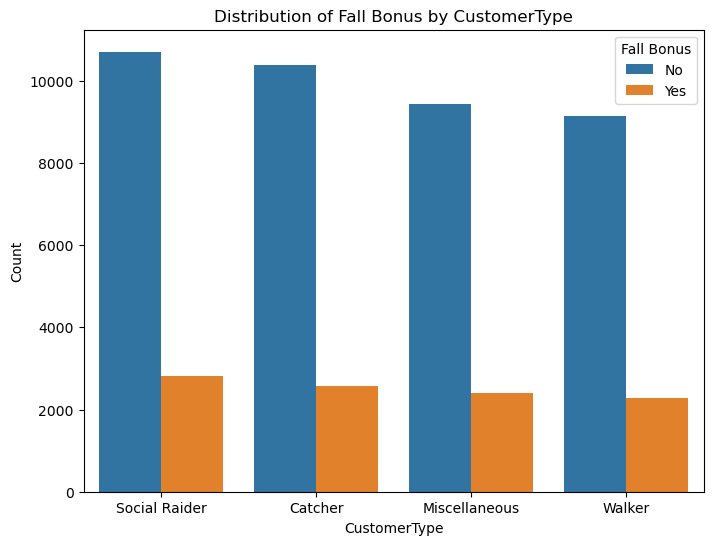

In [100]:
# 7. Visual Exploration
#    Example: Bar plot of CustomerType vs. fallbonus
if 'CustomerType' in segmented['summer_custsegm'].columns:
    plt.figure(figsize=(8,6))
    sns.countplot(data=segmented['summer_custsegm'], x='CustomerType', hue='fallbonus')
    plt.title("Distribution of Fall Bonus by CustomerType")
    plt.xlabel("CustomerType")
    plt.ylabel("Count")
    plt.legend(title='Fall Bonus', labels=['No', 'Yes'])
    plt.show()

## Customer Type Analysis

In [101]:
analysis['summersesstrx_grouped'] = data['summersesstrx'].groupby('CustomerID', as_index=False).agg({'Experience': 'sum', 'Duration': 'sum'})
basetable['summer'] = pd.merge(basetable['summer'], analysis['summersesstrx_grouped'], on='CustomerID', how='left')

In [102]:
basetable['summer']['CustomerType'] = basetable['summer']['CustomerType'].replace({0: 'Walker', 1: 'Miscellaneous', 2: 'Social Raider', 3: 'Catcher'})

In [103]:
basetable['summer']

CustomerID  frequency  recency   CustomerType Registrationdate  Gender  \
0               1          6        9  Social Raider       2021-01-01    Male   
1               2         10        8        Catcher       2022-01-21    Male   
2               3          4       50  Miscellaneous       2021-05-27    Male   
3               4          9       11        Catcher       2022-04-10  Female   
4               5          6       52  Miscellaneous       2021-05-16  Female   
...           ...        ...      ...            ...              ...     ...   
49758       49996         10        3         Walker       2022-03-27  Female   
49759       49997         10       16        Catcher       2022-03-04    Male   
49760       49998          6       22  Social Raider       2018-07-26    Male   
49761       49999          9        1        Catcher       2020-12-30    Male   
49762       50000         10        9        Catcher       2022-04-06    Male   

       Age  fallbonus  Income  MonetaryValue age_group  Experience    Duration  
0        8          0     Low           0.00      6-17       25413  467.125732  
1       45          0    High           0.00     38-49       40870  326.701266  
2       29          1    High           0.00     28-37       16987  118.696935  
3       18          0    High           4.99      6-17       37459  290.401223  
4       48          1     Low           0.00     38-49       23175  156.226666  
...    ...        ...     ...            ...       ...         ...         ...  
49758    9          1     Low           0.00      6-17       33909  776.672629  
49759   37          0     Low           0.00     28-37       36071  275.354204  
49760   27          1  Medium           9.98     18-27       36106  556.603774  
49761   28          0    High           0.00     18-27       39043  195.757207  
49762   26          0     Low           0.00     18-27       40376  312.569905  

[49763 rows x 13 columns]

In [104]:
basetable['summer'].groupby('CustomerType',as_index=True).agg(experience=('Experience', 'mean'))

experience
CustomerType               
Catcher        28281.808069
Miscellaneous  25421.671032
Social Raider  39640.240885
Walker         26976.040378

In [105]:
basetable['summer'].groupby('CustomerType',as_index=True).agg(duration=('Duration', 'mean'))

duration
CustomerType             
Catcher        199.952927
Miscellaneous  288.025486
Social Raider  997.962873
Walker         511.696469

In [106]:
basetable['summer']['Income'] = basetable['summer']['Income'].replace({'Low': 0, 'Medium': 1, 'High': 2})
basetable['summer'].groupby('CustomerType',as_index=True).agg(income=('Income', 'mean'))

C:\Users\cedri\AppData\Local\Temp\ipykernel_19960\499658525.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


income
CustomerType           
Catcher        1.186917
Miscellaneous  0.981330
Social Raider  0.422750
Walker         0.939346

In [107]:
basetable['summer'].groupby('CustomerType',as_index=True).agg(recency=('recency', 'mean'))

recency
CustomerType            
Catcher        16.949549
Miscellaneous  18.047732
Social Raider  14.802973
Walker         16.829488

In [108]:
basetable['summer'].groupby('CustomerType',as_index=True).agg(frequency=('frequency', 'mean'))

frequency
CustomerType            
Catcher         7.376765
Miscellaneous   7.128157
Social Raider   8.433992
Walker          7.449222

In [109]:
basetable['summer'].groupby('CustomerType',as_index=True).agg(monetaryvalue=('MonetaryValue', 'mean'))

monetaryvalue
CustomerType                
Catcher             3.100644
Miscellaneous       2.035633
Social Raider       7.936667
Walker              2.344926